In [94]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Concatenate
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import numpy as np

In [3]:
from imutils import paths


In [19]:
import os

print(os.listdir("../../dataset/train"))

['Baked Potato', 'Burger', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Pizza', 'Sandwich', 'Taco', 'Taquito']


In [26]:
imagePaths = os.listdir("dataset/train")

for i,j in enumerate(imagePaths):
    imagePaths = list(paths.list_images("dataset/train/"+j))

In [27]:
imagePaths

['dataset/train/Taquito\\Taquito-Train (1).jpeg',
 'dataset/train/Taquito\\Taquito-Train (10).jpeg',
 'dataset/train/Taquito\\Taquito-Train (100).jpeg',
 'dataset/train/Taquito\\Taquito-Train (1000).jpeg',
 'dataset/train/Taquito\\Taquito-Train (1001).jpeg',
 'dataset/train/Taquito\\Taquito-Train (1002).jpeg',
 'dataset/train/Taquito\\Taquito-Train (1003).jpeg',
 'dataset/train/Taquito\\Taquito-Train (1004).jpeg',
 'dataset/train/Taquito\\Taquito-Train (1005).jpeg',
 'dataset/train/Taquito\\Taquito-Train (1006).jpeg',
 'dataset/train/Taquito\\Taquito-Train (1007).jpeg',
 'dataset/train/Taquito\\Taquito-Train (1008).jpeg',
 'dataset/train/Taquito\\Taquito-Train (1009).jpeg',
 'dataset/train/Taquito\\Taquito-Train (101).jpeg',
 'dataset/train/Taquito\\Taquito-Train (1010).jpeg',
 'dataset/train/Taquito\\Taquito-Train (1011).jpeg',
 'dataset/train/Taquito\\Taquito-Train (1012).jpeg',
 'dataset/train/Taquito\\Taquito-Train (1013).jpeg',
 'dataset/train/Taquito\\Taquito-Train (1014).jpeg',


Q:\Anaconda3\envs\dlgpu\lib\site-packages\PIL\Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


(15000, 32, 32, 3)


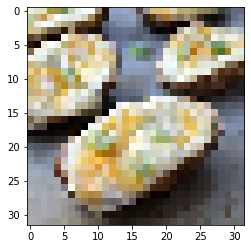

In [28]:
imagePaths = list(paths.list_images("dataset/train"))
data=[]
for i in imagePaths:
#     label=i.split(os.path.sep)[-2]
#     labels.append(label)
    image = load_img(i,target_size=(32,32))
#     image = image.convert('L')
    image = img_to_array(image)
#         image = preprocess_input(image)
    data.append(image)

data = np.array(data)
plt.imshow(data[0].astype('uint8'))

data = data.astype('float32')
data = (data - 127.5) / 127.5 #BC of tanh activation of Generator
print(data.shape)



In [83]:
arr =np.ones((1500,1))
arr1 =np.ones((3000,1))
                    
trainy = np.array(())
trainy = np.reshape(trainy, (0,1))
trainy.shape

(0, 1)

In [85]:
trainy = np.array(())
trainy = np.reshape(trainy, (0,1))
for i in range(10):
    trainy = np.concatenate((trainy,np.ones((1500,1)) * i))


print(trainy)
print(trainy.shape)

[[0.]
 [0.]
 [0.]
 ...
 [9.]
 [9.]
 [9.]]
(15000, 1)


In [86]:
# load Celeb training images
def load_real_samples():
    imagePaths = list(paths.list_images("dataset/train"))
    data=[]
    for i in imagePaths:
    #     label=i.split(os.path.sep)[-2]
    #     labels.append(label)
        image = load_img(i,target_size=(32,32))
    #     image = image.convert('L')
        image = img_to_array(image)
    #         image = preprocess_input(image)
        data.append(image)

    data = np.array(data)
    plt.imshow(data[0].astype('uint8'))

    data = data.astype('float32')
    X = (data - 127.5) / 127.5 #BC of tanh activation of Generator
    trainy = np.array(())
    trainy = np.reshape(trainy, (0,1))
    for i in range(10):
        trainy = np.concatenate((trainy,np.ones((1500,1)) * i))

    return [X,trainy]

In [95]:
# define the standalone discriminator model
#Given an input image, the Discriminator outputs the likelihood of the image being real.
#Binary classification - true or false (1 or 0). So using sigmoid activation.

#Unlike regular GAN here we are also providing number of classes as input. 
#Input to the model will be both images and labels. 
def define_discriminator(in_shape=(32,32,3), n_classes=10):
	
    # label input
	in_label = Input(shape=(1,))  #Shape 1
	# embedding for categorical input
    #each label (total 10 classes for cifar), will be represented by a vector of size 50. 
    #This vector of size 50 will be learnt by the discriminator
	li = Embedding(n_classes, 50)(in_label) #Shape 1,50
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]  #32x32 = 1024. 
	li = Dense(n_nodes)(li)  #Shape = 1, 1024
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)  #32x32x1
    
    
	# image input
	in_image = Input(shape=in_shape) #32x32x3
	# concat label as a channel
	merge = Concatenate()([in_image, li]) #32x32x4 (4 channels, 3 for image and the other for labels)
    
	# downsample: This part is same as unconditional GAN upto the output layer.
    #We will combine input label with input image and supply as inputs to the model. 
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge) #16x16x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) #8x8x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)  #8192  (8*8*128=8192)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)  #Shape=1
    
	# define model
    ##Combine input label with input image and supply as inputs to the model. 
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()
print(test_discr.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_4[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1, 1024)      52224       embedding_1[0][0]                
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
_______________________________________________________________________________________

In [96]:
def define_generator(latent_dim, n_classes=10):
    
	# label input
	in_label = Input(shape=(1,))  #Input of dimension 1
	# embedding for categorical input
    #each label (total 10 classes for cifar), will be represented by a vector of size 50. 
	li = Embedding(n_classes, 50)(in_label) #Shape 1,50
    
	# linear multiplication
	n_nodes = 8 * 8  # To match the dimensions for concatenation later in this step.  
	li = Dense(n_nodes)(li) #1,64
	# reshape to additional channel
	li = Reshape((8, 8, 1))(li)
    
    
	# image generator input
	in_lat = Input(shape=(latent_dim,))  #Input of dimension 100
    
	# foundation for 8x8 image
    # We will reshape input latent vector into 8x8 image as a starting point. 
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output 
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
    #Note that this part is same as unconditional GAN until the output layer. 
    #While defining model inputs we will combine input label and the latent input.
	n_nodes = 128 * 8 * 8
	gen = Dense(n_nodes)(in_lat)  #shape=8192
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((8, 8, 128))(gen) #Shape=8x8x128
	# merge image gen and label input
	merge = Concatenate()([gen, li])  #Shape=8x8x129 (Extra channel corresponds to the label)
	# upsample to 16x16
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) #16x16x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) #32x32x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen) #32x32x3
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model   #Model not compiled as it is not directly trained like the discriminator.

test_gen = define_generator(100, n_classes=10)
print(test_gen.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 8192)         827392      input_7[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        500         input_6[0][0]                    
_______________________________________________________________________________________

In [97]:

# #Generator is trained via GAN combined model. 
# define the combined generator and discriminator model, for updating the generator
#Discriminator is trained separately so here only generator will be trained by keeping
#the discriminator constant. 
def define_gan(g_model, d_model):
	d_model.trainable = False  #Discriminator is trained separately. So set to not trainable.
    
    ## connect generator and discriminator...
	# first, get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input  #Latent vector size and label size
	# get image output from the generator model
	gen_output = g_model.output  #32x32x3
    
	# generator image output and corresponding input label are inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# # select real samples
# pick a batch of random real samples to train the GAN
#In fact, we will train the GAN on a half batch of real images and another 
#half batch of fake images. 
#For each real image we assign a label 1 and for fake we assign label 0. 
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset  
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels and assign to y (don't confuse this with the above labels that correspond to cifar labels)
	y = ones((n_samples, 1))  #Label=1 indicating they are real
	return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# use the generator to generate n fake examples, with class labels
#Supply the generator, latent_dim and number of samples as input.
#Use the above latent point generator to generate latent points. 
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return [images, labels_input], y

# train the generator and discriminator
#We loop through a number of epochs to train our Discriminator by first selecting
#a random batch of images from our true/real dataset.
#Then, generating a set of images using the generator. 
#Feed both set of images into the Discriminator. 
#Finally, set the loss parameters for both the real and fake images, as well as the combined loss. 
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples 
                            #and a half batch of fake samples, combined a single batch. 
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			
             # Train the discriminator on real and fake images, separately (half batch each)
        #Research showed that separate training is more effective. 
			# get randomly selected 'real' samples
            # get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

            # update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection 
            #of samples you provide
			d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            
            # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the generator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)	
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
             # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# Print losses on this batch
			print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	# save the generator model
	savename = "foodGenerator_"+str(n_epochs)+"epochs_"+str(n_batch)+"batch.h5" 
	g_model.save(savename)

In [98]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)

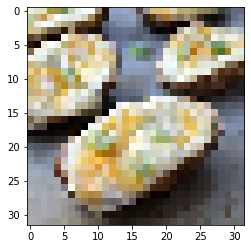

In [99]:
dataset = load_real_samples()

In [102]:
print(len(dataset))
print(dataset[0].shape)
print(dataset[1].shape)

2
(15000, 32, 32, 3)
(15000, 1)


In [110]:
epochs_trial = 250
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=epochs_trial)

Epoch>1, Batch1/117, d1=0.739, d2=0.730 g=0.706
Epoch>1, Batch2/117, d1=0.743, d2=0.691 g=0.737
Epoch>1, Batch3/117, d1=0.747, d2=0.688 g=0.775
Epoch>1, Batch4/117, d1=0.728, d2=0.660 g=0.767
Epoch>1, Batch5/117, d1=0.747, d2=0.681 g=0.766
Epoch>1, Batch6/117, d1=0.742, d2=0.659 g=0.774
Epoch>1, Batch7/117, d1=0.686, d2=0.706 g=0.748
Epoch>1, Batch8/117, d1=0.709, d2=0.725 g=0.725
Epoch>1, Batch9/117, d1=0.702, d2=0.706 g=0.706
Epoch>1, Batch10/117, d1=0.696, d2=0.750 g=0.702
Epoch>1, Batch11/117, d1=0.685, d2=0.731 g=0.717
Epoch>1, Batch12/117, d1=0.708, d2=0.764 g=0.715
Epoch>1, Batch13/117, d1=0.744, d2=0.717 g=0.709
Epoch>1, Batch14/117, d1=0.700, d2=0.738 g=0.727
Epoch>1, Batch15/117, d1=0.718, d2=0.709 g=0.741
Epoch>1, Batch16/117, d1=0.738, d2=0.689 g=0.774
Epoch>1, Batch17/117, d1=0.768, d2=0.672 g=0.777
Epoch>1, Batch18/117, d1=0.730, d2=0.670 g=0.797
Epoch>1, Batch19/117, d1=0.731, d2=0.642 g=0.800
Epoch>1, Batch20/117, d1=0.740, d2=0.614 g=0.783
Epoch>1, Batch21/117, d1=0.72

Epoch>2, Batch52/117, d1=0.656, d2=0.763 g=0.686
Epoch>2, Batch53/117, d1=0.692, d2=0.755 g=0.686
Epoch>2, Batch54/117, d1=0.682, d2=0.774 g=0.690
Epoch>2, Batch55/117, d1=0.744, d2=0.742 g=0.713
Epoch>2, Batch56/117, d1=0.734, d2=0.724 g=0.746
Epoch>2, Batch57/117, d1=0.713, d2=0.696 g=0.794
Epoch>2, Batch58/117, d1=0.742, d2=0.649 g=0.842
Epoch>2, Batch59/117, d1=0.764, d2=0.617 g=0.862
Epoch>2, Batch60/117, d1=0.805, d2=0.616 g=0.850
Epoch>2, Batch61/117, d1=0.780, d2=0.598 g=0.859
Epoch>2, Batch62/117, d1=0.802, d2=0.600 g=0.865
Epoch>2, Batch63/117, d1=0.766, d2=0.614 g=0.849
Epoch>2, Batch64/117, d1=0.766, d2=0.616 g=0.840
Epoch>2, Batch65/117, d1=0.771, d2=0.629 g=0.813
Epoch>2, Batch66/117, d1=0.729, d2=0.640 g=0.783
Epoch>2, Batch67/117, d1=0.750, d2=0.664 g=0.774
Epoch>2, Batch68/117, d1=0.735, d2=0.663 g=0.770
Epoch>2, Batch69/117, d1=0.742, d2=0.675 g=0.752
Epoch>2, Batch70/117, d1=0.731, d2=0.678 g=0.749
Epoch>2, Batch71/117, d1=0.731, d2=0.713 g=0.731
Epoch>2, Batch72/117

Epoch>3, Batch102/117, d1=0.696, d2=0.661 g=0.797
Epoch>3, Batch103/117, d1=0.736, d2=0.653 g=0.799
Epoch>3, Batch104/117, d1=0.670, d2=0.660 g=0.794
Epoch>3, Batch105/117, d1=0.678, d2=0.647 g=0.807
Epoch>3, Batch106/117, d1=0.706, d2=0.660 g=0.788
Epoch>3, Batch107/117, d1=0.705, d2=0.679 g=0.799
Epoch>3, Batch108/117, d1=0.682, d2=0.649 g=0.777
Epoch>3, Batch109/117, d1=0.725, d2=0.641 g=0.776
Epoch>3, Batch110/117, d1=0.711, d2=0.671 g=0.785
Epoch>3, Batch111/117, d1=0.695, d2=0.655 g=0.782
Epoch>3, Batch112/117, d1=0.754, d2=0.652 g=0.777
Epoch>3, Batch113/117, d1=0.704, d2=0.680 g=0.770
Epoch>3, Batch114/117, d1=0.740, d2=0.642 g=0.779
Epoch>3, Batch115/117, d1=0.722, d2=0.682 g=0.786
Epoch>3, Batch116/117, d1=0.709, d2=0.658 g=0.777
Epoch>3, Batch117/117, d1=0.688, d2=0.658 g=0.791
Epoch>4, Batch1/117, d1=0.703, d2=0.648 g=0.784
Epoch>4, Batch2/117, d1=0.689, d2=0.666 g=0.771
Epoch>4, Batch3/117, d1=0.663, d2=0.679 g=0.773
Epoch>4, Batch4/117, d1=0.699, d2=0.694 g=0.738
Epoch>4,

Epoch>5, Batch35/117, d1=0.764, d2=0.688 g=0.742
Epoch>5, Batch36/117, d1=0.779, d2=0.707 g=0.743
Epoch>5, Batch37/117, d1=0.752, d2=0.718 g=0.739
Epoch>5, Batch38/117, d1=0.720, d2=0.695 g=0.763
Epoch>5, Batch39/117, d1=0.738, d2=0.685 g=0.768
Epoch>5, Batch40/117, d1=0.747, d2=0.685 g=0.778
Epoch>5, Batch41/117, d1=0.740, d2=0.670 g=0.751
Epoch>5, Batch42/117, d1=0.716, d2=0.677 g=0.780
Epoch>5, Batch43/117, d1=0.685, d2=0.691 g=0.775
Epoch>5, Batch44/117, d1=0.667, d2=0.669 g=0.809
Epoch>5, Batch45/117, d1=0.684, d2=0.642 g=0.803
Epoch>5, Batch46/117, d1=0.682, d2=0.678 g=0.778
Epoch>5, Batch47/117, d1=0.688, d2=0.670 g=0.763
Epoch>5, Batch48/117, d1=0.645, d2=0.704 g=0.754
Epoch>5, Batch49/117, d1=0.670, d2=0.700 g=0.744
Epoch>5, Batch50/117, d1=0.640, d2=0.729 g=0.746
Epoch>5, Batch51/117, d1=0.695, d2=0.721 g=0.746
Epoch>5, Batch52/117, d1=0.693, d2=0.710 g=0.740
Epoch>5, Batch53/117, d1=0.712, d2=0.711 g=0.771
Epoch>5, Batch54/117, d1=0.732, d2=0.688 g=0.776
Epoch>5, Batch55/117

Epoch>6, Batch86/117, d1=0.779, d2=0.614 g=0.847
Epoch>6, Batch87/117, d1=0.765, d2=0.618 g=0.855
Epoch>6, Batch88/117, d1=0.781, d2=0.614 g=0.818
Epoch>6, Batch89/117, d1=0.822, d2=0.636 g=0.800
Epoch>6, Batch90/117, d1=0.752, d2=0.647 g=0.778
Epoch>6, Batch91/117, d1=0.750, d2=0.643 g=0.783
Epoch>6, Batch92/117, d1=0.746, d2=0.670 g=0.760
Epoch>6, Batch93/117, d1=0.724, d2=0.664 g=0.747
Epoch>6, Batch94/117, d1=0.706, d2=0.680 g=0.748
Epoch>6, Batch95/117, d1=0.677, d2=0.705 g=0.740
Epoch>6, Batch96/117, d1=0.669, d2=0.705 g=0.713
Epoch>6, Batch97/117, d1=0.666, d2=0.714 g=0.709
Epoch>6, Batch98/117, d1=0.638, d2=0.736 g=0.704
Epoch>6, Batch99/117, d1=0.639, d2=0.706 g=0.714
Epoch>6, Batch100/117, d1=0.615, d2=0.714 g=0.723
Epoch>6, Batch101/117, d1=0.617, d2=0.689 g=0.734
Epoch>6, Batch102/117, d1=0.608, d2=0.708 g=0.760
Epoch>6, Batch103/117, d1=0.603, d2=0.678 g=0.747
Epoch>6, Batch104/117, d1=0.609, d2=0.689 g=0.756
Epoch>6, Batch105/117, d1=0.602, d2=0.705 g=0.735
Epoch>6, Batch

Epoch>8, Batch19/117, d1=0.660, d2=0.769 g=0.711
Epoch>8, Batch20/117, d1=0.662, d2=0.717 g=0.733
Epoch>8, Batch21/117, d1=0.710, d2=0.694 g=0.789
Epoch>8, Batch22/117, d1=0.711, d2=0.662 g=0.810
Epoch>8, Batch23/117, d1=0.726, d2=0.617 g=0.856
Epoch>8, Batch24/117, d1=0.708, d2=0.578 g=0.878
Epoch>8, Batch25/117, d1=0.721, d2=0.592 g=0.892
Epoch>8, Batch26/117, d1=0.748, d2=0.583 g=0.885
Epoch>8, Batch27/117, d1=0.734, d2=0.578 g=0.889
Epoch>8, Batch28/117, d1=0.729, d2=0.595 g=0.887
Epoch>8, Batch29/117, d1=0.723, d2=0.627 g=0.841
Epoch>8, Batch30/117, d1=0.704, d2=0.633 g=0.811
Epoch>8, Batch31/117, d1=0.732, d2=0.687 g=0.780
Epoch>8, Batch32/117, d1=0.731, d2=0.700 g=0.747
Epoch>8, Batch33/117, d1=0.743, d2=0.733 g=0.706
Epoch>8, Batch34/117, d1=0.720, d2=0.737 g=0.703
Epoch>8, Batch35/117, d1=0.716, d2=0.792 g=0.666
Epoch>8, Batch36/117, d1=0.693, d2=0.761 g=0.682
Epoch>8, Batch37/117, d1=0.752, d2=0.755 g=0.674
Epoch>8, Batch38/117, d1=0.713, d2=0.773 g=0.679
Epoch>8, Batch39/117

Epoch>9, Batch70/117, d1=0.791, d2=0.636 g=0.804
Epoch>9, Batch71/117, d1=0.771, d2=0.640 g=0.786
Epoch>9, Batch72/117, d1=0.758, d2=0.657 g=0.775
Epoch>9, Batch73/117, d1=0.755, d2=0.656 g=0.760
Epoch>9, Batch74/117, d1=0.751, d2=0.666 g=0.760
Epoch>9, Batch75/117, d1=0.765, d2=0.681 g=0.758
Epoch>9, Batch76/117, d1=0.741, d2=0.679 g=0.756
Epoch>9, Batch77/117, d1=0.719, d2=0.690 g=0.739
Epoch>9, Batch78/117, d1=0.690, d2=0.694 g=0.753
Epoch>9, Batch79/117, d1=0.697, d2=0.679 g=0.759
Epoch>9, Batch80/117, d1=0.688, d2=0.690 g=0.764
Epoch>9, Batch81/117, d1=0.671, d2=0.677 g=0.751
Epoch>9, Batch82/117, d1=0.667, d2=0.664 g=0.749
Epoch>9, Batch83/117, d1=0.648, d2=0.673 g=0.751
Epoch>9, Batch84/117, d1=0.631, d2=0.665 g=0.760
Epoch>9, Batch85/117, d1=0.617, d2=0.669 g=0.743
Epoch>9, Batch86/117, d1=0.604, d2=0.709 g=0.727
Epoch>9, Batch87/117, d1=0.599, d2=0.709 g=0.718
Epoch>9, Batch88/117, d1=0.606, d2=0.737 g=0.720
Epoch>9, Batch89/117, d1=0.617, d2=0.745 g=0.704
Epoch>9, Batch90/117

Epoch>11, Batch1/117, d1=0.676, d2=0.716 g=0.704
Epoch>11, Batch2/117, d1=0.719, d2=0.751 g=0.696
Epoch>11, Batch3/117, d1=0.711, d2=0.741 g=0.679
Epoch>11, Batch4/117, d1=0.700, d2=0.752 g=0.679
Epoch>11, Batch5/117, d1=0.693, d2=0.745 g=0.664
Epoch>11, Batch6/117, d1=0.696, d2=0.758 g=0.685
Epoch>11, Batch7/117, d1=0.682, d2=0.747 g=0.692
Epoch>11, Batch8/117, d1=0.699, d2=0.742 g=0.694
Epoch>11, Batch9/117, d1=0.678, d2=0.713 g=0.715
Epoch>11, Batch10/117, d1=0.693, d2=0.717 g=0.707
Epoch>11, Batch11/117, d1=0.690, d2=0.700 g=0.718
Epoch>11, Batch12/117, d1=0.688, d2=0.713 g=0.726
Epoch>11, Batch13/117, d1=0.676, d2=0.690 g=0.747
Epoch>11, Batch14/117, d1=0.673, d2=0.700 g=0.742
Epoch>11, Batch15/117, d1=0.653, d2=0.680 g=0.747
Epoch>11, Batch16/117, d1=0.653, d2=0.688 g=0.734
Epoch>11, Batch17/117, d1=0.657, d2=0.692 g=0.750
Epoch>11, Batch18/117, d1=0.652, d2=0.692 g=0.747
Epoch>11, Batch19/117, d1=0.657, d2=0.699 g=0.753
Epoch>11, Batch20/117, d1=0.662, d2=0.721 g=0.728
Epoch>11,

Epoch>12, Batch48/117, d1=0.657, d2=0.714 g=0.723
Epoch>12, Batch49/117, d1=0.670, d2=0.690 g=0.737
Epoch>12, Batch50/117, d1=0.665, d2=0.680 g=0.759
Epoch>12, Batch51/117, d1=0.658, d2=0.638 g=0.772
Epoch>12, Batch52/117, d1=0.655, d2=0.660 g=0.777
Epoch>12, Batch53/117, d1=0.653, d2=0.643 g=0.767
Epoch>12, Batch54/117, d1=0.610, d2=0.665 g=0.779
Epoch>12, Batch55/117, d1=0.668, d2=0.676 g=0.736
Epoch>12, Batch56/117, d1=0.621, d2=0.705 g=0.731
Epoch>12, Batch57/117, d1=0.658, d2=0.737 g=0.703
Epoch>12, Batch58/117, d1=0.680, d2=0.729 g=0.678
Epoch>12, Batch59/117, d1=0.723, d2=0.734 g=0.682
Epoch>12, Batch60/117, d1=0.663, d2=0.745 g=0.684
Epoch>12, Batch61/117, d1=0.684, d2=0.755 g=0.686
Epoch>12, Batch62/117, d1=0.704, d2=0.745 g=0.714
Epoch>12, Batch63/117, d1=0.725, d2=0.716 g=0.726
Epoch>12, Batch64/117, d1=0.711, d2=0.704 g=0.740
Epoch>12, Batch65/117, d1=0.728, d2=0.683 g=0.761
Epoch>12, Batch66/117, d1=0.707, d2=0.662 g=0.796
Epoch>12, Batch67/117, d1=0.731, d2=0.652 g=0.804


Epoch>13, Batch95/117, d1=0.723, d2=0.597 g=0.832
Epoch>13, Batch96/117, d1=0.718, d2=0.605 g=0.813
Epoch>13, Batch97/117, d1=0.742, d2=0.625 g=0.826
Epoch>13, Batch98/117, d1=0.705, d2=0.618 g=0.814
Epoch>13, Batch99/117, d1=0.713, d2=0.629 g=0.809
Epoch>13, Batch100/117, d1=0.728, d2=0.629 g=0.798
Epoch>13, Batch101/117, d1=0.711, d2=0.654 g=0.798
Epoch>13, Batch102/117, d1=0.680, d2=0.657 g=0.782
Epoch>13, Batch103/117, d1=0.708, d2=0.675 g=0.760
Epoch>13, Batch104/117, d1=0.697, d2=0.718 g=0.733
Epoch>13, Batch105/117, d1=0.674, d2=0.691 g=0.720
Epoch>13, Batch106/117, d1=0.680, d2=0.712 g=0.712
Epoch>13, Batch107/117, d1=0.685, d2=0.711 g=0.711
Epoch>13, Batch108/117, d1=0.676, d2=0.735 g=0.733
Epoch>13, Batch109/117, d1=0.708, d2=0.727 g=0.741
Epoch>13, Batch110/117, d1=0.683, d2=0.682 g=0.752
Epoch>13, Batch111/117, d1=0.690, d2=0.688 g=0.765
Epoch>13, Batch112/117, d1=0.677, d2=0.672 g=0.767
Epoch>13, Batch113/117, d1=0.691, d2=0.653 g=0.798
Epoch>13, Batch114/117, d1=0.676, d2

Epoch>15, Batch25/117, d1=0.688, d2=0.678 g=0.763
Epoch>15, Batch26/117, d1=0.648, d2=0.672 g=0.782
Epoch>15, Batch27/117, d1=0.638, d2=0.670 g=0.781
Epoch>15, Batch28/117, d1=0.699, d2=0.679 g=0.808
Epoch>15, Batch29/117, d1=0.670, d2=0.687 g=0.760
Epoch>15, Batch30/117, d1=0.736, d2=0.702 g=0.764
Epoch>15, Batch31/117, d1=0.682, d2=0.681 g=0.764
Epoch>15, Batch32/117, d1=0.716, d2=0.678 g=0.775
Epoch>15, Batch33/117, d1=0.733, d2=0.676 g=0.773
Epoch>15, Batch34/117, d1=0.732, d2=0.648 g=0.777
Epoch>15, Batch35/117, d1=0.720, d2=0.650 g=0.772
Epoch>15, Batch36/117, d1=0.717, d2=0.668 g=0.768
Epoch>15, Batch37/117, d1=0.724, d2=0.667 g=0.764
Epoch>15, Batch38/117, d1=0.732, d2=0.682 g=0.751
Epoch>15, Batch39/117, d1=0.704, d2=0.666 g=0.744
Epoch>15, Batch40/117, d1=0.692, d2=0.681 g=0.734
Epoch>15, Batch41/117, d1=0.712, d2=0.695 g=0.750
Epoch>15, Batch42/117, d1=0.724, d2=0.708 g=0.721
Epoch>15, Batch43/117, d1=0.720, d2=0.723 g=0.727
Epoch>15, Batch44/117, d1=0.698, d2=0.707 g=0.734


Epoch>16, Batch72/117, d1=0.680, d2=0.619 g=0.857
Epoch>16, Batch73/117, d1=0.657, d2=0.614 g=0.860
Epoch>16, Batch74/117, d1=0.645, d2=0.622 g=0.859
Epoch>16, Batch75/117, d1=0.638, d2=0.645 g=0.838
Epoch>16, Batch76/117, d1=0.647, d2=0.665 g=0.791
Epoch>16, Batch77/117, d1=0.658, d2=0.693 g=0.766
Epoch>16, Batch78/117, d1=0.625, d2=0.698 g=0.772
Epoch>16, Batch79/117, d1=0.587, d2=0.724 g=0.764
Epoch>16, Batch80/117, d1=0.595, d2=0.705 g=0.778
Epoch>16, Batch81/117, d1=0.650, d2=0.671 g=0.773
Epoch>16, Batch82/117, d1=0.632, d2=0.670 g=0.773
Epoch>16, Batch83/117, d1=0.626, d2=0.685 g=0.781
Epoch>16, Batch84/117, d1=0.663, d2=0.647 g=0.836
Epoch>16, Batch85/117, d1=0.692, d2=0.672 g=0.829
Epoch>16, Batch86/117, d1=0.668, d2=0.667 g=0.833
Epoch>16, Batch87/117, d1=0.699, d2=0.647 g=0.808
Epoch>16, Batch88/117, d1=0.704, d2=0.648 g=0.810
Epoch>16, Batch89/117, d1=0.700, d2=0.662 g=0.816
Epoch>16, Batch90/117, d1=0.708, d2=0.661 g=0.793
Epoch>16, Batch91/117, d1=0.720, d2=0.667 g=0.783


Epoch>18, Batch2/117, d1=0.696, d2=0.678 g=0.776
Epoch>18, Batch3/117, d1=0.663, d2=0.692 g=0.811
Epoch>18, Batch4/117, d1=0.712, d2=0.651 g=0.822
Epoch>18, Batch5/117, d1=0.645, d2=0.631 g=0.843
Epoch>18, Batch6/117, d1=0.647, d2=0.643 g=0.893
Epoch>18, Batch7/117, d1=0.657, d2=0.599 g=0.875
Epoch>18, Batch8/117, d1=0.670, d2=0.622 g=0.877
Epoch>18, Batch9/117, d1=0.630, d2=0.606 g=0.868
Epoch>18, Batch10/117, d1=0.654, d2=0.638 g=0.822
Epoch>18, Batch11/117, d1=0.627, d2=0.676 g=0.834
Epoch>18, Batch12/117, d1=0.639, d2=0.685 g=0.822
Epoch>18, Batch13/117, d1=0.618, d2=0.654 g=0.784
Epoch>18, Batch14/117, d1=0.625, d2=0.713 g=0.800
Epoch>18, Batch15/117, d1=0.637, d2=0.696 g=0.804
Epoch>18, Batch16/117, d1=0.648, d2=0.730 g=0.820
Epoch>18, Batch17/117, d1=0.631, d2=0.697 g=0.794
Epoch>18, Batch18/117, d1=0.662, d2=0.740 g=0.763
Epoch>18, Batch19/117, d1=0.609, d2=0.758 g=0.753
Epoch>18, Batch20/117, d1=0.664, d2=0.824 g=0.715
Epoch>18, Batch21/117, d1=0.671, d2=0.800 g=0.717
Epoch>18

Epoch>19, Batch49/117, d1=0.687, d2=0.713 g=0.735
Epoch>19, Batch50/117, d1=0.671, d2=0.717 g=0.774
Epoch>19, Batch51/117, d1=0.689, d2=0.712 g=0.764
Epoch>19, Batch52/117, d1=0.743, d2=0.712 g=0.764
Epoch>19, Batch53/117, d1=0.734, d2=0.731 g=0.763
Epoch>19, Batch54/117, d1=0.708, d2=0.725 g=0.754
Epoch>19, Batch55/117, d1=0.745, d2=0.741 g=0.723
Epoch>19, Batch56/117, d1=0.735, d2=0.765 g=0.711
Epoch>19, Batch57/117, d1=0.747, d2=0.783 g=0.715
Epoch>19, Batch58/117, d1=0.764, d2=0.811 g=0.709
Epoch>19, Batch59/117, d1=0.743, d2=0.773 g=0.707
Epoch>19, Batch60/117, d1=0.766, d2=0.756 g=0.716
Epoch>19, Batch61/117, d1=0.772, d2=0.756 g=0.746
Epoch>19, Batch62/117, d1=0.786, d2=0.735 g=0.749
Epoch>19, Batch63/117, d1=0.737, d2=0.748 g=0.774
Epoch>19, Batch64/117, d1=0.756, d2=0.679 g=0.796
Epoch>19, Batch65/117, d1=0.770, d2=0.699 g=0.803
Epoch>19, Batch66/117, d1=0.769, d2=0.733 g=0.801
Epoch>19, Batch67/117, d1=0.738, d2=0.680 g=0.838
Epoch>19, Batch68/117, d1=0.737, d2=0.640 g=0.857


Epoch>20, Batch96/117, d1=0.665, d2=0.680 g=0.751
Epoch>20, Batch97/117, d1=0.668, d2=0.681 g=0.733
Epoch>20, Batch98/117, d1=0.675, d2=0.700 g=0.727
Epoch>20, Batch99/117, d1=0.693, d2=0.700 g=0.743
Epoch>20, Batch100/117, d1=0.699, d2=0.697 g=0.748
Epoch>20, Batch101/117, d1=0.686, d2=0.695 g=0.733
Epoch>20, Batch102/117, d1=0.701, d2=0.688 g=0.762
Epoch>20, Batch103/117, d1=0.707, d2=0.672 g=0.778
Epoch>20, Batch104/117, d1=0.699, d2=0.667 g=0.764
Epoch>20, Batch105/117, d1=0.676, d2=0.651 g=0.776
Epoch>20, Batch106/117, d1=0.685, d2=0.674 g=0.789
Epoch>20, Batch107/117, d1=0.721, d2=0.659 g=0.783
Epoch>20, Batch108/117, d1=0.714, d2=0.666 g=0.781
Epoch>20, Batch109/117, d1=0.714, d2=0.666 g=0.785
Epoch>20, Batch110/117, d1=0.683, d2=0.696 g=0.767
Epoch>20, Batch111/117, d1=0.702, d2=0.679 g=0.748
Epoch>20, Batch112/117, d1=0.714, d2=0.688 g=0.745
Epoch>20, Batch113/117, d1=0.693, d2=0.671 g=0.736
Epoch>20, Batch114/117, d1=0.688, d2=0.691 g=0.761
Epoch>20, Batch115/117, d1=0.697, d

Epoch>22, Batch26/117, d1=0.700, d2=0.654 g=0.785
Epoch>22, Batch27/117, d1=0.729, d2=0.644 g=0.775
Epoch>22, Batch28/117, d1=0.733, d2=0.672 g=0.770
Epoch>22, Batch29/117, d1=0.740, d2=0.659 g=0.763
Epoch>22, Batch30/117, d1=0.710, d2=0.657 g=0.754
Epoch>22, Batch31/117, d1=0.721, d2=0.673 g=0.745
Epoch>22, Batch32/117, d1=0.708, d2=0.689 g=0.748
Epoch>22, Batch33/117, d1=0.709, d2=0.669 g=0.760
Epoch>22, Batch34/117, d1=0.693, d2=0.677 g=0.753
Epoch>22, Batch35/117, d1=0.703, d2=0.654 g=0.763
Epoch>22, Batch36/117, d1=0.732, d2=0.650 g=0.772
Epoch>22, Batch37/117, d1=0.686, d2=0.664 g=0.750
Epoch>22, Batch38/117, d1=0.708, d2=0.677 g=0.750
Epoch>22, Batch39/117, d1=0.701, d2=0.684 g=0.751
Epoch>22, Batch40/117, d1=0.704, d2=0.674 g=0.752
Epoch>22, Batch41/117, d1=0.707, d2=0.688 g=0.763
Epoch>22, Batch42/117, d1=0.696, d2=0.666 g=0.758
Epoch>22, Batch43/117, d1=0.704, d2=0.661 g=0.760
Epoch>22, Batch44/117, d1=0.704, d2=0.666 g=0.765
Epoch>22, Batch45/117, d1=0.695, d2=0.652 g=0.767


Epoch>23, Batch73/117, d1=0.699, d2=0.693 g=0.722
Epoch>23, Batch74/117, d1=0.699, d2=0.718 g=0.721
Epoch>23, Batch75/117, d1=0.685, d2=0.714 g=0.715
Epoch>23, Batch76/117, d1=0.695, d2=0.727 g=0.714
Epoch>23, Batch77/117, d1=0.678, d2=0.705 g=0.727
Epoch>23, Batch78/117, d1=0.691, d2=0.727 g=0.719
Epoch>23, Batch79/117, d1=0.671, d2=0.724 g=0.706
Epoch>23, Batch80/117, d1=0.689, d2=0.723 g=0.717
Epoch>23, Batch81/117, d1=0.667, d2=0.733 g=0.728
Epoch>23, Batch82/117, d1=0.671, d2=0.698 g=0.729
Epoch>23, Batch83/117, d1=0.702, d2=0.684 g=0.743
Epoch>23, Batch84/117, d1=0.672, d2=0.682 g=0.735
Epoch>23, Batch85/117, d1=0.691, d2=0.691 g=0.741
Epoch>23, Batch86/117, d1=0.686, d2=0.693 g=0.741
Epoch>23, Batch87/117, d1=0.686, d2=0.711 g=0.754
Epoch>23, Batch88/117, d1=0.711, d2=0.686 g=0.745
Epoch>23, Batch89/117, d1=0.691, d2=0.682 g=0.765
Epoch>23, Batch90/117, d1=0.714, d2=0.687 g=0.768
Epoch>23, Batch91/117, d1=0.713, d2=0.656 g=0.778
Epoch>23, Batch92/117, d1=0.693, d2=0.654 g=0.795


Epoch>25, Batch3/117, d1=0.699, d2=0.732 g=0.715
Epoch>25, Batch4/117, d1=0.690, d2=0.703 g=0.730
Epoch>25, Batch5/117, d1=0.687, d2=0.700 g=0.741
Epoch>25, Batch6/117, d1=0.672, d2=0.685 g=0.753
Epoch>25, Batch7/117, d1=0.702, d2=0.676 g=0.751
Epoch>25, Batch8/117, d1=0.705, d2=0.650 g=0.787
Epoch>25, Batch9/117, d1=0.692, d2=0.633 g=0.788
Epoch>25, Batch10/117, d1=0.701, d2=0.636 g=0.797
Epoch>25, Batch11/117, d1=0.687, d2=0.655 g=0.788
Epoch>25, Batch12/117, d1=0.683, d2=0.647 g=0.773
Epoch>25, Batch13/117, d1=0.700, d2=0.671 g=0.788
Epoch>25, Batch14/117, d1=0.687, d2=0.675 g=0.774
Epoch>25, Batch15/117, d1=0.682, d2=0.671 g=0.768
Epoch>25, Batch16/117, d1=0.717, d2=0.681 g=0.759
Epoch>25, Batch17/117, d1=0.720, d2=0.676 g=0.745
Epoch>25, Batch18/117, d1=0.687, d2=0.665 g=0.760
Epoch>25, Batch19/117, d1=0.706, d2=0.670 g=0.758
Epoch>25, Batch20/117, d1=0.691, d2=0.667 g=0.768
Epoch>25, Batch21/117, d1=0.666, d2=0.675 g=0.793
Epoch>25, Batch22/117, d1=0.703, d2=0.657 g=0.785
Epoch>2

Epoch>26, Batch50/117, d1=0.684, d2=0.678 g=0.794
Epoch>26, Batch51/117, d1=0.734, d2=0.657 g=0.812
Epoch>26, Batch52/117, d1=0.719, d2=0.638 g=0.796
Epoch>26, Batch53/117, d1=0.739, d2=0.639 g=0.810
Epoch>26, Batch54/117, d1=0.706, d2=0.608 g=0.809
Epoch>26, Batch55/117, d1=0.766, d2=0.630 g=0.821
Epoch>26, Batch56/117, d1=0.727, d2=0.637 g=0.833
Epoch>26, Batch57/117, d1=0.740, d2=0.638 g=0.839
Epoch>26, Batch58/117, d1=0.743, d2=0.647 g=0.803
Epoch>26, Batch59/117, d1=0.701, d2=0.616 g=0.820
Epoch>26, Batch60/117, d1=0.691, d2=0.625 g=0.841
Epoch>26, Batch61/117, d1=0.682, d2=0.643 g=0.831
Epoch>26, Batch62/117, d1=0.671, d2=0.643 g=0.799
Epoch>26, Batch63/117, d1=0.680, d2=0.646 g=0.790
Epoch>26, Batch64/117, d1=0.626, d2=0.666 g=0.783
Epoch>26, Batch65/117, d1=0.663, d2=0.688 g=0.767
Epoch>26, Batch66/117, d1=0.628, d2=0.700 g=0.759
Epoch>26, Batch67/117, d1=0.641, d2=0.706 g=0.759
Epoch>26, Batch68/117, d1=0.616, d2=0.715 g=0.740
Epoch>26, Batch69/117, d1=0.663, d2=0.720 g=0.731


Epoch>27, Batch97/117, d1=0.660, d2=0.665 g=0.794
Epoch>27, Batch98/117, d1=0.657, d2=0.657 g=0.812
Epoch>27, Batch99/117, d1=0.685, d2=0.695 g=0.784
Epoch>27, Batch100/117, d1=0.643, d2=0.683 g=0.803
Epoch>27, Batch101/117, d1=0.715, d2=0.654 g=0.805
Epoch>27, Batch102/117, d1=0.680, d2=0.667 g=0.780
Epoch>27, Batch103/117, d1=0.668, d2=0.658 g=0.772
Epoch>27, Batch104/117, d1=0.667, d2=0.642 g=0.773
Epoch>27, Batch105/117, d1=0.733, d2=0.748 g=0.759
Epoch>27, Batch106/117, d1=0.741, d2=0.687 g=0.771
Epoch>27, Batch107/117, d1=0.732, d2=0.704 g=0.783
Epoch>27, Batch108/117, d1=0.697, d2=0.681 g=0.800
Epoch>27, Batch109/117, d1=0.746, d2=0.634 g=0.822
Epoch>27, Batch110/117, d1=0.735, d2=0.648 g=0.807
Epoch>27, Batch111/117, d1=0.763, d2=0.658 g=0.796
Epoch>27, Batch112/117, d1=0.748, d2=0.699 g=0.780
Epoch>27, Batch113/117, d1=0.746, d2=0.718 g=0.766
Epoch>27, Batch114/117, d1=0.739, d2=0.717 g=0.779
Epoch>27, Batch115/117, d1=0.740, d2=0.672 g=0.777
Epoch>27, Batch116/117, d1=0.765, 

Epoch>29, Batch27/117, d1=0.677, d2=0.680 g=0.764
Epoch>29, Batch28/117, d1=0.666, d2=0.689 g=0.757
Epoch>29, Batch29/117, d1=0.667, d2=0.714 g=0.753
Epoch>29, Batch30/117, d1=0.670, d2=0.697 g=0.744
Epoch>29, Batch31/117, d1=0.668, d2=0.706 g=0.753
Epoch>29, Batch32/117, d1=0.692, d2=0.734 g=0.719
Epoch>29, Batch33/117, d1=0.666, d2=0.713 g=0.740
Epoch>29, Batch34/117, d1=0.675, d2=0.746 g=0.710
Epoch>29, Batch35/117, d1=0.632, d2=0.725 g=0.717
Epoch>29, Batch36/117, d1=0.687, d2=0.758 g=0.694
Epoch>29, Batch37/117, d1=0.684, d2=0.744 g=0.721
Epoch>29, Batch38/117, d1=0.685, d2=0.700 g=0.737
Epoch>29, Batch39/117, d1=0.720, d2=0.711 g=0.756
Epoch>29, Batch40/117, d1=0.722, d2=0.664 g=0.769
Epoch>29, Batch41/117, d1=0.710, d2=0.647 g=0.767
Epoch>29, Batch42/117, d1=0.718, d2=0.681 g=0.788
Epoch>29, Batch43/117, d1=0.744, d2=0.670 g=0.815
Epoch>29, Batch44/117, d1=0.706, d2=0.613 g=0.811
Epoch>29, Batch45/117, d1=0.751, d2=0.633 g=0.826
Epoch>29, Batch46/117, d1=0.725, d2=0.639 g=0.826


Epoch>30, Batch74/117, d1=0.695, d2=0.627 g=0.856
Epoch>30, Batch75/117, d1=0.691, d2=0.629 g=0.840
Epoch>30, Batch76/117, d1=0.729, d2=0.642 g=0.863
Epoch>30, Batch77/117, d1=0.688, d2=0.629 g=0.846
Epoch>30, Batch78/117, d1=0.671, d2=0.647 g=0.840
Epoch>30, Batch79/117, d1=0.738, d2=0.685 g=0.789
Epoch>30, Batch80/117, d1=0.744, d2=0.742 g=0.786
Epoch>30, Batch81/117, d1=0.713, d2=0.761 g=0.750
Epoch>30, Batch82/117, d1=0.749, d2=0.756 g=0.735
Epoch>30, Batch83/117, d1=0.793, d2=0.676 g=0.737
Epoch>30, Batch84/117, d1=0.773, d2=0.736 g=0.735
Epoch>30, Batch85/117, d1=0.765, d2=0.713 g=0.772
Epoch>30, Batch86/117, d1=0.725, d2=0.672 g=0.809
Epoch>30, Batch87/117, d1=0.729, d2=0.666 g=0.804
Epoch>30, Batch88/117, d1=0.706, d2=0.631 g=0.810
Epoch>30, Batch89/117, d1=0.718, d2=0.629 g=0.829
Epoch>30, Batch90/117, d1=0.736, d2=0.647 g=0.829
Epoch>30, Batch91/117, d1=0.719, d2=0.624 g=0.821
Epoch>30, Batch92/117, d1=0.705, d2=0.654 g=0.836
Epoch>30, Batch93/117, d1=0.686, d2=0.605 g=0.844


Epoch>32, Batch4/117, d1=0.765, d2=0.602 g=0.911
Epoch>32, Batch5/117, d1=0.789, d2=0.588 g=0.891
Epoch>32, Batch6/117, d1=0.752, d2=0.615 g=0.891
Epoch>32, Batch7/117, d1=0.737, d2=0.661 g=0.846
Epoch>32, Batch8/117, d1=0.808, d2=0.668 g=0.784
Epoch>32, Batch9/117, d1=0.707, d2=0.679 g=0.793
Epoch>32, Batch10/117, d1=0.732, d2=0.716 g=0.757
Epoch>32, Batch11/117, d1=0.706, d2=0.751 g=0.751
Epoch>32, Batch12/117, d1=0.678, d2=0.719 g=0.739
Epoch>32, Batch13/117, d1=0.679, d2=0.704 g=0.757
Epoch>32, Batch14/117, d1=0.699, d2=0.709 g=0.782
Epoch>32, Batch15/117, d1=0.717, d2=0.675 g=0.788
Epoch>32, Batch16/117, d1=0.704, d2=0.676 g=0.816
Epoch>32, Batch17/117, d1=0.683, d2=0.684 g=0.848
Epoch>32, Batch18/117, d1=0.696, d2=0.631 g=0.846
Epoch>32, Batch19/117, d1=0.682, d2=0.649 g=0.836
Epoch>32, Batch20/117, d1=0.716, d2=0.651 g=0.845
Epoch>32, Batch21/117, d1=0.634, d2=0.627 g=0.848
Epoch>32, Batch22/117, d1=0.684, d2=0.632 g=0.841
Epoch>32, Batch23/117, d1=0.698, d2=0.612 g=0.877
Epoch>

Epoch>33, Batch51/117, d1=0.727, d2=0.713 g=0.737
Epoch>33, Batch52/117, d1=0.716, d2=0.729 g=0.746
Epoch>33, Batch53/117, d1=0.710, d2=0.695 g=0.740
Epoch>33, Batch54/117, d1=0.649, d2=0.696 g=0.760
Epoch>33, Batch55/117, d1=0.698, d2=0.648 g=0.775
Epoch>33, Batch56/117, d1=0.687, d2=0.661 g=0.788
Epoch>33, Batch57/117, d1=0.684, d2=0.644 g=0.814
Epoch>33, Batch58/117, d1=0.672, d2=0.642 g=0.830
Epoch>33, Batch59/117, d1=0.628, d2=0.640 g=0.828
Epoch>33, Batch60/117, d1=0.621, d2=0.634 g=0.827
Epoch>33, Batch61/117, d1=0.588, d2=0.646 g=0.828
Epoch>33, Batch62/117, d1=0.599, d2=0.674 g=0.794
Epoch>33, Batch63/117, d1=0.623, d2=0.708 g=0.766
Epoch>33, Batch64/117, d1=0.614, d2=0.728 g=0.737
Epoch>33, Batch65/117, d1=0.624, d2=0.762 g=0.725
Epoch>33, Batch66/117, d1=0.626, d2=0.776 g=0.706
Epoch>33, Batch67/117, d1=0.681, d2=0.776 g=0.725
Epoch>33, Batch68/117, d1=0.684, d2=0.722 g=0.750
Epoch>33, Batch69/117, d1=0.693, d2=0.719 g=0.780
Epoch>33, Batch70/117, d1=0.717, d2=0.658 g=0.824


Epoch>34, Batch98/117, d1=0.645, d2=0.655 g=0.823
Epoch>34, Batch99/117, d1=0.632, d2=0.657 g=0.805
Epoch>34, Batch100/117, d1=0.601, d2=0.667 g=0.838
Epoch>34, Batch101/117, d1=0.622, d2=0.646 g=0.819
Epoch>34, Batch102/117, d1=0.646, d2=0.639 g=0.855
Epoch>34, Batch103/117, d1=0.633, d2=0.643 g=0.840
Epoch>34, Batch104/117, d1=0.649, d2=0.626 g=0.823
Epoch>34, Batch105/117, d1=0.625, d2=0.665 g=0.813
Epoch>34, Batch106/117, d1=0.663, d2=0.640 g=0.821
Epoch>34, Batch107/117, d1=0.644, d2=0.640 g=0.828
Epoch>34, Batch108/117, d1=0.649, d2=0.619 g=0.836
Epoch>34, Batch109/117, d1=0.661, d2=0.658 g=0.842
Epoch>34, Batch110/117, d1=0.637, d2=0.658 g=0.812
Epoch>34, Batch111/117, d1=0.667, d2=0.642 g=0.817
Epoch>34, Batch112/117, d1=0.697, d2=0.670 g=0.808
Epoch>34, Batch113/117, d1=0.708, d2=0.677 g=0.811
Epoch>34, Batch114/117, d1=0.721, d2=0.656 g=0.780
Epoch>34, Batch115/117, d1=0.706, d2=0.657 g=0.798
Epoch>34, Batch116/117, d1=0.676, d2=0.667 g=0.801
Epoch>34, Batch117/117, d1=0.688,

Epoch>36, Batch28/117, d1=0.638, d2=0.671 g=0.780
Epoch>36, Batch29/117, d1=0.633, d2=0.713 g=0.815
Epoch>36, Batch30/117, d1=0.654, d2=0.641 g=0.824
Epoch>36, Batch31/117, d1=0.673, d2=0.654 g=0.829
Epoch>36, Batch32/117, d1=0.658, d2=0.687 g=0.828
Epoch>36, Batch33/117, d1=0.659, d2=0.650 g=0.857
Epoch>36, Batch34/117, d1=0.700, d2=0.640 g=0.864
Epoch>36, Batch35/117, d1=0.689, d2=0.675 g=0.819
Epoch>36, Batch36/117, d1=0.674, d2=0.659 g=0.807
Epoch>36, Batch37/117, d1=0.656, d2=0.729 g=0.775
Epoch>36, Batch38/117, d1=0.676, d2=0.717 g=0.769
Epoch>36, Batch39/117, d1=0.689, d2=0.708 g=0.770
Epoch>36, Batch40/117, d1=0.678, d2=0.706 g=0.790
Epoch>36, Batch41/117, d1=0.695, d2=0.713 g=0.801
Epoch>36, Batch42/117, d1=0.693, d2=0.721 g=0.789
Epoch>36, Batch43/117, d1=0.726, d2=0.661 g=0.808
Epoch>36, Batch44/117, d1=0.694, d2=0.705 g=0.813
Epoch>36, Batch45/117, d1=0.672, d2=0.631 g=0.833
Epoch>36, Batch46/117, d1=0.690, d2=0.663 g=0.816
Epoch>36, Batch47/117, d1=0.662, d2=0.680 g=0.830


Epoch>37, Batch75/117, d1=0.648, d2=0.678 g=0.774
Epoch>37, Batch76/117, d1=0.650, d2=0.670 g=0.783
Epoch>37, Batch77/117, d1=0.657, d2=0.696 g=0.774
Epoch>37, Batch78/117, d1=0.675, d2=0.668 g=0.784
Epoch>37, Batch79/117, d1=0.661, d2=0.665 g=0.779
Epoch>37, Batch80/117, d1=0.671, d2=0.680 g=0.795
Epoch>37, Batch81/117, d1=0.626, d2=0.683 g=0.771
Epoch>37, Batch82/117, d1=0.637, d2=0.675 g=0.791
Epoch>37, Batch83/117, d1=0.663, d2=0.671 g=0.806
Epoch>37, Batch84/117, d1=0.682, d2=0.652 g=0.827
Epoch>37, Batch85/117, d1=0.694, d2=0.650 g=0.836
Epoch>37, Batch86/117, d1=0.681, d2=0.616 g=0.891
Epoch>37, Batch87/117, d1=0.693, d2=0.581 g=0.959
Epoch>37, Batch88/117, d1=0.696, d2=0.545 g=0.962
Epoch>37, Batch89/117, d1=0.697, d2=0.534 g=0.992
Epoch>37, Batch90/117, d1=0.653, d2=0.532 g=0.956
Epoch>37, Batch91/117, d1=0.694, d2=0.553 g=0.964
Epoch>37, Batch92/117, d1=0.678, d2=0.606 g=0.884
Epoch>37, Batch93/117, d1=0.675, d2=0.637 g=0.825
Epoch>37, Batch94/117, d1=0.663, d2=0.679 g=0.798


Epoch>39, Batch5/117, d1=0.712, d2=0.819 g=0.772
Epoch>39, Batch6/117, d1=0.721, d2=0.758 g=0.805
Epoch>39, Batch7/117, d1=0.749, d2=0.703 g=0.888
Epoch>39, Batch8/117, d1=0.732, d2=0.668 g=0.942
Epoch>39, Batch9/117, d1=0.779, d2=0.620 g=0.927
Epoch>39, Batch10/117, d1=0.772, d2=0.621 g=0.893
Epoch>39, Batch11/117, d1=0.810, d2=0.693 g=0.861
Epoch>39, Batch12/117, d1=0.794, d2=0.677 g=0.882
Epoch>39, Batch13/117, d1=0.793, d2=0.694 g=0.856
Epoch>39, Batch14/117, d1=0.808, d2=0.719 g=0.865
Epoch>39, Batch15/117, d1=0.803, d2=0.712 g=0.807
Epoch>39, Batch16/117, d1=0.783, d2=0.724 g=0.772
Epoch>39, Batch17/117, d1=0.826, d2=0.747 g=0.775
Epoch>39, Batch18/117, d1=0.813, d2=0.710 g=0.796
Epoch>39, Batch19/117, d1=0.843, d2=0.735 g=0.780
Epoch>39, Batch20/117, d1=0.803, d2=0.676 g=0.807
Epoch>39, Batch21/117, d1=0.780, d2=0.664 g=0.821
Epoch>39, Batch22/117, d1=0.800, d2=0.679 g=0.804
Epoch>39, Batch23/117, d1=0.783, d2=0.669 g=0.792
Epoch>39, Batch24/117, d1=0.743, d2=0.692 g=0.782
Epoch

Epoch>40, Batch52/117, d1=0.638, d2=0.649 g=0.828
Epoch>40, Batch53/117, d1=0.648, d2=0.636 g=0.817
Epoch>40, Batch54/117, d1=0.580, d2=0.654 g=0.850
Epoch>40, Batch55/117, d1=0.596, d2=0.629 g=0.876
Epoch>40, Batch56/117, d1=0.599, d2=0.633 g=0.836
Epoch>40, Batch57/117, d1=0.600, d2=0.620 g=0.857
Epoch>40, Batch58/117, d1=0.615, d2=0.639 g=0.863
Epoch>40, Batch59/117, d1=0.598, d2=0.620 g=0.920
Epoch>40, Batch60/117, d1=0.691, d2=0.608 g=0.888
Epoch>40, Batch61/117, d1=0.635, d2=0.639 g=0.853
Epoch>40, Batch62/117, d1=0.645, d2=0.640 g=0.894
Epoch>40, Batch63/117, d1=0.672, d2=0.635 g=0.906
Epoch>40, Batch64/117, d1=0.736, d2=0.587 g=0.855
Epoch>40, Batch65/117, d1=0.686, d2=0.649 g=0.841
Epoch>40, Batch66/117, d1=0.652, d2=0.666 g=0.798
Epoch>40, Batch67/117, d1=0.655, d2=0.672 g=0.815
Epoch>40, Batch68/117, d1=0.676, d2=0.733 g=0.798
Epoch>40, Batch69/117, d1=0.672, d2=0.718 g=0.785
Epoch>40, Batch70/117, d1=0.673, d2=0.690 g=0.772
Epoch>40, Batch71/117, d1=0.649, d2=0.670 g=0.803


Epoch>41, Batch99/117, d1=0.667, d2=0.603 g=0.951
Epoch>41, Batch100/117, d1=0.688, d2=0.583 g=0.990
Epoch>41, Batch101/117, d1=0.624, d2=0.601 g=0.963
Epoch>41, Batch102/117, d1=0.609, d2=0.632 g=0.958
Epoch>41, Batch103/117, d1=0.591, d2=0.584 g=0.903
Epoch>41, Batch104/117, d1=0.614, d2=0.630 g=0.896
Epoch>41, Batch105/117, d1=0.659, d2=0.636 g=0.848
Epoch>41, Batch106/117, d1=0.643, d2=0.665 g=0.813
Epoch>41, Batch107/117, d1=0.636, d2=0.703 g=0.775
Epoch>41, Batch108/117, d1=0.662, d2=0.709 g=0.769
Epoch>41, Batch109/117, d1=0.634, d2=0.701 g=0.766
Epoch>41, Batch110/117, d1=0.630, d2=0.719 g=0.775
Epoch>41, Batch111/117, d1=0.695, d2=0.676 g=0.808
Epoch>41, Batch112/117, d1=0.740, d2=0.652 g=0.851
Epoch>41, Batch113/117, d1=0.704, d2=0.661 g=0.822
Epoch>41, Batch114/117, d1=0.723, d2=0.669 g=0.806
Epoch>41, Batch115/117, d1=0.661, d2=0.711 g=0.798
Epoch>41, Batch116/117, d1=0.655, d2=0.703 g=0.791
Epoch>41, Batch117/117, d1=0.746, d2=0.674 g=0.831
Epoch>42, Batch1/117, d1=0.695, 

Epoch>43, Batch29/117, d1=0.624, d2=0.642 g=0.813
Epoch>43, Batch30/117, d1=0.667, d2=0.651 g=0.800
Epoch>43, Batch31/117, d1=0.649, d2=0.635 g=0.780
Epoch>43, Batch32/117, d1=0.637, d2=0.633 g=0.793
Epoch>43, Batch33/117, d1=0.649, d2=0.653 g=0.784
Epoch>43, Batch34/117, d1=0.628, d2=0.653 g=0.787
Epoch>43, Batch35/117, d1=0.620, d2=0.657 g=0.790
Epoch>43, Batch36/117, d1=0.632, d2=0.670 g=0.779
Epoch>43, Batch37/117, d1=0.603, d2=0.701 g=0.765
Epoch>43, Batch38/117, d1=0.604, d2=0.735 g=0.764
Epoch>43, Batch39/117, d1=0.624, d2=0.722 g=0.757
Epoch>43, Batch40/117, d1=0.614, d2=0.664 g=0.732
Epoch>43, Batch41/117, d1=0.629, d2=0.709 g=0.760
Epoch>43, Batch42/117, d1=0.662, d2=0.708 g=0.774
Epoch>43, Batch43/117, d1=0.674, d2=0.725 g=0.766
Epoch>43, Batch44/117, d1=0.671, d2=0.676 g=0.801
Epoch>43, Batch45/117, d1=0.711, d2=0.669 g=0.827
Epoch>43, Batch46/117, d1=0.691, d2=0.639 g=0.847
Epoch>43, Batch47/117, d1=0.734, d2=0.606 g=0.852
Epoch>43, Batch48/117, d1=0.716, d2=0.595 g=0.919


Epoch>44, Batch76/117, d1=0.686, d2=0.573 g=0.942
Epoch>44, Batch77/117, d1=0.695, d2=0.560 g=0.892
Epoch>44, Batch78/117, d1=0.646, d2=0.588 g=0.883
Epoch>44, Batch79/117, d1=0.649, d2=0.623 g=0.855
Epoch>44, Batch80/117, d1=0.659, d2=0.644 g=0.847
Epoch>44, Batch81/117, d1=0.683, d2=0.647 g=0.827
Epoch>44, Batch82/117, d1=0.662, d2=0.673 g=0.827
Epoch>44, Batch83/117, d1=0.699, d2=0.669 g=0.804
Epoch>44, Batch84/117, d1=0.659, d2=0.690 g=0.794
Epoch>44, Batch85/117, d1=0.646, d2=0.694 g=0.803
Epoch>44, Batch86/117, d1=0.682, d2=0.719 g=0.775
Epoch>44, Batch87/117, d1=0.676, d2=0.723 g=0.786
Epoch>44, Batch88/117, d1=0.691, d2=0.683 g=0.776
Epoch>44, Batch89/117, d1=0.723, d2=0.684 g=0.781
Epoch>44, Batch90/117, d1=0.672, d2=0.742 g=0.784
Epoch>44, Batch91/117, d1=0.662, d2=0.719 g=0.813
Epoch>44, Batch92/117, d1=0.703, d2=0.724 g=0.803
Epoch>44, Batch93/117, d1=0.691, d2=0.662 g=0.811
Epoch>44, Batch94/117, d1=0.682, d2=0.678 g=0.814
Epoch>44, Batch95/117, d1=0.699, d2=0.650 g=0.875


Epoch>46, Batch6/117, d1=0.823, d2=0.691 g=0.913
Epoch>46, Batch7/117, d1=0.818, d2=0.667 g=0.907
Epoch>46, Batch8/117, d1=0.824, d2=0.653 g=0.926
Epoch>46, Batch9/117, d1=0.808, d2=0.706 g=0.917
Epoch>46, Batch10/117, d1=0.793, d2=0.614 g=0.929
Epoch>46, Batch11/117, d1=0.771, d2=0.622 g=0.959
Epoch>46, Batch12/117, d1=0.726, d2=0.607 g=1.094
Epoch>46, Batch13/117, d1=0.791, d2=0.546 g=1.055
Epoch>46, Batch14/117, d1=0.678, d2=0.558 g=0.989
Epoch>46, Batch15/117, d1=0.704, d2=0.569 g=0.918
Epoch>46, Batch16/117, d1=0.670, d2=0.573 g=0.888
Epoch>46, Batch17/117, d1=0.613, d2=0.650 g=0.875
Epoch>46, Batch18/117, d1=0.613, d2=0.642 g=0.876
Epoch>46, Batch19/117, d1=0.593, d2=0.649 g=0.809
Epoch>46, Batch20/117, d1=0.623, d2=0.724 g=0.755
Epoch>46, Batch21/117, d1=0.576, d2=0.776 g=0.747
Epoch>46, Batch22/117, d1=0.589, d2=0.795 g=0.766
Epoch>46, Batch23/117, d1=0.607, d2=0.771 g=0.772
Epoch>46, Batch24/117, d1=0.698, d2=0.773 g=0.815
Epoch>46, Batch25/117, d1=0.726, d2=0.650 g=0.891
Epoc

Epoch>47, Batch53/117, d1=0.749, d2=0.654 g=0.877
Epoch>47, Batch54/117, d1=0.700, d2=0.638 g=0.906
Epoch>47, Batch55/117, d1=0.718, d2=0.639 g=0.860
Epoch>47, Batch56/117, d1=0.685, d2=0.628 g=0.856
Epoch>47, Batch57/117, d1=0.669, d2=0.638 g=0.862
Epoch>47, Batch58/117, d1=0.698, d2=0.668 g=0.882
Epoch>47, Batch59/117, d1=0.683, d2=0.655 g=0.858
Epoch>47, Batch60/117, d1=0.621, d2=0.626 g=0.860
Epoch>47, Batch61/117, d1=0.674, d2=0.686 g=0.795
Epoch>47, Batch62/117, d1=0.708, d2=0.727 g=0.816
Epoch>47, Batch63/117, d1=0.740, d2=0.654 g=0.813
Epoch>47, Batch64/117, d1=0.732, d2=0.684 g=0.761
Epoch>47, Batch65/117, d1=0.700, d2=0.731 g=0.756
Epoch>47, Batch66/117, d1=0.710, d2=0.761 g=0.756
Epoch>47, Batch67/117, d1=0.662, d2=0.715 g=0.747
Epoch>47, Batch68/117, d1=0.727, d2=0.711 g=0.762
Epoch>47, Batch69/117, d1=0.748, d2=0.711 g=0.746
Epoch>47, Batch70/117, d1=0.767, d2=0.718 g=0.782
Epoch>47, Batch71/117, d1=0.761, d2=0.712 g=0.786
Epoch>47, Batch72/117, d1=0.710, d2=0.657 g=0.806


Epoch>48, Batch100/117, d1=0.728, d2=0.669 g=0.803
Epoch>48, Batch101/117, d1=0.689, d2=0.692 g=0.800
Epoch>48, Batch102/117, d1=0.680, d2=0.668 g=0.808
Epoch>48, Batch103/117, d1=0.683, d2=0.674 g=0.822
Epoch>48, Batch104/117, d1=0.703, d2=0.683 g=0.818
Epoch>48, Batch105/117, d1=0.670, d2=0.660 g=0.795
Epoch>48, Batch106/117, d1=0.674, d2=0.705 g=0.848
Epoch>48, Batch107/117, d1=0.675, d2=0.653 g=0.848
Epoch>48, Batch108/117, d1=0.721, d2=0.659 g=0.904
Epoch>48, Batch109/117, d1=0.716, d2=0.625 g=0.908
Epoch>48, Batch110/117, d1=0.724, d2=0.604 g=0.878
Epoch>48, Batch111/117, d1=0.712, d2=0.592 g=0.875
Epoch>48, Batch112/117, d1=0.731, d2=0.607 g=0.910
Epoch>48, Batch113/117, d1=0.714, d2=0.605 g=0.936
Epoch>48, Batch114/117, d1=0.701, d2=0.608 g=0.865
Epoch>48, Batch115/117, d1=0.662, d2=0.660 g=0.849
Epoch>48, Batch116/117, d1=0.614, d2=0.607 g=0.886
Epoch>48, Batch117/117, d1=0.653, d2=0.628 g=0.885
Epoch>49, Batch1/117, d1=0.674, d2=0.610 g=0.928
Epoch>49, Batch2/117, d1=0.633, d

Epoch>50, Batch30/117, d1=0.606, d2=0.745 g=0.791
Epoch>50, Batch31/117, d1=0.578, d2=0.719 g=0.763
Epoch>50, Batch32/117, d1=0.619, d2=0.726 g=0.771
Epoch>50, Batch33/117, d1=0.636, d2=0.767 g=0.794
Epoch>50, Batch34/117, d1=0.661, d2=0.682 g=0.879
Epoch>50, Batch35/117, d1=0.687, d2=0.632 g=0.876
Epoch>50, Batch36/117, d1=0.656, d2=0.597 g=0.926
Epoch>50, Batch37/117, d1=0.692, d2=0.573 g=0.962
Epoch>50, Batch38/117, d1=0.683, d2=0.552 g=1.008
Epoch>50, Batch39/117, d1=0.714, d2=0.522 g=1.024
Epoch>50, Batch40/117, d1=0.702, d2=0.574 g=0.998
Epoch>50, Batch41/117, d1=0.697, d2=0.579 g=0.943
Epoch>50, Batch42/117, d1=0.719, d2=0.654 g=0.875
Epoch>50, Batch43/117, d1=0.754, d2=0.719 g=0.842
Epoch>50, Batch44/117, d1=0.721, d2=0.746 g=0.778
Epoch>50, Batch45/117, d1=0.685, d2=0.704 g=0.910
Epoch>50, Batch46/117, d1=0.698, d2=0.685 g=0.923
Epoch>50, Batch47/117, d1=0.671, d2=0.646 g=1.004
Epoch>50, Batch48/117, d1=0.702, d2=0.628 g=0.946
Epoch>50, Batch49/117, d1=0.722, d2=0.609 g=0.928


Epoch>51, Batch77/117, d1=0.702, d2=0.705 g=0.798
Epoch>51, Batch78/117, d1=0.716, d2=0.696 g=0.793
Epoch>51, Batch79/117, d1=0.692, d2=0.712 g=0.816
Epoch>51, Batch80/117, d1=0.691, d2=0.709 g=0.838
Epoch>51, Batch81/117, d1=0.672, d2=0.607 g=0.909
Epoch>51, Batch82/117, d1=0.683, d2=0.546 g=0.994
Epoch>51, Batch83/117, d1=0.688, d2=0.525 g=1.056
Epoch>51, Batch84/117, d1=0.613, d2=0.513 g=1.039
Epoch>51, Batch85/117, d1=0.669, d2=0.610 g=0.926
Epoch>51, Batch86/117, d1=0.653, d2=0.689 g=0.774
Epoch>51, Batch87/117, d1=0.645, d2=0.734 g=0.770
Epoch>51, Batch88/117, d1=0.658, d2=0.723 g=0.815
Epoch>51, Batch89/117, d1=0.696, d2=0.670 g=0.910
Epoch>51, Batch90/117, d1=0.690, d2=0.599 g=0.924
Epoch>51, Batch91/117, d1=0.757, d2=0.574 g=0.957
Epoch>51, Batch92/117, d1=0.705, d2=0.572 g=0.946
Epoch>51, Batch93/117, d1=0.700, d2=0.616 g=0.894
Epoch>51, Batch94/117, d1=0.710, d2=0.612 g=0.905
Epoch>51, Batch95/117, d1=0.696, d2=0.616 g=0.885
Epoch>51, Batch96/117, d1=0.696, d2=0.660 g=0.865


Epoch>53, Batch7/117, d1=0.606, d2=0.705 g=0.794
Epoch>53, Batch8/117, d1=0.627, d2=0.695 g=0.825
Epoch>53, Batch9/117, d1=0.634, d2=0.710 g=0.773
Epoch>53, Batch10/117, d1=0.663, d2=0.708 g=0.763
Epoch>53, Batch11/117, d1=0.652, d2=0.705 g=0.774
Epoch>53, Batch12/117, d1=0.667, d2=0.740 g=0.786
Epoch>53, Batch13/117, d1=0.668, d2=0.671 g=0.856
Epoch>53, Batch14/117, d1=0.700, d2=0.615 g=0.860
Epoch>53, Batch15/117, d1=0.723, d2=0.635 g=0.882
Epoch>53, Batch16/117, d1=0.692, d2=0.626 g=0.905
Epoch>53, Batch17/117, d1=0.693, d2=0.619 g=0.914
Epoch>53, Batch18/117, d1=0.686, d2=0.603 g=0.896
Epoch>53, Batch19/117, d1=0.711, d2=0.667 g=0.823
Epoch>53, Batch20/117, d1=0.696, d2=0.694 g=0.771
Epoch>53, Batch21/117, d1=0.726, d2=0.726 g=0.745
Epoch>53, Batch22/117, d1=0.692, d2=0.763 g=0.762
Epoch>53, Batch23/117, d1=0.713, d2=0.717 g=0.800
Epoch>53, Batch24/117, d1=0.680, d2=0.654 g=0.899
Epoch>53, Batch25/117, d1=0.669, d2=0.597 g=0.918
Epoch>53, Batch26/117, d1=0.679, d2=0.579 g=0.929
Epo

Epoch>54, Batch54/117, d1=0.703, d2=0.638 g=0.853
Epoch>54, Batch55/117, d1=0.629, d2=0.626 g=0.885
Epoch>54, Batch56/117, d1=0.629, d2=0.581 g=0.913
Epoch>54, Batch57/117, d1=0.598, d2=0.622 g=0.919
Epoch>54, Batch58/117, d1=0.640, d2=0.639 g=0.869
Epoch>54, Batch59/117, d1=0.593, d2=0.697 g=0.873
Epoch>54, Batch60/117, d1=0.540, d2=0.704 g=0.850
Epoch>54, Batch61/117, d1=0.613, d2=0.680 g=0.820
Epoch>54, Batch62/117, d1=0.640, d2=0.706 g=0.889
Epoch>54, Batch63/117, d1=0.646, d2=0.657 g=0.878
Epoch>54, Batch64/117, d1=0.654, d2=0.639 g=0.909
Epoch>54, Batch65/117, d1=0.717, d2=0.605 g=0.958
Epoch>54, Batch66/117, d1=0.706, d2=0.580 g=1.000
Epoch>54, Batch67/117, d1=0.707, d2=0.535 g=1.060
Epoch>54, Batch68/117, d1=0.704, d2=0.527 g=1.058
Epoch>54, Batch69/117, d1=0.730, d2=0.565 g=1.016
Epoch>54, Batch70/117, d1=0.780, d2=0.625 g=0.966
Epoch>54, Batch71/117, d1=0.773, d2=0.614 g=0.992
Epoch>54, Batch72/117, d1=0.746, d2=0.610 g=1.010
Epoch>54, Batch73/117, d1=0.710, d2=0.552 g=1.027


Epoch>55, Batch101/117, d1=0.757, d2=0.694 g=0.814
Epoch>55, Batch102/117, d1=0.728, d2=0.670 g=0.831
Epoch>55, Batch103/117, d1=0.642, d2=0.628 g=0.854
Epoch>55, Batch104/117, d1=0.627, d2=0.610 g=0.860
Epoch>55, Batch105/117, d1=0.645, d2=0.634 g=0.900
Epoch>55, Batch106/117, d1=0.665, d2=0.588 g=0.866
Epoch>55, Batch107/117, d1=0.587, d2=0.624 g=0.893
Epoch>55, Batch108/117, d1=0.655, d2=0.677 g=0.835
Epoch>55, Batch109/117, d1=0.622, d2=0.677 g=0.865
Epoch>55, Batch110/117, d1=0.612, d2=0.649 g=0.888
Epoch>55, Batch111/117, d1=0.634, d2=0.650 g=0.873
Epoch>55, Batch112/117, d1=0.617, d2=0.676 g=0.902
Epoch>55, Batch113/117, d1=0.618, d2=0.688 g=0.814
Epoch>55, Batch114/117, d1=0.669, d2=0.757 g=0.796
Epoch>55, Batch115/117, d1=0.689, d2=0.728 g=0.767
Epoch>55, Batch116/117, d1=0.647, d2=0.738 g=0.779
Epoch>55, Batch117/117, d1=0.672, d2=0.709 g=0.818
Epoch>56, Batch1/117, d1=0.723, d2=0.674 g=0.820
Epoch>56, Batch2/117, d1=0.718, d2=0.694 g=0.787
Epoch>56, Batch3/117, d1=0.670, d2=

Epoch>57, Batch31/117, d1=0.702, d2=0.663 g=0.888
Epoch>57, Batch32/117, d1=0.714, d2=0.647 g=0.867
Epoch>57, Batch33/117, d1=0.743, d2=0.635 g=0.868
Epoch>57, Batch34/117, d1=0.769, d2=0.664 g=0.851
Epoch>57, Batch35/117, d1=0.672, d2=0.635 g=0.912
Epoch>57, Batch36/117, d1=0.702, d2=0.654 g=0.887
Epoch>57, Batch37/117, d1=0.745, d2=0.681 g=0.869
Epoch>57, Batch38/117, d1=0.720, d2=0.647 g=0.851
Epoch>57, Batch39/117, d1=0.697, d2=0.672 g=0.870
Epoch>57, Batch40/117, d1=0.715, d2=0.693 g=0.907
Epoch>57, Batch41/117, d1=0.746, d2=0.664 g=0.863
Epoch>57, Batch42/117, d1=0.781, d2=0.682 g=0.823
Epoch>57, Batch43/117, d1=0.794, d2=0.677 g=0.834
Epoch>57, Batch44/117, d1=0.702, d2=0.675 g=0.856
Epoch>57, Batch45/117, d1=0.714, d2=0.674 g=0.859
Epoch>57, Batch46/117, d1=0.710, d2=0.657 g=0.847
Epoch>57, Batch47/117, d1=0.688, d2=0.676 g=0.859
Epoch>57, Batch48/117, d1=0.704, d2=0.685 g=0.828
Epoch>57, Batch49/117, d1=0.687, d2=0.700 g=0.816
Epoch>57, Batch50/117, d1=0.719, d2=0.704 g=0.835


Epoch>58, Batch78/117, d1=0.671, d2=0.683 g=0.835
Epoch>58, Batch79/117, d1=0.641, d2=0.681 g=0.879
Epoch>58, Batch80/117, d1=0.653, d2=0.597 g=0.895
Epoch>58, Batch81/117, d1=0.634, d2=0.614 g=0.879
Epoch>58, Batch82/117, d1=0.630, d2=0.592 g=0.939
Epoch>58, Batch83/117, d1=0.659, d2=0.625 g=0.934
Epoch>58, Batch84/117, d1=0.594, d2=0.598 g=0.962
Epoch>58, Batch85/117, d1=0.639, d2=0.573 g=0.952
Epoch>58, Batch86/117, d1=0.647, d2=0.603 g=0.910
Epoch>58, Batch87/117, d1=0.607, d2=0.622 g=0.853
Epoch>58, Batch88/117, d1=0.633, d2=0.635 g=0.831
Epoch>58, Batch89/117, d1=0.603, d2=0.706 g=0.792
Epoch>58, Batch90/117, d1=0.675, d2=0.711 g=0.795
Epoch>58, Batch91/117, d1=0.652, d2=0.710 g=0.804
Epoch>58, Batch92/117, d1=0.642, d2=0.717 g=0.782
Epoch>58, Batch93/117, d1=0.648, d2=0.727 g=0.780
Epoch>58, Batch94/117, d1=0.712, d2=0.735 g=0.764
Epoch>58, Batch95/117, d1=0.729, d2=0.773 g=0.702
Epoch>58, Batch96/117, d1=0.762, d2=0.954 g=0.655
Epoch>58, Batch97/117, d1=0.724, d2=0.938 g=0.732


Epoch>60, Batch8/117, d1=0.644, d2=0.688 g=0.827
Epoch>60, Batch9/117, d1=0.679, d2=0.639 g=0.829
Epoch>60, Batch10/117, d1=0.761, d2=0.705 g=0.837
Epoch>60, Batch11/117, d1=0.628, d2=0.683 g=0.857
Epoch>60, Batch12/117, d1=0.651, d2=0.637 g=0.903
Epoch>60, Batch13/117, d1=0.680, d2=0.651 g=0.875
Epoch>60, Batch14/117, d1=0.666, d2=0.630 g=0.878
Epoch>60, Batch15/117, d1=0.679, d2=0.675 g=0.923
Epoch>60, Batch16/117, d1=0.660, d2=0.671 g=0.897
Epoch>60, Batch17/117, d1=0.731, d2=0.624 g=0.885
Epoch>60, Batch18/117, d1=0.654, d2=0.639 g=0.880
Epoch>60, Batch19/117, d1=0.674, d2=0.625 g=0.882
Epoch>60, Batch20/117, d1=0.671, d2=0.630 g=0.877
Epoch>60, Batch21/117, d1=0.702, d2=0.662 g=0.850
Epoch>60, Batch22/117, d1=0.659, d2=0.635 g=0.896
Epoch>60, Batch23/117, d1=0.687, d2=0.603 g=0.916
Epoch>60, Batch24/117, d1=0.628, d2=0.620 g=0.912
Epoch>60, Batch25/117, d1=0.655, d2=0.651 g=0.858
Epoch>60, Batch26/117, d1=0.672, d2=0.642 g=0.882
Epoch>60, Batch27/117, d1=0.669, d2=0.626 g=0.884
Ep

Epoch>61, Batch55/117, d1=0.670, d2=0.681 g=0.791
Epoch>61, Batch56/117, d1=0.676, d2=0.687 g=0.835
Epoch>61, Batch57/117, d1=0.690, d2=0.655 g=0.844
Epoch>61, Batch58/117, d1=0.770, d2=0.669 g=0.848
Epoch>61, Batch59/117, d1=0.666, d2=0.640 g=0.848
Epoch>61, Batch60/117, d1=0.692, d2=0.631 g=0.853
Epoch>61, Batch61/117, d1=0.692, d2=0.665 g=0.880
Epoch>61, Batch62/117, d1=0.699, d2=0.655 g=0.820
Epoch>61, Batch63/117, d1=0.670, d2=0.649 g=0.843
Epoch>61, Batch64/117, d1=0.662, d2=0.684 g=0.826
Epoch>61, Batch65/117, d1=0.724, d2=0.676 g=0.807
Epoch>61, Batch66/117, d1=0.652, d2=0.671 g=0.829
Epoch>61, Batch67/117, d1=0.677, d2=0.687 g=0.833
Epoch>61, Batch68/117, d1=0.710, d2=0.636 g=0.841
Epoch>61, Batch69/117, d1=0.697, d2=0.655 g=0.823
Epoch>61, Batch70/117, d1=0.619, d2=0.653 g=0.831
Epoch>61, Batch71/117, d1=0.638, d2=0.644 g=0.811
Epoch>61, Batch72/117, d1=0.690, d2=0.702 g=0.772
Epoch>61, Batch73/117, d1=0.635, d2=0.717 g=0.779
Epoch>61, Batch74/117, d1=0.680, d2=0.717 g=0.801


Epoch>62, Batch102/117, d1=0.653, d2=0.714 g=0.786
Epoch>62, Batch103/117, d1=0.665, d2=0.723 g=0.761
Epoch>62, Batch104/117, d1=0.681, d2=0.736 g=0.715
Epoch>62, Batch105/117, d1=0.690, d2=0.768 g=0.721
Epoch>62, Batch106/117, d1=0.718, d2=0.770 g=0.740
Epoch>62, Batch107/117, d1=0.770, d2=0.752 g=0.741
Epoch>62, Batch108/117, d1=0.754, d2=0.777 g=0.733
Epoch>62, Batch109/117, d1=0.708, d2=0.764 g=0.746
Epoch>62, Batch110/117, d1=0.750, d2=0.725 g=0.742
Epoch>62, Batch111/117, d1=0.701, d2=0.725 g=0.780
Epoch>62, Batch112/117, d1=0.681, d2=0.678 g=0.840
Epoch>62, Batch113/117, d1=0.703, d2=0.659 g=0.912
Epoch>62, Batch114/117, d1=0.809, d2=0.636 g=0.909
Epoch>62, Batch115/117, d1=0.679, d2=0.631 g=0.943
Epoch>62, Batch116/117, d1=0.694, d2=0.622 g=0.932
Epoch>62, Batch117/117, d1=0.682, d2=0.692 g=0.892
Epoch>63, Batch1/117, d1=0.693, d2=0.672 g=0.883
Epoch>63, Batch2/117, d1=0.723, d2=0.682 g=0.934
Epoch>63, Batch3/117, d1=0.765, d2=0.587 g=1.046
Epoch>63, Batch4/117, d1=0.748, d2=0.

Epoch>64, Batch32/117, d1=0.674, d2=0.540 g=0.940
Epoch>64, Batch33/117, d1=0.665, d2=0.587 g=0.924
Epoch>64, Batch34/117, d1=0.617, d2=0.604 g=0.896
Epoch>64, Batch35/117, d1=0.603, d2=0.623 g=0.854
Epoch>64, Batch36/117, d1=0.621, d2=0.634 g=0.838
Epoch>64, Batch37/117, d1=0.587, d2=0.660 g=0.812
Epoch>64, Batch38/117, d1=0.612, d2=0.709 g=0.764
Epoch>64, Batch39/117, d1=0.604, d2=0.715 g=0.766
Epoch>64, Batch40/117, d1=0.623, d2=0.712 g=0.783
Epoch>64, Batch41/117, d1=0.628, d2=0.724 g=0.777
Epoch>64, Batch42/117, d1=0.661, d2=0.726 g=0.769
Epoch>64, Batch43/117, d1=0.701, d2=0.673 g=0.800
Epoch>64, Batch44/117, d1=0.673, d2=0.705 g=0.783
Epoch>64, Batch45/117, d1=0.702, d2=0.695 g=0.824
Epoch>64, Batch46/117, d1=0.680, d2=0.636 g=0.832
Epoch>64, Batch47/117, d1=0.700, d2=0.650 g=0.865
Epoch>64, Batch48/117, d1=0.711, d2=0.681 g=0.830
Epoch>64, Batch49/117, d1=0.721, d2=0.634 g=0.852
Epoch>64, Batch50/117, d1=0.726, d2=0.640 g=0.834
Epoch>64, Batch51/117, d1=0.697, d2=0.641 g=0.846


Epoch>65, Batch79/117, d1=0.688, d2=0.775 g=0.689
Epoch>65, Batch80/117, d1=0.652, d2=0.829 g=0.739
Epoch>65, Batch81/117, d1=0.702, d2=0.748 g=0.747
Epoch>65, Batch82/117, d1=0.721, d2=0.729 g=0.842
Epoch>65, Batch83/117, d1=0.699, d2=0.659 g=0.869
Epoch>65, Batch84/117, d1=0.792, d2=0.629 g=0.903
Epoch>65, Batch85/117, d1=0.714, d2=0.568 g=0.955
Epoch>65, Batch86/117, d1=0.763, d2=0.597 g=0.978
Epoch>65, Batch87/117, d1=0.763, d2=0.600 g=0.946
Epoch>65, Batch88/117, d1=0.741, d2=0.557 g=0.954
Epoch>65, Batch89/117, d1=0.730, d2=0.577 g=0.914
Epoch>65, Batch90/117, d1=0.816, d2=0.639 g=0.883
Epoch>65, Batch91/117, d1=0.703, d2=0.659 g=0.876
Epoch>65, Batch92/117, d1=0.759, d2=0.676 g=0.840
Epoch>65, Batch93/117, d1=0.713, d2=0.655 g=0.825
Epoch>65, Batch94/117, d1=0.694, d2=0.674 g=0.870
Epoch>65, Batch95/117, d1=0.697, d2=0.659 g=0.830
Epoch>65, Batch96/117, d1=0.717, d2=0.649 g=0.841
Epoch>65, Batch97/117, d1=0.648, d2=0.708 g=0.826
Epoch>65, Batch98/117, d1=0.671, d2=0.689 g=0.817


Epoch>67, Batch9/117, d1=0.738, d2=0.635 g=0.901
Epoch>67, Batch10/117, d1=0.703, d2=0.622 g=0.870
Epoch>67, Batch11/117, d1=0.685, d2=0.599 g=0.858
Epoch>67, Batch12/117, d1=0.695, d2=0.627 g=0.850
Epoch>67, Batch13/117, d1=0.668, d2=0.647 g=0.836
Epoch>67, Batch14/117, d1=0.690, d2=0.632 g=0.815
Epoch>67, Batch15/117, d1=0.623, d2=0.632 g=0.812
Epoch>67, Batch16/117, d1=0.649, d2=0.638 g=0.821
Epoch>67, Batch17/117, d1=0.625, d2=0.721 g=0.803
Epoch>67, Batch18/117, d1=0.616, d2=0.686 g=0.788
Epoch>67, Batch19/117, d1=0.636, d2=0.708 g=0.782
Epoch>67, Batch20/117, d1=0.617, d2=0.760 g=0.720
Epoch>67, Batch21/117, d1=0.660, d2=0.728 g=0.804
Epoch>67, Batch22/117, d1=0.720, d2=0.740 g=0.769
Epoch>67, Batch23/117, d1=0.745, d2=0.728 g=0.768
Epoch>67, Batch24/117, d1=0.685, d2=0.721 g=0.787
Epoch>67, Batch25/117, d1=0.744, d2=0.647 g=0.802
Epoch>67, Batch26/117, d1=0.752, d2=0.637 g=0.849
Epoch>67, Batch27/117, d1=0.765, d2=0.620 g=0.853
Epoch>67, Batch28/117, d1=0.694, d2=0.640 g=0.877
E

Epoch>68, Batch56/117, d1=0.663, d2=0.677 g=0.818
Epoch>68, Batch57/117, d1=0.598, d2=0.723 g=0.788
Epoch>68, Batch58/117, d1=0.594, d2=0.741 g=0.832
Epoch>68, Batch59/117, d1=0.606, d2=0.719 g=0.797
Epoch>68, Batch60/117, d1=0.734, d2=0.700 g=0.789
Epoch>68, Batch61/117, d1=0.603, d2=0.739 g=0.774
Epoch>68, Batch62/117, d1=0.677, d2=0.810 g=0.797
Epoch>68, Batch63/117, d1=0.731, d2=0.746 g=0.833
Epoch>68, Batch64/117, d1=0.695, d2=0.687 g=0.854
Epoch>68, Batch65/117, d1=0.755, d2=0.659 g=0.857
Epoch>68, Batch66/117, d1=0.752, d2=0.631 g=0.895
Epoch>68, Batch67/117, d1=0.718, d2=0.583 g=0.902
Epoch>68, Batch68/117, d1=0.692, d2=0.573 g=0.951
Epoch>68, Batch69/117, d1=0.718, d2=0.565 g=0.987
Epoch>68, Batch70/117, d1=0.785, d2=0.519 g=0.927
Epoch>68, Batch71/117, d1=0.753, d2=0.620 g=0.918
Epoch>68, Batch72/117, d1=0.730, d2=0.585 g=0.898
Epoch>68, Batch73/117, d1=0.716, d2=0.655 g=0.876
Epoch>68, Batch74/117, d1=0.726, d2=0.617 g=0.879
Epoch>68, Batch75/117, d1=0.780, d2=0.645 g=0.859


Epoch>69, Batch103/117, d1=0.748, d2=0.602 g=0.904
Epoch>69, Batch104/117, d1=0.754, d2=0.618 g=0.912
Epoch>69, Batch105/117, d1=0.685, d2=0.597 g=0.963
Epoch>69, Batch106/117, d1=0.704, d2=0.563 g=0.962
Epoch>69, Batch107/117, d1=0.726, d2=0.542 g=0.972
Epoch>69, Batch108/117, d1=0.756, d2=0.616 g=0.907
Epoch>69, Batch109/117, d1=0.712, d2=0.626 g=0.834
Epoch>69, Batch110/117, d1=0.692, d2=0.742 g=0.755
Epoch>69, Batch111/117, d1=0.657, d2=0.697 g=0.746
Epoch>69, Batch112/117, d1=0.687, d2=0.758 g=0.746
Epoch>69, Batch113/117, d1=0.665, d2=0.794 g=0.753
Epoch>69, Batch114/117, d1=0.634, d2=0.745 g=0.755
Epoch>69, Batch115/117, d1=0.669, d2=0.704 g=0.792
Epoch>69, Batch116/117, d1=0.650, d2=0.682 g=0.847
Epoch>69, Batch117/117, d1=0.705, d2=0.637 g=0.891
Epoch>70, Batch1/117, d1=0.695, d2=0.564 g=0.950
Epoch>70, Batch2/117, d1=0.666, d2=0.593 g=0.908
Epoch>70, Batch3/117, d1=0.683, d2=0.622 g=0.934
Epoch>70, Batch4/117, d1=0.655, d2=0.608 g=0.890
Epoch>70, Batch5/117, d1=0.662, d2=0.64

Epoch>71, Batch33/117, d1=0.653, d2=0.689 g=0.783
Epoch>71, Batch34/117, d1=0.738, d2=0.712 g=0.778
Epoch>71, Batch35/117, d1=0.622, d2=0.698 g=0.742
Epoch>71, Batch36/117, d1=0.704, d2=0.685 g=0.776
Epoch>71, Batch37/117, d1=0.750, d2=0.752 g=0.772
Epoch>71, Batch38/117, d1=0.750, d2=0.680 g=0.761
Epoch>71, Batch39/117, d1=0.742, d2=0.733 g=0.782
Epoch>71, Batch40/117, d1=0.741, d2=0.652 g=0.801
Epoch>71, Batch41/117, d1=0.723, d2=0.635 g=0.846
Epoch>71, Batch42/117, d1=0.719, d2=0.613 g=0.865
Epoch>71, Batch43/117, d1=0.674, d2=0.632 g=0.885
Epoch>71, Batch44/117, d1=0.695, d2=0.624 g=0.884
Epoch>71, Batch45/117, d1=0.705, d2=0.604 g=0.895
Epoch>71, Batch46/117, d1=0.659, d2=0.651 g=0.870
Epoch>71, Batch47/117, d1=0.661, d2=0.623 g=0.859
Epoch>71, Batch48/117, d1=0.672, d2=0.658 g=0.855
Epoch>71, Batch49/117, d1=0.684, d2=0.635 g=0.829
Epoch>71, Batch50/117, d1=0.684, d2=0.675 g=0.801
Epoch>71, Batch51/117, d1=0.679, d2=0.676 g=0.827
Epoch>71, Batch52/117, d1=0.674, d2=0.670 g=0.860


Epoch>72, Batch80/117, d1=0.685, d2=0.667 g=0.807
Epoch>72, Batch81/117, d1=0.720, d2=0.721 g=0.751
Epoch>72, Batch82/117, d1=0.659, d2=0.769 g=0.733
Epoch>72, Batch83/117, d1=0.682, d2=0.791 g=0.767
Epoch>72, Batch84/117, d1=0.795, d2=0.772 g=0.717
Epoch>72, Batch85/117, d1=0.717, d2=0.731 g=0.751
Epoch>72, Batch86/117, d1=0.679, d2=0.759 g=0.821
Epoch>72, Batch87/117, d1=0.652, d2=0.641 g=0.857
Epoch>72, Batch88/117, d1=0.650, d2=0.596 g=0.933
Epoch>72, Batch89/117, d1=0.641, d2=0.595 g=0.938
Epoch>72, Batch90/117, d1=0.631, d2=0.568 g=0.923
Epoch>72, Batch91/117, d1=0.594, d2=0.609 g=0.901
Epoch>72, Batch92/117, d1=0.575, d2=0.694 g=0.819
Epoch>72, Batch93/117, d1=0.595, d2=0.687 g=0.815
Epoch>72, Batch94/117, d1=0.640, d2=0.725 g=0.756
Epoch>72, Batch95/117, d1=0.653, d2=0.729 g=0.761
Epoch>72, Batch96/117, d1=0.663, d2=0.748 g=0.743
Epoch>72, Batch97/117, d1=0.684, d2=0.731 g=0.725
Epoch>72, Batch98/117, d1=0.722, d2=0.809 g=0.738
Epoch>72, Batch99/117, d1=0.744, d2=0.762 g=0.750


Epoch>74, Batch10/117, d1=0.693, d2=0.680 g=0.816
Epoch>74, Batch11/117, d1=0.633, d2=0.650 g=0.809
Epoch>74, Batch12/117, d1=0.696, d2=0.680 g=0.801
Epoch>74, Batch13/117, d1=0.720, d2=0.663 g=0.829
Epoch>74, Batch14/117, d1=0.716, d2=0.638 g=0.849
Epoch>74, Batch15/117, d1=0.678, d2=0.615 g=0.884
Epoch>74, Batch16/117, d1=0.705, d2=0.596 g=0.875
Epoch>74, Batch17/117, d1=0.653, d2=0.614 g=0.868
Epoch>74, Batch18/117, d1=0.676, d2=0.636 g=0.874
Epoch>74, Batch19/117, d1=0.656, d2=0.623 g=0.855
Epoch>74, Batch20/117, d1=0.624, d2=0.631 g=0.870
Epoch>74, Batch21/117, d1=0.606, d2=0.613 g=0.874
Epoch>74, Batch22/117, d1=0.643, d2=0.620 g=0.892
Epoch>74, Batch23/117, d1=0.662, d2=0.632 g=0.887
Epoch>74, Batch24/117, d1=0.672, d2=0.602 g=0.883
Epoch>74, Batch25/117, d1=0.693, d2=0.617 g=0.871
Epoch>74, Batch26/117, d1=0.683, d2=0.622 g=0.842
Epoch>74, Batch27/117, d1=0.665, d2=0.671 g=0.823
Epoch>74, Batch28/117, d1=0.657, d2=0.673 g=0.789
Epoch>74, Batch29/117, d1=0.697, d2=0.724 g=0.804


Epoch>75, Batch57/117, d1=0.664, d2=0.613 g=0.880
Epoch>75, Batch58/117, d1=0.687, d2=0.629 g=0.914
Epoch>75, Batch59/117, d1=0.719, d2=0.593 g=0.946
Epoch>75, Batch60/117, d1=0.749, d2=0.629 g=0.860
Epoch>75, Batch61/117, d1=0.655, d2=0.693 g=0.864
Epoch>75, Batch62/117, d1=0.642, d2=0.638 g=0.848
Epoch>75, Batch63/117, d1=0.654, d2=0.684 g=0.805
Epoch>75, Batch64/117, d1=0.694, d2=0.703 g=0.813
Epoch>75, Batch65/117, d1=0.675, d2=0.673 g=0.818
Epoch>75, Batch66/117, d1=0.710, d2=0.699 g=0.805
Epoch>75, Batch67/117, d1=0.722, d2=0.688 g=0.809
Epoch>75, Batch68/117, d1=0.704, d2=0.662 g=0.857
Epoch>75, Batch69/117, d1=0.779, d2=0.632 g=0.843
Epoch>75, Batch70/117, d1=0.731, d2=0.624 g=0.854
Epoch>75, Batch71/117, d1=0.697, d2=0.613 g=0.934
Epoch>75, Batch72/117, d1=0.774, d2=0.574 g=0.927
Epoch>75, Batch73/117, d1=0.710, d2=0.583 g=0.939
Epoch>75, Batch74/117, d1=0.746, d2=0.600 g=0.964
Epoch>75, Batch75/117, d1=0.812, d2=0.629 g=0.954
Epoch>75, Batch76/117, d1=0.748, d2=0.581 g=0.881


Epoch>76, Batch104/117, d1=0.636, d2=0.676 g=0.762
Epoch>76, Batch105/117, d1=0.651, d2=0.740 g=0.761
Epoch>76, Batch106/117, d1=0.660, d2=0.720 g=0.766
Epoch>76, Batch107/117, d1=0.652, d2=0.695 g=0.757
Epoch>76, Batch108/117, d1=0.672, d2=0.691 g=0.783
Epoch>76, Batch109/117, d1=0.691, d2=0.736 g=0.769
Epoch>76, Batch110/117, d1=0.690, d2=0.715 g=0.777
Epoch>76, Batch111/117, d1=0.673, d2=0.685 g=0.809
Epoch>76, Batch112/117, d1=0.728, d2=0.698 g=0.803
Epoch>76, Batch113/117, d1=0.733, d2=0.678 g=0.835
Epoch>76, Batch114/117, d1=0.759, d2=0.672 g=0.840
Epoch>76, Batch115/117, d1=0.749, d2=0.660 g=0.842
Epoch>76, Batch116/117, d1=0.769, d2=0.645 g=0.876
Epoch>76, Batch117/117, d1=0.783, d2=0.629 g=0.861
Epoch>77, Batch1/117, d1=0.747, d2=0.648 g=0.842
Epoch>77, Batch2/117, d1=0.746, d2=0.637 g=0.851
Epoch>77, Batch3/117, d1=0.777, d2=0.610 g=0.862
Epoch>77, Batch4/117, d1=0.758, d2=0.625 g=0.876
Epoch>77, Batch5/117, d1=0.711, d2=0.601 g=0.836
Epoch>77, Batch6/117, d1=0.724, d2=0.593 

Epoch>78, Batch34/117, d1=0.689, d2=0.678 g=0.805
Epoch>78, Batch35/117, d1=0.689, d2=0.665 g=0.824
Epoch>78, Batch36/117, d1=0.761, d2=0.667 g=0.824
Epoch>78, Batch37/117, d1=0.692, d2=0.649 g=0.813
Epoch>78, Batch38/117, d1=0.676, d2=0.627 g=0.815
Epoch>78, Batch39/117, d1=0.685, d2=0.640 g=0.823
Epoch>78, Batch40/117, d1=0.697, d2=0.655 g=0.834
Epoch>78, Batch41/117, d1=0.689, d2=0.641 g=0.850
Epoch>78, Batch42/117, d1=0.658, d2=0.661 g=0.835
Epoch>78, Batch43/117, d1=0.695, d2=0.654 g=0.803
Epoch>78, Batch44/117, d1=0.697, d2=0.660 g=0.815
Epoch>78, Batch45/117, d1=0.698, d2=0.664 g=0.827
Epoch>78, Batch46/117, d1=0.676, d2=0.656 g=0.798
Epoch>78, Batch47/117, d1=0.666, d2=0.692 g=0.788
Epoch>78, Batch48/117, d1=0.689, d2=0.670 g=0.796
Epoch>78, Batch49/117, d1=0.694, d2=0.698 g=0.830
Epoch>78, Batch50/117, d1=0.678, d2=0.623 g=0.882
Epoch>78, Batch51/117, d1=0.685, d2=0.597 g=0.914
Epoch>78, Batch52/117, d1=0.672, d2=0.619 g=0.892
Epoch>78, Batch53/117, d1=0.681, d2=0.664 g=0.836


Epoch>79, Batch81/117, d1=0.639, d2=0.681 g=0.784
Epoch>79, Batch82/117, d1=0.609, d2=0.677 g=0.762
Epoch>79, Batch83/117, d1=0.611, d2=0.696 g=0.772
Epoch>79, Batch84/117, d1=0.673, d2=0.715 g=0.768
Epoch>79, Batch85/117, d1=0.643, d2=0.696 g=0.782
Epoch>79, Batch86/117, d1=0.687, d2=0.732 g=0.744
Epoch>79, Batch87/117, d1=0.699, d2=0.739 g=0.767
Epoch>79, Batch88/117, d1=0.682, d2=0.715 g=0.779
Epoch>79, Batch89/117, d1=0.694, d2=0.709 g=0.786
Epoch>79, Batch90/117, d1=0.689, d2=0.742 g=0.795
Epoch>79, Batch91/117, d1=0.699, d2=0.682 g=0.796
Epoch>79, Batch92/117, d1=0.673, d2=0.655 g=0.824
Epoch>79, Batch93/117, d1=0.680, d2=0.663 g=0.839
Epoch>79, Batch94/117, d1=0.629, d2=0.659 g=0.877
Epoch>79, Batch95/117, d1=0.698, d2=0.598 g=0.873
Epoch>79, Batch96/117, d1=0.706, d2=0.633 g=0.877
Epoch>79, Batch97/117, d1=0.692, d2=0.628 g=0.850
Epoch>79, Batch98/117, d1=0.656, d2=0.664 g=0.813
Epoch>79, Batch99/117, d1=0.639, d2=0.644 g=0.795
Epoch>79, Batch100/117, d1=0.629, d2=0.672 g=0.788

Epoch>81, Batch11/117, d1=0.674, d2=0.601 g=0.860
Epoch>81, Batch12/117, d1=0.653, d2=0.667 g=0.880
Epoch>81, Batch13/117, d1=0.696, d2=0.676 g=0.867
Epoch>81, Batch14/117, d1=0.719, d2=0.674 g=0.897
Epoch>81, Batch15/117, d1=0.697, d2=0.635 g=0.920
Epoch>81, Batch16/117, d1=0.669, d2=0.616 g=0.963
Epoch>81, Batch17/117, d1=0.583, d2=0.593 g=0.878
Epoch>81, Batch18/117, d1=0.558, d2=0.693 g=0.845
Epoch>81, Batch19/117, d1=0.569, d2=0.774 g=0.768
Epoch>81, Batch20/117, d1=0.543, d2=0.756 g=0.785
Epoch>81, Batch21/117, d1=0.586, d2=0.692 g=0.807
Epoch>81, Batch22/117, d1=0.611, d2=0.721 g=0.832
Epoch>81, Batch23/117, d1=0.583, d2=0.712 g=0.821
Epoch>81, Batch24/117, d1=0.629, d2=0.686 g=0.877
Epoch>81, Batch25/117, d1=0.632, d2=0.666 g=0.869
Epoch>81, Batch26/117, d1=0.656, d2=0.682 g=0.844
Epoch>81, Batch27/117, d1=0.665, d2=0.702 g=0.785
Epoch>81, Batch28/117, d1=0.656, d2=0.715 g=0.760
Epoch>81, Batch29/117, d1=0.621, d2=0.761 g=0.732
Epoch>81, Batch30/117, d1=0.669, d2=0.784 g=0.765


Epoch>82, Batch58/117, d1=0.743, d2=0.631 g=0.871
Epoch>82, Batch59/117, d1=0.677, d2=0.629 g=0.860
Epoch>82, Batch60/117, d1=0.684, d2=0.647 g=0.845
Epoch>82, Batch61/117, d1=0.695, d2=0.640 g=0.855
Epoch>82, Batch62/117, d1=0.685, d2=0.689 g=0.816
Epoch>82, Batch63/117, d1=0.659, d2=0.640 g=0.826
Epoch>82, Batch64/117, d1=0.721, d2=0.683 g=0.832
Epoch>82, Batch65/117, d1=0.716, d2=0.715 g=0.780
Epoch>82, Batch66/117, d1=0.706, d2=0.785 g=0.747
Epoch>82, Batch67/117, d1=0.661, d2=0.717 g=0.746
Epoch>82, Batch68/117, d1=0.735, d2=0.795 g=0.731
Epoch>82, Batch69/117, d1=0.672, d2=0.681 g=0.783
Epoch>82, Batch70/117, d1=0.645, d2=0.696 g=0.784
Epoch>82, Batch71/117, d1=0.719, d2=0.718 g=0.759
Epoch>82, Batch72/117, d1=0.641, d2=0.724 g=0.793
Epoch>82, Batch73/117, d1=0.701, d2=0.722 g=0.815
Epoch>82, Batch74/117, d1=0.685, d2=0.645 g=0.827
Epoch>82, Batch75/117, d1=0.685, d2=0.657 g=0.863
Epoch>82, Batch76/117, d1=0.724, d2=0.649 g=0.839
Epoch>82, Batch77/117, d1=0.714, d2=0.672 g=0.841


Epoch>83, Batch105/117, d1=0.708, d2=0.635 g=0.842
Epoch>83, Batch106/117, d1=0.758, d2=0.629 g=0.848
Epoch>83, Batch107/117, d1=0.716, d2=0.644 g=0.873
Epoch>83, Batch108/117, d1=0.711, d2=0.651 g=0.848
Epoch>83, Batch109/117, d1=0.691, d2=0.647 g=0.854
Epoch>83, Batch110/117, d1=0.732, d2=0.642 g=0.899
Epoch>83, Batch111/117, d1=0.684, d2=0.592 g=0.931
Epoch>83, Batch112/117, d1=0.701, d2=0.578 g=0.948
Epoch>83, Batch113/117, d1=0.683, d2=0.592 g=0.939
Epoch>83, Batch114/117, d1=0.706, d2=0.639 g=0.840
Epoch>83, Batch115/117, d1=0.640, d2=0.661 g=0.839
Epoch>83, Batch116/117, d1=0.654, d2=0.636 g=0.819
Epoch>83, Batch117/117, d1=0.639, d2=0.676 g=0.803
Epoch>84, Batch1/117, d1=0.634, d2=0.713 g=0.792
Epoch>84, Batch2/117, d1=0.611, d2=0.752 g=0.735
Epoch>84, Batch3/117, d1=0.664, d2=0.786 g=0.732
Epoch>84, Batch4/117, d1=0.623, d2=0.732 g=0.738
Epoch>84, Batch5/117, d1=0.671, d2=0.756 g=0.743
Epoch>84, Batch6/117, d1=0.719, d2=0.725 g=0.760
Epoch>84, Batch7/117, d1=0.743, d2=0.779 g=

Epoch>85, Batch35/117, d1=0.598, d2=0.728 g=0.795
Epoch>85, Batch36/117, d1=0.653, d2=0.734 g=0.791
Epoch>85, Batch37/117, d1=0.636, d2=0.736 g=0.820
Epoch>85, Batch38/117, d1=0.636, d2=0.688 g=0.860
Epoch>85, Batch39/117, d1=0.728, d2=0.637 g=0.925
Epoch>85, Batch40/117, d1=0.816, d2=0.575 g=0.985
Epoch>85, Batch41/117, d1=0.767, d2=0.541 g=0.970
Epoch>85, Batch42/117, d1=0.775, d2=0.591 g=0.952
Epoch>85, Batch43/117, d1=0.787, d2=0.564 g=0.936
Epoch>85, Batch44/117, d1=0.750, d2=0.593 g=0.875
Epoch>85, Batch45/117, d1=0.745, d2=0.674 g=0.876
Epoch>85, Batch46/117, d1=0.709, d2=0.661 g=0.845
Epoch>85, Batch47/117, d1=0.720, d2=0.651 g=0.832
Epoch>85, Batch48/117, d1=0.714, d2=0.676 g=0.823
Epoch>85, Batch49/117, d1=0.771, d2=0.684 g=0.835
Epoch>85, Batch50/117, d1=0.779, d2=0.657 g=0.799
Epoch>85, Batch51/117, d1=0.698, d2=0.648 g=0.844
Epoch>85, Batch52/117, d1=0.649, d2=0.661 g=0.858
Epoch>85, Batch53/117, d1=0.697, d2=0.595 g=0.859
Epoch>85, Batch54/117, d1=0.672, d2=0.651 g=0.820


Epoch>86, Batch82/117, d1=0.700, d2=0.669 g=0.815
Epoch>86, Batch83/117, d1=0.633, d2=0.654 g=0.821
Epoch>86, Batch84/117, d1=0.679, d2=0.666 g=0.830
Epoch>86, Batch85/117, d1=0.682, d2=0.630 g=0.831
Epoch>86, Batch86/117, d1=0.688, d2=0.631 g=0.888
Epoch>86, Batch87/117, d1=0.709, d2=0.633 g=0.848
Epoch>86, Batch88/117, d1=0.683, d2=0.639 g=0.855
Epoch>86, Batch89/117, d1=0.691, d2=0.664 g=0.854
Epoch>86, Batch90/117, d1=0.679, d2=0.655 g=0.875
Epoch>86, Batch91/117, d1=0.642, d2=0.611 g=0.883
Epoch>86, Batch92/117, d1=0.667, d2=0.605 g=0.930
Epoch>86, Batch93/117, d1=0.684, d2=0.549 g=0.998
Epoch>86, Batch94/117, d1=0.686, d2=0.517 g=1.059
Epoch>86, Batch95/117, d1=0.679, d2=0.537 g=1.020
Epoch>86, Batch96/117, d1=0.654, d2=0.570 g=0.971
Epoch>86, Batch97/117, d1=0.629, d2=0.583 g=0.906
Epoch>86, Batch98/117, d1=0.600, d2=0.636 g=0.890
Epoch>86, Batch99/117, d1=0.524, d2=0.636 g=0.864
Epoch>86, Batch100/117, d1=0.580, d2=0.669 g=0.839
Epoch>86, Batch101/117, d1=0.633, d2=0.649 g=0.84

Epoch>88, Batch12/117, d1=0.725, d2=0.653 g=0.838
Epoch>88, Batch13/117, d1=0.771, d2=0.652 g=0.829
Epoch>88, Batch14/117, d1=0.712, d2=0.664 g=0.859
Epoch>88, Batch15/117, d1=0.740, d2=0.666 g=0.823
Epoch>88, Batch16/117, d1=0.727, d2=0.630 g=0.854
Epoch>88, Batch17/117, d1=0.621, d2=0.613 g=0.882
Epoch>88, Batch18/117, d1=0.674, d2=0.637 g=0.888
Epoch>88, Batch19/117, d1=0.707, d2=0.619 g=0.896
Epoch>88, Batch20/117, d1=0.710, d2=0.639 g=0.883
Epoch>88, Batch21/117, d1=0.645, d2=0.626 g=0.859
Epoch>88, Batch22/117, d1=0.623, d2=0.638 g=0.845
Epoch>88, Batch23/117, d1=0.624, d2=0.670 g=0.886
Epoch>88, Batch24/117, d1=0.638, d2=0.650 g=0.836
Epoch>88, Batch25/117, d1=0.656, d2=0.656 g=0.822
Epoch>88, Batch26/117, d1=0.635, d2=0.667 g=0.779
Epoch>88, Batch27/117, d1=0.667, d2=0.659 g=0.781
Epoch>88, Batch28/117, d1=0.609, d2=0.688 g=0.768
Epoch>88, Batch29/117, d1=0.701, d2=0.695 g=0.769
Epoch>88, Batch30/117, d1=0.676, d2=0.705 g=0.791
Epoch>88, Batch31/117, d1=0.667, d2=0.682 g=0.798


Epoch>89, Batch59/117, d1=0.692, d2=0.706 g=0.799
Epoch>89, Batch60/117, d1=0.678, d2=0.679 g=0.828
Epoch>89, Batch61/117, d1=0.720, d2=0.705 g=0.828
Epoch>89, Batch62/117, d1=0.746, d2=0.683 g=0.834
Epoch>89, Batch63/117, d1=0.694, d2=0.633 g=0.815
Epoch>89, Batch64/117, d1=0.714, d2=0.641 g=0.800
Epoch>89, Batch65/117, d1=0.675, d2=0.647 g=0.846
Epoch>89, Batch66/117, d1=0.655, d2=0.645 g=0.836
Epoch>89, Batch67/117, d1=0.719, d2=0.695 g=0.856
Epoch>89, Batch68/117, d1=0.712, d2=0.650 g=0.815
Epoch>89, Batch69/117, d1=0.623, d2=0.660 g=0.846
Epoch>89, Batch70/117, d1=0.686, d2=0.643 g=0.820
Epoch>89, Batch71/117, d1=0.673, d2=0.686 g=0.778
Epoch>89, Batch72/117, d1=0.674, d2=0.692 g=0.776
Epoch>89, Batch73/117, d1=0.639, d2=0.739 g=0.765
Epoch>89, Batch74/117, d1=0.629, d2=0.718 g=0.744
Epoch>89, Batch75/117, d1=0.659, d2=0.758 g=0.747
Epoch>89, Batch76/117, d1=0.700, d2=0.735 g=0.812
Epoch>89, Batch77/117, d1=0.680, d2=0.695 g=0.814
Epoch>89, Batch78/117, d1=0.772, d2=0.686 g=0.822


Epoch>90, Batch106/117, d1=0.583, d2=0.706 g=0.801
Epoch>90, Batch107/117, d1=0.600, d2=0.751 g=0.828
Epoch>90, Batch108/117, d1=0.629, d2=0.694 g=0.833
Epoch>90, Batch109/117, d1=0.614, d2=0.677 g=0.864
Epoch>90, Batch110/117, d1=0.662, d2=0.669 g=0.889
Epoch>90, Batch111/117, d1=0.661, d2=0.685 g=0.857
Epoch>90, Batch112/117, d1=0.687, d2=0.716 g=0.861
Epoch>90, Batch113/117, d1=0.733, d2=0.649 g=0.900
Epoch>90, Batch114/117, d1=0.734, d2=0.652 g=0.889
Epoch>90, Batch115/117, d1=0.723, d2=0.613 g=0.975
Epoch>90, Batch116/117, d1=0.710, d2=0.614 g=0.987
Epoch>90, Batch117/117, d1=0.666, d2=0.614 g=0.992
Epoch>91, Batch1/117, d1=0.660, d2=0.559 g=1.037
Epoch>91, Batch2/117, d1=0.626, d2=0.565 g=1.040
Epoch>91, Batch3/117, d1=0.695, d2=0.592 g=1.049
Epoch>91, Batch4/117, d1=0.726, d2=0.634 g=0.910
Epoch>91, Batch5/117, d1=0.688, d2=0.661 g=0.877
Epoch>91, Batch6/117, d1=0.671, d2=0.752 g=0.804
Epoch>91, Batch7/117, d1=0.684, d2=0.733 g=0.791
Epoch>91, Batch8/117, d1=0.624, d2=0.708 g=0.

Epoch>92, Batch36/117, d1=0.702, d2=0.717 g=0.822
Epoch>92, Batch37/117, d1=0.647, d2=0.661 g=0.809
Epoch>92, Batch38/117, d1=0.702, d2=0.654 g=0.785
Epoch>92, Batch39/117, d1=0.703, d2=0.671 g=0.840
Epoch>92, Batch40/117, d1=0.719, d2=0.694 g=0.772
Epoch>92, Batch41/117, d1=0.680, d2=0.647 g=0.782
Epoch>92, Batch42/117, d1=0.675, d2=0.664 g=0.774
Epoch>92, Batch43/117, d1=0.671, d2=0.697 g=0.821
Epoch>92, Batch44/117, d1=0.694, d2=0.638 g=0.865
Epoch>92, Batch45/117, d1=0.650, d2=0.669 g=0.828
Epoch>92, Batch46/117, d1=0.674, d2=0.678 g=0.815
Epoch>92, Batch47/117, d1=0.684, d2=0.659 g=0.832
Epoch>92, Batch48/117, d1=0.721, d2=0.657 g=0.825
Epoch>92, Batch49/117, d1=0.686, d2=0.671 g=0.829
Epoch>92, Batch50/117, d1=0.668, d2=0.640 g=0.820
Epoch>92, Batch51/117, d1=0.687, d2=0.637 g=0.832
Epoch>92, Batch52/117, d1=0.671, d2=0.665 g=0.823
Epoch>92, Batch53/117, d1=0.707, d2=0.652 g=0.789
Epoch>92, Batch54/117, d1=0.707, d2=0.693 g=0.790
Epoch>92, Batch55/117, d1=0.699, d2=0.661 g=0.783


Epoch>93, Batch83/117, d1=0.717, d2=0.641 g=0.796
Epoch>93, Batch84/117, d1=0.664, d2=0.714 g=0.809
Epoch>93, Batch85/117, d1=0.711, d2=0.672 g=0.819
Epoch>93, Batch86/117, d1=0.740, d2=0.700 g=0.809
Epoch>93, Batch87/117, d1=0.754, d2=0.662 g=0.856
Epoch>93, Batch88/117, d1=0.742, d2=0.689 g=0.853
Epoch>93, Batch89/117, d1=0.776, d2=0.644 g=0.833
Epoch>93, Batch90/117, d1=0.744, d2=0.637 g=0.838
Epoch>93, Batch91/117, d1=0.725, d2=0.643 g=0.858
Epoch>93, Batch92/117, d1=0.833, d2=0.644 g=0.797
Epoch>93, Batch93/117, d1=0.755, d2=0.705 g=0.802
Epoch>93, Batch94/117, d1=0.757, d2=0.686 g=0.818
Epoch>93, Batch95/117, d1=0.679, d2=0.647 g=0.795
Epoch>93, Batch96/117, d1=0.691, d2=0.675 g=0.792
Epoch>93, Batch97/117, d1=0.667, d2=0.694 g=0.812
Epoch>93, Batch98/117, d1=0.708, d2=0.615 g=0.860
Epoch>93, Batch99/117, d1=0.672, d2=0.585 g=0.958
Epoch>93, Batch100/117, d1=0.618, d2=0.603 g=0.948
Epoch>93, Batch101/117, d1=0.665, d2=0.633 g=0.931
Epoch>93, Batch102/117, d1=0.653, d2=0.712 g=0.8

Epoch>95, Batch13/117, d1=0.663, d2=0.651 g=0.810
Epoch>95, Batch14/117, d1=0.639, d2=0.688 g=0.777
Epoch>95, Batch15/117, d1=0.683, d2=0.699 g=0.763
Epoch>95, Batch16/117, d1=0.653, d2=0.720 g=0.762
Epoch>95, Batch17/117, d1=0.638, d2=0.727 g=0.768
Epoch>95, Batch18/117, d1=0.663, d2=0.708 g=0.782
Epoch>95, Batch19/117, d1=0.664, d2=0.675 g=0.777
Epoch>95, Batch20/117, d1=0.705, d2=0.686 g=0.771
Epoch>95, Batch21/117, d1=0.627, d2=0.675 g=0.780
Epoch>95, Batch22/117, d1=0.685, d2=0.729 g=0.804
Epoch>95, Batch23/117, d1=0.685, d2=0.687 g=0.782
Epoch>95, Batch24/117, d1=0.657, d2=0.714 g=0.785
Epoch>95, Batch25/117, d1=0.676, d2=0.657 g=0.760
Epoch>95, Batch26/117, d1=0.658, d2=0.711 g=0.796
Epoch>95, Batch27/117, d1=0.689, d2=0.690 g=0.774
Epoch>95, Batch28/117, d1=0.746, d2=0.684 g=0.759
Epoch>95, Batch29/117, d1=0.693, d2=0.721 g=0.767
Epoch>95, Batch30/117, d1=0.697, d2=0.700 g=0.780
Epoch>95, Batch31/117, d1=0.701, d2=0.687 g=0.798
Epoch>95, Batch32/117, d1=0.672, d2=0.716 g=0.782


Epoch>96, Batch60/117, d1=0.705, d2=0.679 g=0.887
Epoch>96, Batch61/117, d1=0.703, d2=0.597 g=0.970
Epoch>96, Batch62/117, d1=0.775, d2=0.603 g=0.984
Epoch>96, Batch63/117, d1=0.752, d2=0.591 g=1.029
Epoch>96, Batch64/117, d1=0.717, d2=0.533 g=0.983
Epoch>96, Batch65/117, d1=0.692, d2=0.549 g=1.030
Epoch>96, Batch66/117, d1=0.745, d2=0.625 g=0.925
Epoch>96, Batch67/117, d1=0.682, d2=0.579 g=0.855
Epoch>96, Batch68/117, d1=0.727, d2=0.655 g=0.864
Epoch>96, Batch69/117, d1=0.729, d2=0.684 g=0.760
Epoch>96, Batch70/117, d1=0.684, d2=0.727 g=0.739
Epoch>96, Batch71/117, d1=0.657, d2=0.755 g=0.724
Epoch>96, Batch72/117, d1=0.656, d2=0.721 g=0.763
Epoch>96, Batch73/117, d1=0.645, d2=0.700 g=0.774
Epoch>96, Batch74/117, d1=0.651, d2=0.678 g=0.770
Epoch>96, Batch75/117, d1=0.585, d2=0.714 g=0.777
Epoch>96, Batch76/117, d1=0.583, d2=0.697 g=0.805
Epoch>96, Batch77/117, d1=0.562, d2=0.696 g=0.815
Epoch>96, Batch78/117, d1=0.604, d2=0.701 g=0.805
Epoch>96, Batch79/117, d1=0.629, d2=0.724 g=0.803


Epoch>97, Batch107/117, d1=0.698, d2=0.699 g=0.801
Epoch>97, Batch108/117, d1=0.710, d2=0.693 g=0.805
Epoch>97, Batch109/117, d1=0.721, d2=0.668 g=0.851
Epoch>97, Batch110/117, d1=0.704, d2=0.640 g=0.833
Epoch>97, Batch111/117, d1=0.749, d2=0.659 g=0.817
Epoch>97, Batch112/117, d1=0.759, d2=0.697 g=0.838
Epoch>97, Batch113/117, d1=0.732, d2=0.685 g=0.829
Epoch>97, Batch114/117, d1=0.685, d2=0.654 g=0.831
Epoch>97, Batch115/117, d1=0.715, d2=0.667 g=0.840
Epoch>97, Batch116/117, d1=0.704, d2=0.651 g=0.821
Epoch>97, Batch117/117, d1=0.711, d2=0.641 g=0.835
Epoch>98, Batch1/117, d1=0.662, d2=0.635 g=0.862
Epoch>98, Batch2/117, d1=0.702, d2=0.631 g=0.812
Epoch>98, Batch3/117, d1=0.692, d2=0.639 g=0.861
Epoch>98, Batch4/117, d1=0.718, d2=0.601 g=0.875
Epoch>98, Batch5/117, d1=0.701, d2=0.612 g=0.852
Epoch>98, Batch6/117, d1=0.663, d2=0.628 g=0.874
Epoch>98, Batch7/117, d1=0.643, d2=0.653 g=0.819
Epoch>98, Batch8/117, d1=0.654, d2=0.653 g=0.787
Epoch>98, Batch9/117, d1=0.656, d2=0.691 g=0.78

Epoch>99, Batch37/117, d1=0.690, d2=0.705 g=0.816
Epoch>99, Batch38/117, d1=0.685, d2=0.666 g=0.838
Epoch>99, Batch39/117, d1=0.705, d2=0.663 g=0.830
Epoch>99, Batch40/117, d1=0.775, d2=0.636 g=0.861
Epoch>99, Batch41/117, d1=0.692, d2=0.638 g=0.867
Epoch>99, Batch42/117, d1=0.694, d2=0.621 g=0.947
Epoch>99, Batch43/117, d1=0.780, d2=0.596 g=0.918
Epoch>99, Batch44/117, d1=0.734, d2=0.552 g=0.944
Epoch>99, Batch45/117, d1=0.739, d2=0.569 g=0.895
Epoch>99, Batch46/117, d1=0.757, d2=0.597 g=0.883
Epoch>99, Batch47/117, d1=0.686, d2=0.618 g=0.863
Epoch>99, Batch48/117, d1=0.679, d2=0.671 g=0.838
Epoch>99, Batch49/117, d1=0.675, d2=0.674 g=0.788
Epoch>99, Batch50/117, d1=0.729, d2=0.712 g=0.866
Epoch>99, Batch51/117, d1=0.684, d2=0.592 g=0.943
Epoch>99, Batch52/117, d1=0.727, d2=0.576 g=1.015
Epoch>99, Batch53/117, d1=0.662, d2=0.598 g=1.032
Epoch>99, Batch54/117, d1=0.618, d2=0.566 g=1.054
Epoch>99, Batch55/117, d1=0.621, d2=0.590 g=0.950
Epoch>99, Batch56/117, d1=0.593, d2=0.614 g=0.921


Epoch>100, Batch83/117, d1=0.729, d2=0.731 g=0.784
Epoch>100, Batch84/117, d1=0.718, d2=0.736 g=0.753
Epoch>100, Batch85/117, d1=0.792, d2=0.727 g=0.767
Epoch>100, Batch86/117, d1=0.797, d2=0.673 g=0.828
Epoch>100, Batch87/117, d1=0.777, d2=0.679 g=0.865
Epoch>100, Batch88/117, d1=0.757, d2=0.647 g=0.872
Epoch>100, Batch89/117, d1=0.772, d2=0.602 g=0.922
Epoch>100, Batch90/117, d1=0.808, d2=0.587 g=0.925
Epoch>100, Batch91/117, d1=0.776, d2=0.588 g=0.891
Epoch>100, Batch92/117, d1=0.697, d2=0.611 g=0.938
Epoch>100, Batch93/117, d1=0.754, d2=0.588 g=0.888
Epoch>100, Batch94/117, d1=0.717, d2=0.612 g=0.847
Epoch>100, Batch95/117, d1=0.736, d2=0.672 g=0.821
Epoch>100, Batch96/117, d1=0.692, d2=0.694 g=0.790
Epoch>100, Batch97/117, d1=0.722, d2=0.723 g=0.773
Epoch>100, Batch98/117, d1=0.672, d2=0.759 g=0.745
Epoch>100, Batch99/117, d1=0.633, d2=0.723 g=0.732
Epoch>100, Batch100/117, d1=0.701, d2=0.698 g=0.774
Epoch>100, Batch101/117, d1=0.707, d2=0.710 g=0.803
Epoch>100, Batch102/117, d1=0

Epoch>102, Batch10/117, d1=0.637, d2=0.681 g=0.783
Epoch>102, Batch11/117, d1=0.659, d2=0.683 g=0.826
Epoch>102, Batch12/117, d1=0.628, d2=0.690 g=0.832
Epoch>102, Batch13/117, d1=0.659, d2=0.653 g=0.870
Epoch>102, Batch14/117, d1=0.706, d2=0.601 g=0.921
Epoch>102, Batch15/117, d1=0.696, d2=0.594 g=0.939
Epoch>102, Batch16/117, d1=0.749, d2=0.582 g=0.943
Epoch>102, Batch17/117, d1=0.751, d2=0.609 g=0.889
Epoch>102, Batch18/117, d1=0.735, d2=0.679 g=0.877
Epoch>102, Batch19/117, d1=0.735, d2=0.760 g=0.798
Epoch>102, Batch20/117, d1=0.829, d2=0.750 g=0.820
Epoch>102, Batch21/117, d1=0.815, d2=0.683 g=0.899
Epoch>102, Batch22/117, d1=0.805, d2=0.649 g=0.937
Epoch>102, Batch23/117, d1=0.751, d2=0.655 g=0.933
Epoch>102, Batch24/117, d1=0.678, d2=0.642 g=0.960
Epoch>102, Batch25/117, d1=0.683, d2=0.565 g=0.931
Epoch>102, Batch26/117, d1=0.671, d2=0.579 g=0.969
Epoch>102, Batch27/117, d1=0.671, d2=0.610 g=0.899
Epoch>102, Batch28/117, d1=0.649, d2=0.591 g=0.896
Epoch>102, Batch29/117, d1=0.63

Epoch>103, Batch54/117, d1=0.725, d2=0.708 g=0.793
Epoch>103, Batch55/117, d1=0.707, d2=0.699 g=0.853
Epoch>103, Batch56/117, d1=0.759, d2=0.659 g=0.858
Epoch>103, Batch57/117, d1=0.709, d2=0.618 g=0.843
Epoch>103, Batch58/117, d1=0.729, d2=0.634 g=0.886
Epoch>103, Batch59/117, d1=0.759, d2=0.620 g=0.919
Epoch>103, Batch60/117, d1=0.754, d2=0.548 g=0.917
Epoch>103, Batch61/117, d1=0.694, d2=0.624 g=0.924
Epoch>103, Batch62/117, d1=0.675, d2=0.591 g=0.900
Epoch>103, Batch63/117, d1=0.719, d2=0.607 g=0.896
Epoch>103, Batch64/117, d1=0.637, d2=0.670 g=0.866
Epoch>103, Batch65/117, d1=0.725, d2=0.668 g=0.829
Epoch>103, Batch66/117, d1=0.674, d2=0.680 g=0.831
Epoch>103, Batch67/117, d1=0.664, d2=0.648 g=0.831
Epoch>103, Batch68/117, d1=0.681, d2=0.690 g=0.834
Epoch>103, Batch69/117, d1=0.690, d2=0.684 g=0.814
Epoch>103, Batch70/117, d1=0.634, d2=0.633 g=0.867
Epoch>103, Batch71/117, d1=0.746, d2=0.688 g=0.839
Epoch>103, Batch72/117, d1=0.633, d2=0.650 g=0.803
Epoch>103, Batch73/117, d1=0.68

Epoch>104, Batch98/117, d1=0.591, d2=0.666 g=0.789
Epoch>104, Batch99/117, d1=0.583, d2=0.707 g=0.789
Epoch>104, Batch100/117, d1=0.586, d2=0.689 g=0.756
Epoch>104, Batch101/117, d1=0.648, d2=0.689 g=0.725
Epoch>104, Batch102/117, d1=0.601, d2=0.722 g=0.792
Epoch>104, Batch103/117, d1=0.671, d2=0.674 g=0.760
Epoch>104, Batch104/117, d1=0.664, d2=0.694 g=0.798
Epoch>104, Batch105/117, d1=0.667, d2=0.663 g=0.855
Epoch>104, Batch106/117, d1=0.723, d2=0.646 g=0.855
Epoch>104, Batch107/117, d1=0.721, d2=0.623 g=0.880
Epoch>104, Batch108/117, d1=0.737, d2=0.621 g=0.886
Epoch>104, Batch109/117, d1=0.714, d2=0.634 g=0.870
Epoch>104, Batch110/117, d1=0.696, d2=0.607 g=0.866
Epoch>104, Batch111/117, d1=0.687, d2=0.633 g=0.883
Epoch>104, Batch112/117, d1=0.705, d2=0.641 g=0.892
Epoch>104, Batch113/117, d1=0.681, d2=0.654 g=0.872
Epoch>104, Batch114/117, d1=0.784, d2=0.623 g=0.858
Epoch>104, Batch115/117, d1=0.711, d2=0.663 g=0.855
Epoch>104, Batch116/117, d1=0.685, d2=0.656 g=0.846
Epoch>104, Bat

Epoch>106, Batch25/117, d1=0.586, d2=0.732 g=0.762
Epoch>106, Batch26/117, d1=0.644, d2=0.711 g=0.803
Epoch>106, Batch27/117, d1=0.649, d2=0.697 g=0.801
Epoch>106, Batch28/117, d1=0.705, d2=0.674 g=0.811
Epoch>106, Batch29/117, d1=0.708, d2=0.662 g=0.860
Epoch>106, Batch30/117, d1=0.713, d2=0.628 g=0.871
Epoch>106, Batch31/117, d1=0.694, d2=0.605 g=0.919
Epoch>106, Batch32/117, d1=0.707, d2=0.591 g=0.901
Epoch>106, Batch33/117, d1=0.701, d2=0.626 g=0.893
Epoch>106, Batch34/117, d1=0.737, d2=0.572 g=0.889
Epoch>106, Batch35/117, d1=0.712, d2=0.616 g=0.872
Epoch>106, Batch36/117, d1=0.657, d2=0.624 g=0.811
Epoch>106, Batch37/117, d1=0.678, d2=0.662 g=0.842
Epoch>106, Batch38/117, d1=0.695, d2=0.667 g=0.853
Epoch>106, Batch39/117, d1=0.674, d2=0.685 g=0.839
Epoch>106, Batch40/117, d1=0.708, d2=0.639 g=0.903
Epoch>106, Batch41/117, d1=0.652, d2=0.615 g=0.900
Epoch>106, Batch42/117, d1=0.690, d2=0.588 g=0.907
Epoch>106, Batch43/117, d1=0.722, d2=0.582 g=0.888
Epoch>106, Batch44/117, d1=0.66

Epoch>107, Batch69/117, d1=0.679, d2=0.669 g=0.853
Epoch>107, Batch70/117, d1=0.648, d2=0.689 g=0.818
Epoch>107, Batch71/117, d1=0.731, d2=0.705 g=0.834
Epoch>107, Batch72/117, d1=0.720, d2=0.653 g=0.824
Epoch>107, Batch73/117, d1=0.744, d2=0.658 g=0.833
Epoch>107, Batch74/117, d1=0.698, d2=0.662 g=0.854
Epoch>107, Batch75/117, d1=0.754, d2=0.636 g=0.849
Epoch>107, Batch76/117, d1=0.706, d2=0.666 g=0.864
Epoch>107, Batch77/117, d1=0.717, d2=0.676 g=0.875
Epoch>107, Batch78/117, d1=0.653, d2=0.612 g=0.861
Epoch>107, Batch79/117, d1=0.689, d2=0.645 g=0.862
Epoch>107, Batch80/117, d1=0.700, d2=0.620 g=0.845
Epoch>107, Batch81/117, d1=0.669, d2=0.621 g=0.874
Epoch>107, Batch82/117, d1=0.649, d2=0.633 g=0.852
Epoch>107, Batch83/117, d1=0.687, d2=0.681 g=0.824
Epoch>107, Batch84/117, d1=0.673, d2=0.687 g=0.842
Epoch>107, Batch85/117, d1=0.650, d2=0.639 g=0.849
Epoch>107, Batch86/117, d1=0.717, d2=0.646 g=0.797
Epoch>107, Batch87/117, d1=0.687, d2=0.683 g=0.784
Epoch>107, Batch88/117, d1=0.70

Epoch>108, Batch113/117, d1=0.644, d2=0.640 g=0.832
Epoch>108, Batch114/117, d1=0.605, d2=0.655 g=0.805
Epoch>108, Batch115/117, d1=0.564, d2=0.695 g=0.824
Epoch>108, Batch116/117, d1=0.665, d2=0.668 g=0.870
Epoch>108, Batch117/117, d1=0.627, d2=0.671 g=0.790
Epoch>109, Batch1/117, d1=0.615, d2=0.716 g=0.780
Epoch>109, Batch2/117, d1=0.663, d2=0.742 g=0.778
Epoch>109, Batch3/117, d1=0.644, d2=0.700 g=0.772
Epoch>109, Batch4/117, d1=0.676, d2=0.671 g=0.808
Epoch>109, Batch5/117, d1=0.679, d2=0.652 g=0.874
Epoch>109, Batch6/117, d1=0.700, d2=0.637 g=0.872
Epoch>109, Batch7/117, d1=0.661, d2=0.638 g=0.913
Epoch>109, Batch8/117, d1=0.721, d2=0.612 g=0.890
Epoch>109, Batch9/117, d1=0.745, d2=0.592 g=0.895
Epoch>109, Batch10/117, d1=0.739, d2=0.599 g=0.864
Epoch>109, Batch11/117, d1=0.631, d2=0.643 g=0.886
Epoch>109, Batch12/117, d1=0.717, d2=0.627 g=0.865
Epoch>109, Batch13/117, d1=0.709, d2=0.628 g=0.888
Epoch>109, Batch14/117, d1=0.665, d2=0.629 g=0.875
Epoch>109, Batch15/117, d1=0.697, d

Epoch>110, Batch40/117, d1=0.719, d2=0.590 g=0.932
Epoch>110, Batch41/117, d1=0.711, d2=0.634 g=0.886
Epoch>110, Batch42/117, d1=0.659, d2=0.635 g=0.896
Epoch>110, Batch43/117, d1=0.702, d2=0.602 g=0.881
Epoch>110, Batch44/117, d1=0.714, d2=0.636 g=0.883
Epoch>110, Batch45/117, d1=0.714, d2=0.641 g=0.906
Epoch>110, Batch46/117, d1=0.672, d2=0.700 g=0.856
Epoch>110, Batch47/117, d1=0.650, d2=0.661 g=0.869
Epoch>110, Batch48/117, d1=0.642, d2=0.665 g=0.807
Epoch>110, Batch49/117, d1=0.662, d2=0.661 g=0.801
Epoch>110, Batch50/117, d1=0.627, d2=0.675 g=0.780
Epoch>110, Batch51/117, d1=0.630, d2=0.691 g=0.772
Epoch>110, Batch52/117, d1=0.593, d2=0.716 g=0.769
Epoch>110, Batch53/117, d1=0.624, d2=0.770 g=0.773
Epoch>110, Batch54/117, d1=0.649, d2=0.700 g=0.758
Epoch>110, Batch55/117, d1=0.700, d2=0.730 g=0.760
Epoch>110, Batch56/117, d1=0.621, d2=0.723 g=0.793
Epoch>110, Batch57/117, d1=0.741, d2=0.711 g=0.835
Epoch>110, Batch58/117, d1=0.688, d2=0.650 g=0.859
Epoch>110, Batch59/117, d1=0.72

Epoch>111, Batch84/117, d1=0.711, d2=0.654 g=0.833
Epoch>111, Batch85/117, d1=0.656, d2=0.681 g=0.838
Epoch>111, Batch86/117, d1=0.690, d2=0.684 g=0.810
Epoch>111, Batch87/117, d1=0.617, d2=0.683 g=0.806
Epoch>111, Batch88/117, d1=0.720, d2=0.663 g=0.784
Epoch>111, Batch89/117, d1=0.673, d2=0.721 g=0.792
Epoch>111, Batch90/117, d1=0.714, d2=0.745 g=0.815
Epoch>111, Batch91/117, d1=0.667, d2=0.696 g=0.842
Epoch>111, Batch92/117, d1=0.675, d2=0.627 g=0.919
Epoch>111, Batch93/117, d1=0.663, d2=0.633 g=0.892
Epoch>111, Batch94/117, d1=0.684, d2=0.643 g=0.841
Epoch>111, Batch95/117, d1=0.661, d2=0.651 g=0.807
Epoch>111, Batch96/117, d1=0.638, d2=0.694 g=0.828
Epoch>111, Batch97/117, d1=0.681, d2=0.704 g=0.827
Epoch>111, Batch98/117, d1=0.703, d2=0.590 g=1.002
Epoch>111, Batch99/117, d1=0.696, d2=0.502 g=1.051
Epoch>111, Batch100/117, d1=0.686, d2=0.565 g=1.047
Epoch>111, Batch101/117, d1=0.777, d2=0.689 g=0.835
Epoch>111, Batch102/117, d1=0.729, d2=0.673 g=0.810
Epoch>111, Batch103/117, d1=

Epoch>113, Batch11/117, d1=0.679, d2=0.665 g=0.836
Epoch>113, Batch12/117, d1=0.750, d2=0.661 g=0.829
Epoch>113, Batch13/117, d1=0.729, d2=0.658 g=0.849
Epoch>113, Batch14/117, d1=0.721, d2=0.634 g=0.828
Epoch>113, Batch15/117, d1=0.730, d2=0.639 g=0.847
Epoch>113, Batch16/117, d1=0.732, d2=0.629 g=0.853
Epoch>113, Batch17/117, d1=0.712, d2=0.666 g=0.824
Epoch>113, Batch18/117, d1=0.669, d2=0.659 g=0.839
Epoch>113, Batch19/117, d1=0.689, d2=0.633 g=0.843
Epoch>113, Batch20/117, d1=0.714, d2=0.641 g=0.856
Epoch>113, Batch21/117, d1=0.718, d2=0.623 g=0.858
Epoch>113, Batch22/117, d1=0.672, d2=0.661 g=0.809
Epoch>113, Batch23/117, d1=0.640, d2=0.655 g=0.819
Epoch>113, Batch24/117, d1=0.637, d2=0.689 g=0.796
Epoch>113, Batch25/117, d1=0.627, d2=0.688 g=0.812
Epoch>113, Batch26/117, d1=0.650, d2=0.663 g=0.790
Epoch>113, Batch27/117, d1=0.649, d2=0.685 g=0.806
Epoch>113, Batch28/117, d1=0.602, d2=0.678 g=0.802
Epoch>113, Batch29/117, d1=0.623, d2=0.697 g=0.782
Epoch>113, Batch30/117, d1=0.66

Epoch>114, Batch55/117, d1=0.636, d2=0.664 g=0.836
Epoch>114, Batch56/117, d1=0.642, d2=0.688 g=0.791
Epoch>114, Batch57/117, d1=0.678, d2=0.682 g=0.821
Epoch>114, Batch58/117, d1=0.695, d2=0.661 g=0.815
Epoch>114, Batch59/117, d1=0.666, d2=0.666 g=0.823
Epoch>114, Batch60/117, d1=0.668, d2=0.684 g=0.811
Epoch>114, Batch61/117, d1=0.677, d2=0.676 g=0.804
Epoch>114, Batch62/117, d1=0.680, d2=0.701 g=0.803
Epoch>114, Batch63/117, d1=0.669, d2=0.694 g=0.797
Epoch>114, Batch64/117, d1=0.683, d2=0.664 g=0.775
Epoch>114, Batch65/117, d1=0.663, d2=0.703 g=0.748
Epoch>114, Batch66/117, d1=0.684, d2=0.726 g=0.758
Epoch>114, Batch67/117, d1=0.639, d2=0.746 g=0.750
Epoch>114, Batch68/117, d1=0.640, d2=0.696 g=0.794
Epoch>114, Batch69/117, d1=0.709, d2=0.693 g=0.822
Epoch>114, Batch70/117, d1=0.645, d2=0.635 g=0.829
Epoch>114, Batch71/117, d1=0.628, d2=0.654 g=0.865
Epoch>114, Batch72/117, d1=0.746, d2=0.643 g=0.838
Epoch>114, Batch73/117, d1=0.707, d2=0.640 g=0.840
Epoch>114, Batch74/117, d1=0.65

Epoch>115, Batch99/117, d1=0.722, d2=0.650 g=0.849
Epoch>115, Batch100/117, d1=0.709, d2=0.649 g=0.839
Epoch>115, Batch101/117, d1=0.654, d2=0.639 g=0.837
Epoch>115, Batch102/117, d1=0.746, d2=0.671 g=0.824
Epoch>115, Batch103/117, d1=0.721, d2=0.710 g=0.799
Epoch>115, Batch104/117, d1=0.657, d2=0.652 g=0.832
Epoch>115, Batch105/117, d1=0.704, d2=0.672 g=0.795
Epoch>115, Batch106/117, d1=0.632, d2=0.721 g=0.797
Epoch>115, Batch107/117, d1=0.658, d2=0.713 g=0.817
Epoch>115, Batch108/117, d1=0.655, d2=0.716 g=0.779
Epoch>115, Batch109/117, d1=0.634, d2=0.693 g=0.800
Epoch>115, Batch110/117, d1=0.668, d2=0.663 g=0.781
Epoch>115, Batch111/117, d1=0.675, d2=0.685 g=0.815
Epoch>115, Batch112/117, d1=0.690, d2=0.648 g=0.834
Epoch>115, Batch113/117, d1=0.699, d2=0.654 g=0.820
Epoch>115, Batch114/117, d1=0.677, d2=0.681 g=0.826
Epoch>115, Batch115/117, d1=0.715, d2=0.653 g=0.821
Epoch>115, Batch116/117, d1=0.666, d2=0.648 g=0.820
Epoch>115, Batch117/117, d1=0.665, d2=0.662 g=0.842
Epoch>116, Ba

Epoch>117, Batch26/117, d1=0.736, d2=0.600 g=0.924
Epoch>117, Batch27/117, d1=0.749, d2=0.569 g=0.932
Epoch>117, Batch28/117, d1=0.721, d2=0.592 g=0.913
Epoch>117, Batch29/117, d1=0.759, d2=0.676 g=0.842
Epoch>117, Batch30/117, d1=0.640, d2=0.683 g=0.784
Epoch>117, Batch31/117, d1=0.677, d2=0.704 g=0.781
Epoch>117, Batch32/117, d1=0.715, d2=0.746 g=0.777
Epoch>117, Batch33/117, d1=0.718, d2=0.682 g=0.803
Epoch>117, Batch34/117, d1=0.683, d2=0.669 g=0.817
Epoch>117, Batch35/117, d1=0.716, d2=0.637 g=0.832
Epoch>117, Batch36/117, d1=0.696, d2=0.624 g=0.838
Epoch>117, Batch37/117, d1=0.619, d2=0.642 g=0.849
Epoch>117, Batch38/117, d1=0.636, d2=0.719 g=0.832
Epoch>117, Batch39/117, d1=0.589, d2=0.660 g=0.825
Epoch>117, Batch40/117, d1=0.652, d2=0.650 g=0.811
Epoch>117, Batch41/117, d1=0.612, d2=0.684 g=0.791
Epoch>117, Batch42/117, d1=0.727, d2=0.781 g=0.762
Epoch>117, Batch43/117, d1=0.654, d2=0.725 g=0.828
Epoch>117, Batch44/117, d1=0.713, d2=0.702 g=0.894
Epoch>117, Batch45/117, d1=0.74

Epoch>118, Batch70/117, d1=0.719, d2=0.661 g=0.859
Epoch>118, Batch71/117, d1=0.702, d2=0.645 g=0.893
Epoch>118, Batch72/117, d1=0.669, d2=0.620 g=0.857
Epoch>118, Batch73/117, d1=0.697, d2=0.637 g=0.880
Epoch>118, Batch74/117, d1=0.682, d2=0.598 g=0.866
Epoch>118, Batch75/117, d1=0.685, d2=0.619 g=0.857
Epoch>118, Batch76/117, d1=0.701, d2=0.673 g=0.818
Epoch>118, Batch77/117, d1=0.685, d2=0.687 g=0.779
Epoch>118, Batch78/117, d1=0.634, d2=0.687 g=0.780
Epoch>118, Batch79/117, d1=0.698, d2=0.679 g=0.789
Epoch>118, Batch80/117, d1=0.678, d2=0.690 g=0.765
Epoch>118, Batch81/117, d1=0.722, d2=0.748 g=0.740
Epoch>118, Batch82/117, d1=0.685, d2=0.744 g=0.747
Epoch>118, Batch83/117, d1=0.638, d2=0.729 g=0.774
Epoch>118, Batch84/117, d1=0.655, d2=0.685 g=0.838
Epoch>118, Batch85/117, d1=0.651, d2=0.621 g=0.842
Epoch>118, Batch86/117, d1=0.735, d2=0.604 g=0.894
Epoch>118, Batch87/117, d1=0.751, d2=0.580 g=0.928
Epoch>118, Batch88/117, d1=0.676, d2=0.610 g=0.886
Epoch>118, Batch89/117, d1=0.70

Epoch>119, Batch114/117, d1=0.705, d2=0.642 g=0.844
Epoch>119, Batch115/117, d1=0.727, d2=0.645 g=0.831
Epoch>119, Batch116/117, d1=0.604, d2=0.656 g=0.849
Epoch>119, Batch117/117, d1=0.697, d2=0.668 g=0.840
Epoch>120, Batch1/117, d1=0.696, d2=0.659 g=0.829
Epoch>120, Batch2/117, d1=0.634, d2=0.663 g=0.838
Epoch>120, Batch3/117, d1=0.692, d2=0.674 g=0.805
Epoch>120, Batch4/117, d1=0.693, d2=0.714 g=0.793
Epoch>120, Batch5/117, d1=0.667, d2=0.660 g=0.796
Epoch>120, Batch6/117, d1=0.641, d2=0.672 g=0.837
Epoch>120, Batch7/117, d1=0.725, d2=0.694 g=0.797
Epoch>120, Batch8/117, d1=0.705, d2=0.678 g=0.826
Epoch>120, Batch9/117, d1=0.722, d2=0.681 g=0.826
Epoch>120, Batch10/117, d1=0.787, d2=0.635 g=0.831
Epoch>120, Batch11/117, d1=0.724, d2=0.638 g=0.808
Epoch>120, Batch12/117, d1=0.692, d2=0.642 g=0.835
Epoch>120, Batch13/117, d1=0.703, d2=0.645 g=0.843
Epoch>120, Batch14/117, d1=0.711, d2=0.642 g=0.865
Epoch>120, Batch15/117, d1=0.752, d2=0.624 g=0.795
Epoch>120, Batch16/117, d1=0.685, d2

Epoch>121, Batch41/117, d1=0.737, d2=0.612 g=0.866
Epoch>121, Batch42/117, d1=0.710, d2=0.630 g=0.862
Epoch>121, Batch43/117, d1=0.748, d2=0.628 g=0.807
Epoch>121, Batch44/117, d1=0.678, d2=0.664 g=0.793
Epoch>121, Batch45/117, d1=0.681, d2=0.710 g=0.774
Epoch>121, Batch46/117, d1=0.674, d2=0.685 g=0.778
Epoch>121, Batch47/117, d1=0.711, d2=0.690 g=0.759
Epoch>121, Batch48/117, d1=0.709, d2=0.699 g=0.774
Epoch>121, Batch49/117, d1=0.688, d2=0.733 g=0.789
Epoch>121, Batch50/117, d1=0.686, d2=0.676 g=0.803
Epoch>121, Batch51/117, d1=0.660, d2=0.656 g=0.825
Epoch>121, Batch52/117, d1=0.638, d2=0.634 g=0.857
Epoch>121, Batch53/117, d1=0.669, d2=0.647 g=0.834
Epoch>121, Batch54/117, d1=0.631, d2=0.649 g=0.867
Epoch>121, Batch55/117, d1=0.642, d2=0.643 g=0.821
Epoch>121, Batch56/117, d1=0.755, d2=0.682 g=0.802
Epoch>121, Batch57/117, d1=0.666, d2=0.675 g=0.794
Epoch>121, Batch58/117, d1=0.662, d2=0.707 g=0.834
Epoch>121, Batch59/117, d1=0.676, d2=0.662 g=0.843
Epoch>121, Batch60/117, d1=0.67

Epoch>122, Batch85/117, d1=0.610, d2=0.628 g=0.846
Epoch>122, Batch86/117, d1=0.595, d2=0.637 g=0.853
Epoch>122, Batch87/117, d1=0.639, d2=0.677 g=0.817
Epoch>122, Batch88/117, d1=0.644, d2=0.626 g=0.864
Epoch>122, Batch89/117, d1=0.647, d2=0.653 g=0.856
Epoch>122, Batch90/117, d1=0.643, d2=0.636 g=0.827
Epoch>122, Batch91/117, d1=0.671, d2=0.640 g=0.835
Epoch>122, Batch92/117, d1=0.697, d2=0.638 g=0.811
Epoch>122, Batch93/117, d1=0.710, d2=0.638 g=0.819
Epoch>122, Batch94/117, d1=0.705, d2=0.684 g=0.774
Epoch>122, Batch95/117, d1=0.676, d2=0.712 g=0.794
Epoch>122, Batch96/117, d1=0.723, d2=0.721 g=0.769
Epoch>122, Batch97/117, d1=0.711, d2=0.700 g=0.735
Epoch>122, Batch98/117, d1=0.713, d2=0.740 g=0.749
Epoch>122, Batch99/117, d1=0.733, d2=0.709 g=0.766
Epoch>122, Batch100/117, d1=0.753, d2=0.725 g=0.779
Epoch>122, Batch101/117, d1=0.756, d2=0.715 g=0.807
Epoch>122, Batch102/117, d1=0.699, d2=0.628 g=0.833
Epoch>122, Batch103/117, d1=0.656, d2=0.672 g=0.830
Epoch>122, Batch104/117, d1

Epoch>124, Batch12/117, d1=0.645, d2=0.672 g=0.781
Epoch>124, Batch13/117, d1=0.662, d2=0.637 g=0.837
Epoch>124, Batch14/117, d1=0.613, d2=0.628 g=0.874
Epoch>124, Batch15/117, d1=0.718, d2=0.602 g=0.841
Epoch>124, Batch16/117, d1=0.693, d2=0.625 g=0.815
Epoch>124, Batch17/117, d1=0.674, d2=0.617 g=0.868
Epoch>124, Batch18/117, d1=0.637, d2=0.631 g=0.817
Epoch>124, Batch19/117, d1=0.700, d2=0.660 g=0.781
Epoch>124, Batch20/117, d1=0.652, d2=0.688 g=0.708
Epoch>124, Batch21/117, d1=0.659, d2=0.712 g=0.727
Epoch>124, Batch22/117, d1=0.660, d2=0.735 g=0.755
Epoch>124, Batch23/117, d1=0.584, d2=0.683 g=0.798
Epoch>124, Batch24/117, d1=0.662, d2=0.736 g=0.772
Epoch>124, Batch25/117, d1=0.708, d2=0.712 g=0.772
Epoch>124, Batch26/117, d1=0.628, d2=0.732 g=0.790
Epoch>124, Batch27/117, d1=0.646, d2=0.746 g=0.796
Epoch>124, Batch28/117, d1=0.679, d2=0.735 g=0.815
Epoch>124, Batch29/117, d1=0.676, d2=0.637 g=0.835
Epoch>124, Batch30/117, d1=0.678, d2=0.640 g=0.849
Epoch>124, Batch31/117, d1=0.74

Epoch>125, Batch56/117, d1=0.687, d2=0.658 g=0.821
Epoch>125, Batch57/117, d1=0.712, d2=0.655 g=0.801
Epoch>125, Batch58/117, d1=0.681, d2=0.669 g=0.828
Epoch>125, Batch59/117, d1=0.639, d2=0.649 g=0.827
Epoch>125, Batch60/117, d1=0.677, d2=0.688 g=0.818
Epoch>125, Batch61/117, d1=0.631, d2=0.685 g=0.814
Epoch>125, Batch62/117, d1=0.680, d2=0.659 g=0.837
Epoch>125, Batch63/117, d1=0.680, d2=0.663 g=0.830
Epoch>125, Batch64/117, d1=0.698, d2=0.628 g=0.849
Epoch>125, Batch65/117, d1=0.650, d2=0.609 g=0.865
Epoch>125, Batch66/117, d1=0.631, d2=0.642 g=0.858
Epoch>125, Batch67/117, d1=0.633, d2=0.679 g=0.806
Epoch>125, Batch68/117, d1=0.646, d2=0.705 g=0.767
Epoch>125, Batch69/117, d1=0.698, d2=0.757 g=0.801
Epoch>125, Batch70/117, d1=0.708, d2=0.670 g=0.902
Epoch>125, Batch71/117, d1=0.639, d2=0.599 g=0.899
Epoch>125, Batch72/117, d1=0.734, d2=0.688 g=0.832
Epoch>125, Batch73/117, d1=0.729, d2=0.740 g=0.760
Epoch>125, Batch74/117, d1=0.675, d2=0.721 g=0.783
Epoch>125, Batch75/117, d1=0.70

Epoch>126, Batch100/117, d1=0.691, d2=0.679 g=0.791
Epoch>126, Batch101/117, d1=0.668, d2=0.705 g=0.820
Epoch>126, Batch102/117, d1=0.664, d2=0.658 g=0.862
Epoch>126, Batch103/117, d1=0.701, d2=0.647 g=0.837
Epoch>126, Batch104/117, d1=0.695, d2=0.602 g=0.852
Epoch>126, Batch105/117, d1=0.665, d2=0.628 g=0.832
Epoch>126, Batch106/117, d1=0.662, d2=0.700 g=0.787
Epoch>126, Batch107/117, d1=0.629, d2=0.682 g=0.803
Epoch>126, Batch108/117, d1=0.661, d2=0.648 g=0.805
Epoch>126, Batch109/117, d1=0.686, d2=0.642 g=0.822
Epoch>126, Batch110/117, d1=0.687, d2=0.643 g=0.833
Epoch>126, Batch111/117, d1=0.615, d2=0.625 g=0.841
Epoch>126, Batch112/117, d1=0.668, d2=0.700 g=0.856
Epoch>126, Batch113/117, d1=0.697, d2=0.656 g=0.818
Epoch>126, Batch114/117, d1=0.673, d2=0.640 g=0.801
Epoch>126, Batch115/117, d1=0.658, d2=0.643 g=0.849
Epoch>126, Batch116/117, d1=0.697, d2=0.631 g=0.864
Epoch>126, Batch117/117, d1=0.722, d2=0.654 g=0.834
Epoch>127, Batch1/117, d1=0.690, d2=0.650 g=0.796
Epoch>127, Bat

Epoch>128, Batch27/117, d1=0.683, d2=0.683 g=0.801
Epoch>128, Batch28/117, d1=0.635, d2=0.701 g=0.824
Epoch>128, Batch29/117, d1=0.681, d2=0.631 g=0.793
Epoch>128, Batch30/117, d1=0.702, d2=0.665 g=0.815
Epoch>128, Batch31/117, d1=0.704, d2=0.675 g=0.860
Epoch>128, Batch32/117, d1=0.711, d2=0.647 g=0.806
Epoch>128, Batch33/117, d1=0.704, d2=0.687 g=0.760
Epoch>128, Batch34/117, d1=0.677, d2=0.706 g=0.758
Epoch>128, Batch35/117, d1=0.651, d2=0.723 g=0.778
Epoch>128, Batch36/117, d1=0.671, d2=0.719 g=0.774
Epoch>128, Batch37/117, d1=0.661, d2=0.687 g=0.746
Epoch>128, Batch38/117, d1=0.660, d2=0.703 g=0.774
Epoch>128, Batch39/117, d1=0.663, d2=0.705 g=0.771
Epoch>128, Batch40/117, d1=0.681, d2=0.688 g=0.764
Epoch>128, Batch41/117, d1=0.666, d2=0.691 g=0.824
Epoch>128, Batch42/117, d1=0.704, d2=0.672 g=0.831
Epoch>128, Batch43/117, d1=0.727, d2=0.647 g=0.856
Epoch>128, Batch44/117, d1=0.702, d2=0.633 g=0.848
Epoch>128, Batch45/117, d1=0.717, d2=0.621 g=0.873
Epoch>128, Batch46/117, d1=0.70

Epoch>129, Batch71/117, d1=0.640, d2=0.627 g=0.828
Epoch>129, Batch72/117, d1=0.657, d2=0.698 g=0.866
Epoch>129, Batch73/117, d1=0.643, d2=0.664 g=0.838
Epoch>129, Batch74/117, d1=0.693, d2=0.588 g=0.832
Epoch>129, Batch75/117, d1=0.691, d2=0.637 g=0.852
Epoch>129, Batch76/117, d1=0.673, d2=0.647 g=0.844
Epoch>129, Batch77/117, d1=0.599, d2=0.624 g=0.863
Epoch>129, Batch78/117, d1=0.687, d2=0.644 g=0.865
Epoch>129, Batch79/117, d1=0.696, d2=0.619 g=0.852
Epoch>129, Batch80/117, d1=0.711, d2=0.686 g=0.812
Epoch>129, Batch81/117, d1=0.693, d2=0.694 g=0.801
Epoch>129, Batch82/117, d1=0.638, d2=0.700 g=0.793
Epoch>129, Batch83/117, d1=0.689, d2=0.708 g=0.782
Epoch>129, Batch84/117, d1=0.718, d2=0.731 g=0.752
Epoch>129, Batch85/117, d1=0.674, d2=0.700 g=0.772
Epoch>129, Batch86/117, d1=0.710, d2=0.718 g=0.779
Epoch>129, Batch87/117, d1=0.694, d2=0.658 g=0.791
Epoch>129, Batch88/117, d1=0.697, d2=0.697 g=0.836
Epoch>129, Batch89/117, d1=0.681, d2=0.662 g=0.845
Epoch>129, Batch90/117, d1=0.63

Epoch>130, Batch115/117, d1=0.693, d2=0.747 g=0.768
Epoch>130, Batch116/117, d1=0.676, d2=0.678 g=0.813
Epoch>130, Batch117/117, d1=0.716, d2=0.724 g=0.850
Epoch>131, Batch1/117, d1=0.743, d2=0.673 g=0.823
Epoch>131, Batch2/117, d1=0.675, d2=0.608 g=0.880
Epoch>131, Batch3/117, d1=0.717, d2=0.630 g=0.841
Epoch>131, Batch4/117, d1=0.683, d2=0.617 g=0.868
Epoch>131, Batch5/117, d1=0.644, d2=0.667 g=0.798
Epoch>131, Batch6/117, d1=0.639, d2=0.641 g=0.799
Epoch>131, Batch7/117, d1=0.624, d2=0.686 g=0.751
Epoch>131, Batch8/117, d1=0.626, d2=0.727 g=0.732
Epoch>131, Batch9/117, d1=0.658, d2=0.745 g=0.735
Epoch>131, Batch10/117, d1=0.598, d2=0.744 g=0.737
Epoch>131, Batch11/117, d1=0.618, d2=0.761 g=0.761
Epoch>131, Batch12/117, d1=0.657, d2=0.708 g=0.754
Epoch>131, Batch13/117, d1=0.691, d2=0.757 g=0.766
Epoch>131, Batch14/117, d1=0.714, d2=0.708 g=0.808
Epoch>131, Batch15/117, d1=0.646, d2=0.725 g=0.811
Epoch>131, Batch16/117, d1=0.718, d2=0.638 g=0.865
Epoch>131, Batch17/117, d1=0.724, d2=

Epoch>132, Batch42/117, d1=0.662, d2=0.618 g=0.860
Epoch>132, Batch43/117, d1=0.652, d2=0.649 g=0.861
Epoch>132, Batch44/117, d1=0.615, d2=0.654 g=0.812
Epoch>132, Batch45/117, d1=0.647, d2=0.650 g=0.835
Epoch>132, Batch46/117, d1=0.673, d2=0.616 g=0.904
Epoch>132, Batch47/117, d1=0.676, d2=0.608 g=0.874
Epoch>132, Batch48/117, d1=0.703, d2=0.667 g=0.910
Epoch>132, Batch49/117, d1=0.636, d2=0.610 g=0.923
Epoch>132, Batch50/117, d1=0.727, d2=0.617 g=0.844
Epoch>132, Batch51/117, d1=0.680, d2=0.642 g=0.841
Epoch>132, Batch52/117, d1=0.682, d2=0.688 g=0.793
Epoch>132, Batch53/117, d1=0.605, d2=0.682 g=0.816
Epoch>132, Batch54/117, d1=0.672, d2=0.675 g=0.805
Epoch>132, Batch55/117, d1=0.633, d2=0.694 g=0.781
Epoch>132, Batch56/117, d1=0.639, d2=0.685 g=0.838
Epoch>132, Batch57/117, d1=0.627, d2=0.702 g=0.814
Epoch>132, Batch58/117, d1=0.665, d2=0.720 g=0.768
Epoch>132, Batch59/117, d1=0.665, d2=0.723 g=0.756
Epoch>132, Batch60/117, d1=0.678, d2=0.695 g=0.789
Epoch>132, Batch61/117, d1=0.65

Epoch>133, Batch86/117, d1=0.693, d2=0.690 g=0.777
Epoch>133, Batch87/117, d1=0.729, d2=0.674 g=0.799
Epoch>133, Batch88/117, d1=0.624, d2=0.633 g=0.830
Epoch>133, Batch89/117, d1=0.641, d2=0.627 g=0.815
Epoch>133, Batch90/117, d1=0.643, d2=0.730 g=0.812
Epoch>133, Batch91/117, d1=0.661, d2=0.685 g=0.811
Epoch>133, Batch92/117, d1=0.640, d2=0.679 g=0.857
Epoch>133, Batch93/117, d1=0.705, d2=0.637 g=0.849
Epoch>133, Batch94/117, d1=0.700, d2=0.682 g=0.821
Epoch>133, Batch95/117, d1=0.679, d2=0.683 g=0.832
Epoch>133, Batch96/117, d1=0.684, d2=0.630 g=0.900
Epoch>133, Batch97/117, d1=0.706, d2=0.627 g=0.899
Epoch>133, Batch98/117, d1=0.650, d2=0.609 g=0.875
Epoch>133, Batch99/117, d1=0.661, d2=0.646 g=0.858
Epoch>133, Batch100/117, d1=0.613, d2=0.672 g=0.824
Epoch>133, Batch101/117, d1=0.656, d2=0.650 g=0.850
Epoch>133, Batch102/117, d1=0.717, d2=0.671 g=0.832
Epoch>133, Batch103/117, d1=0.746, d2=0.691 g=0.804
Epoch>133, Batch104/117, d1=0.680, d2=0.673 g=0.793
Epoch>133, Batch105/117, d

Epoch>135, Batch13/117, d1=0.600, d2=0.691 g=0.778
Epoch>135, Batch14/117, d1=0.615, d2=0.683 g=0.795
Epoch>135, Batch15/117, d1=0.737, d2=0.672 g=0.820
Epoch>135, Batch16/117, d1=0.629, d2=0.670 g=0.851
Epoch>135, Batch17/117, d1=0.669, d2=0.644 g=0.869
Epoch>135, Batch18/117, d1=0.712, d2=0.663 g=0.866
Epoch>135, Batch19/117, d1=0.649, d2=0.644 g=0.835
Epoch>135, Batch20/117, d1=0.691, d2=0.698 g=0.793
Epoch>135, Batch21/117, d1=0.700, d2=0.720 g=0.797
Epoch>135, Batch22/117, d1=0.729, d2=0.673 g=0.808
Epoch>135, Batch23/117, d1=0.687, d2=0.672 g=0.791
Epoch>135, Batch24/117, d1=0.717, d2=0.645 g=0.831
Epoch>135, Batch25/117, d1=0.780, d2=0.696 g=0.814
Epoch>135, Batch26/117, d1=0.670, d2=0.666 g=0.838
Epoch>135, Batch27/117, d1=0.712, d2=0.657 g=0.828
Epoch>135, Batch28/117, d1=0.690, d2=0.666 g=0.815
Epoch>135, Batch29/117, d1=0.665, d2=0.683 g=0.833
Epoch>135, Batch30/117, d1=0.677, d2=0.643 g=0.825
Epoch>135, Batch31/117, d1=0.677, d2=0.701 g=0.806
Epoch>135, Batch32/117, d1=0.63

Epoch>136, Batch57/117, d1=0.659, d2=0.711 g=0.778
Epoch>136, Batch58/117, d1=0.669, d2=0.718 g=0.747
Epoch>136, Batch59/117, d1=0.690, d2=0.734 g=0.730
Epoch>136, Batch60/117, d1=0.664, d2=0.714 g=0.807
Epoch>136, Batch61/117, d1=0.647, d2=0.685 g=0.801
Epoch>136, Batch62/117, d1=0.682, d2=0.714 g=0.784
Epoch>136, Batch63/117, d1=0.684, d2=0.690 g=0.795
Epoch>136, Batch64/117, d1=0.659, d2=0.638 g=0.838
Epoch>136, Batch65/117, d1=0.709, d2=0.648 g=0.841
Epoch>136, Batch66/117, d1=0.724, d2=0.640 g=0.844
Epoch>136, Batch67/117, d1=0.666, d2=0.632 g=0.842
Epoch>136, Batch68/117, d1=0.689, d2=0.684 g=0.862
Epoch>136, Batch69/117, d1=0.737, d2=0.663 g=0.864
Epoch>136, Batch70/117, d1=0.683, d2=0.643 g=0.802
Epoch>136, Batch71/117, d1=0.670, d2=0.678 g=0.814
Epoch>136, Batch72/117, d1=0.714, d2=0.653 g=0.806
Epoch>136, Batch73/117, d1=0.654, d2=0.646 g=0.801
Epoch>136, Batch74/117, d1=0.669, d2=0.644 g=0.822
Epoch>136, Batch75/117, d1=0.677, d2=0.673 g=0.837
Epoch>136, Batch76/117, d1=0.65

Epoch>137, Batch101/117, d1=0.715, d2=0.604 g=0.847
Epoch>137, Batch102/117, d1=0.642, d2=0.680 g=0.845
Epoch>137, Batch103/117, d1=0.679, d2=0.705 g=0.817
Epoch>137, Batch104/117, d1=0.701, d2=0.683 g=0.817
Epoch>137, Batch105/117, d1=0.721, d2=0.757 g=0.800
Epoch>137, Batch106/117, d1=0.707, d2=0.689 g=0.792
Epoch>137, Batch107/117, d1=0.680, d2=0.724 g=0.850
Epoch>137, Batch108/117, d1=0.650, d2=0.620 g=0.884
Epoch>137, Batch109/117, d1=0.652, d2=0.660 g=0.863
Epoch>137, Batch110/117, d1=0.646, d2=0.650 g=0.837
Epoch>137, Batch111/117, d1=0.637, d2=0.695 g=0.810
Epoch>137, Batch112/117, d1=0.667, d2=0.753 g=0.759
Epoch>137, Batch113/117, d1=0.610, d2=0.720 g=0.776
Epoch>137, Batch114/117, d1=0.700, d2=0.706 g=0.770
Epoch>137, Batch115/117, d1=0.753, d2=0.672 g=0.842
Epoch>137, Batch116/117, d1=0.719, d2=0.685 g=0.846
Epoch>137, Batch117/117, d1=0.762, d2=0.641 g=0.855
Epoch>138, Batch1/117, d1=0.703, d2=0.627 g=0.893
Epoch>138, Batch2/117, d1=0.703, d2=0.634 g=0.914
Epoch>138, Batch

Epoch>139, Batch28/117, d1=0.722, d2=0.611 g=0.868
Epoch>139, Batch29/117, d1=0.698, d2=0.660 g=0.873
Epoch>139, Batch30/117, d1=0.687, d2=0.672 g=0.784
Epoch>139, Batch31/117, d1=0.693, d2=0.721 g=0.843
Epoch>139, Batch32/117, d1=0.736, d2=0.630 g=0.889
Epoch>139, Batch33/117, d1=0.692, d2=0.667 g=0.931
Epoch>139, Batch34/117, d1=0.650, d2=0.615 g=0.905
Epoch>139, Batch35/117, d1=0.634, d2=0.584 g=0.916
Epoch>139, Batch36/117, d1=0.597, d2=0.648 g=0.873
Epoch>139, Batch37/117, d1=0.595, d2=0.654 g=0.797
Epoch>139, Batch38/117, d1=0.588, d2=0.707 g=0.752
Epoch>139, Batch39/117, d1=0.577, d2=0.766 g=0.723
Epoch>139, Batch40/117, d1=0.627, d2=0.749 g=0.704
Epoch>139, Batch41/117, d1=0.640, d2=0.741 g=0.780
Epoch>139, Batch42/117, d1=0.666, d2=0.668 g=0.779
Epoch>139, Batch43/117, d1=0.681, d2=0.698 g=0.844
Epoch>139, Batch44/117, d1=0.711, d2=0.646 g=0.843
Epoch>139, Batch45/117, d1=0.707, d2=0.628 g=0.861
Epoch>139, Batch46/117, d1=0.704, d2=0.641 g=0.853
Epoch>139, Batch47/117, d1=0.73

Epoch>140, Batch72/117, d1=0.730, d2=0.660 g=0.823
Epoch>140, Batch73/117, d1=0.657, d2=0.675 g=0.817
Epoch>140, Batch74/117, d1=0.683, d2=0.645 g=0.806
Epoch>140, Batch75/117, d1=0.668, d2=0.685 g=0.825
Epoch>140, Batch76/117, d1=0.686, d2=0.687 g=0.787
Epoch>140, Batch77/117, d1=0.707, d2=0.750 g=0.786
Epoch>140, Batch78/117, d1=0.693, d2=0.665 g=0.826
Epoch>140, Batch79/117, d1=0.696, d2=0.730 g=0.800
Epoch>140, Batch80/117, d1=0.649, d2=0.687 g=0.803
Epoch>140, Batch81/117, d1=0.684, d2=0.645 g=0.883
Epoch>140, Batch82/117, d1=0.691, d2=0.612 g=0.922
Epoch>140, Batch83/117, d1=0.667, d2=0.580 g=0.912
Epoch>140, Batch84/117, d1=0.672, d2=0.602 g=0.899
Epoch>140, Batch85/117, d1=0.710, d2=0.635 g=0.866
Epoch>140, Batch86/117, d1=0.660, d2=0.639 g=0.879
Epoch>140, Batch87/117, d1=0.709, d2=0.685 g=0.857
Epoch>140, Batch88/117, d1=0.644, d2=0.648 g=0.904
Epoch>140, Batch89/117, d1=0.653, d2=0.631 g=0.914
Epoch>140, Batch90/117, d1=0.688, d2=0.677 g=0.891
Epoch>140, Batch91/117, d1=0.73

Epoch>141, Batch116/117, d1=0.727, d2=0.649 g=0.833
Epoch>141, Batch117/117, d1=0.688, d2=0.608 g=0.843
Epoch>142, Batch1/117, d1=0.653, d2=0.683 g=0.813
Epoch>142, Batch2/117, d1=0.653, d2=0.647 g=0.841
Epoch>142, Batch3/117, d1=0.701, d2=0.631 g=0.834
Epoch>142, Batch4/117, d1=0.636, d2=0.680 g=0.794
Epoch>142, Batch5/117, d1=0.652, d2=0.701 g=0.754
Epoch>142, Batch6/117, d1=0.676, d2=0.716 g=0.756
Epoch>142, Batch7/117, d1=0.641, d2=0.715 g=0.764
Epoch>142, Batch8/117, d1=0.636, d2=0.742 g=0.746
Epoch>142, Batch9/117, d1=0.639, d2=0.694 g=0.812
Epoch>142, Batch10/117, d1=0.649, d2=0.699 g=0.818
Epoch>142, Batch11/117, d1=0.656, d2=0.704 g=0.859
Epoch>142, Batch12/117, d1=0.666, d2=0.630 g=0.884
Epoch>142, Batch13/117, d1=0.724, d2=0.601 g=0.949
Epoch>142, Batch14/117, d1=0.720, d2=0.618 g=0.937
Epoch>142, Batch15/117, d1=0.679, d2=0.572 g=0.920
Epoch>142, Batch16/117, d1=0.706, d2=0.595 g=0.894
Epoch>142, Batch17/117, d1=0.643, d2=0.616 g=0.921
Epoch>142, Batch18/117, d1=0.689, d2=0

Epoch>143, Batch43/117, d1=0.688, d2=0.679 g=0.802
Epoch>143, Batch44/117, d1=0.701, d2=0.685 g=0.814
Epoch>143, Batch45/117, d1=0.661, d2=0.664 g=0.812
Epoch>143, Batch46/117, d1=0.690, d2=0.654 g=0.836
Epoch>143, Batch47/117, d1=0.651, d2=0.640 g=0.810
Epoch>143, Batch48/117, d1=0.674, d2=0.677 g=0.797
Epoch>143, Batch49/117, d1=0.648, d2=0.677 g=0.796
Epoch>143, Batch50/117, d1=0.622, d2=0.671 g=0.777
Epoch>143, Batch51/117, d1=0.686, d2=0.698 g=0.792
Epoch>143, Batch52/117, d1=0.647, d2=0.714 g=0.803
Epoch>143, Batch53/117, d1=0.658, d2=0.662 g=0.825
Epoch>143, Batch54/117, d1=0.681, d2=0.666 g=0.830
Epoch>143, Batch55/117, d1=0.669, d2=0.619 g=0.822
Epoch>143, Batch56/117, d1=0.675, d2=0.648 g=0.828
Epoch>143, Batch57/117, d1=0.705, d2=0.695 g=0.854
Epoch>143, Batch58/117, d1=0.710, d2=0.665 g=0.840
Epoch>143, Batch59/117, d1=0.665, d2=0.658 g=0.832
Epoch>143, Batch60/117, d1=0.704, d2=0.640 g=0.835
Epoch>143, Batch61/117, d1=0.716, d2=0.680 g=0.834
Epoch>143, Batch62/117, d1=0.69

Epoch>144, Batch87/117, d1=0.778, d2=0.661 g=0.846
Epoch>144, Batch88/117, d1=0.713, d2=0.690 g=0.936
Epoch>144, Batch89/117, d1=0.727, d2=0.662 g=1.130
Epoch>144, Batch90/117, d1=0.783, d2=0.483 g=1.394
Epoch>144, Batch91/117, d1=0.833, d2=0.485 g=1.188
Epoch>144, Batch92/117, d1=0.708, d2=0.623 g=0.942
Epoch>144, Batch93/117, d1=0.704, d2=0.614 g=0.930
Epoch>144, Batch94/117, d1=0.720, d2=0.655 g=0.857
Epoch>144, Batch95/117, d1=0.696, d2=0.652 g=0.854
Epoch>144, Batch96/117, d1=0.690, d2=0.620 g=0.950
Epoch>144, Batch97/117, d1=0.724, d2=0.589 g=0.914
Epoch>144, Batch98/117, d1=0.639, d2=0.606 g=0.960
Epoch>144, Batch99/117, d1=0.647, d2=0.646 g=0.951
Epoch>144, Batch100/117, d1=0.686, d2=0.744 g=0.781
Epoch>144, Batch101/117, d1=0.638, d2=0.718 g=0.773
Epoch>144, Batch102/117, d1=0.703, d2=0.711 g=0.809
Epoch>144, Batch103/117, d1=0.714, d2=0.690 g=0.800
Epoch>144, Batch104/117, d1=0.722, d2=0.682 g=0.843
Epoch>144, Batch105/117, d1=0.697, d2=0.672 g=0.817
Epoch>144, Batch106/117, 

Epoch>146, Batch14/117, d1=0.732, d2=0.709 g=0.809
Epoch>146, Batch15/117, d1=0.669, d2=0.687 g=0.819
Epoch>146, Batch16/117, d1=0.716, d2=0.663 g=0.861
Epoch>146, Batch17/117, d1=0.703, d2=0.668 g=0.879
Epoch>146, Batch18/117, d1=0.695, d2=0.688 g=0.870
Epoch>146, Batch19/117, d1=0.651, d2=0.653 g=0.832
Epoch>146, Batch20/117, d1=0.678, d2=0.648 g=0.859
Epoch>146, Batch21/117, d1=0.684, d2=0.632 g=0.837
Epoch>146, Batch22/117, d1=0.628, d2=0.669 g=0.862
Epoch>146, Batch23/117, d1=0.649, d2=0.653 g=0.842
Epoch>146, Batch24/117, d1=0.675, d2=0.649 g=0.842
Epoch>146, Batch25/117, d1=0.669, d2=0.689 g=0.779
Epoch>146, Batch26/117, d1=0.680, d2=0.696 g=0.799
Epoch>146, Batch27/117, d1=0.667, d2=0.693 g=0.765
Epoch>146, Batch28/117, d1=0.641, d2=0.727 g=0.756
Epoch>146, Batch29/117, d1=0.613, d2=0.726 g=0.768
Epoch>146, Batch30/117, d1=0.687, d2=0.743 g=0.762
Epoch>146, Batch31/117, d1=0.631, d2=0.694 g=0.756
Epoch>146, Batch32/117, d1=0.693, d2=0.680 g=0.812
Epoch>146, Batch33/117, d1=0.67

Epoch>147, Batch58/117, d1=0.704, d2=0.704 g=0.830
Epoch>147, Batch59/117, d1=0.693, d2=0.633 g=0.872
Epoch>147, Batch60/117, d1=0.637, d2=0.658 g=0.853
Epoch>147, Batch61/117, d1=0.657, d2=0.628 g=0.873
Epoch>147, Batch62/117, d1=0.669, d2=0.696 g=0.826
Epoch>147, Batch63/117, d1=0.665, d2=0.644 g=0.847
Epoch>147, Batch64/117, d1=0.667, d2=0.645 g=0.826
Epoch>147, Batch65/117, d1=0.714, d2=0.659 g=0.844
Epoch>147, Batch66/117, d1=0.735, d2=0.669 g=0.789
Epoch>147, Batch67/117, d1=0.667, d2=0.698 g=0.812
Epoch>147, Batch68/117, d1=0.720, d2=0.666 g=0.813
Epoch>147, Batch69/117, d1=0.677, d2=0.700 g=0.827
Epoch>147, Batch70/117, d1=0.705, d2=0.617 g=0.829
Epoch>147, Batch71/117, d1=0.670, d2=0.669 g=0.835
Epoch>147, Batch72/117, d1=0.748, d2=0.706 g=0.795
Epoch>147, Batch73/117, d1=0.681, d2=0.686 g=0.805
Epoch>147, Batch74/117, d1=0.613, d2=0.703 g=0.821
Epoch>147, Batch75/117, d1=0.641, d2=0.701 g=0.826
Epoch>147, Batch76/117, d1=0.662, d2=0.668 g=0.811
Epoch>147, Batch77/117, d1=0.69

Epoch>148, Batch102/117, d1=0.610, d2=0.659 g=0.855
Epoch>148, Batch103/117, d1=0.614, d2=0.662 g=0.875
Epoch>148, Batch104/117, d1=0.660, d2=0.665 g=0.867
Epoch>148, Batch105/117, d1=0.706, d2=0.638 g=0.830
Epoch>148, Batch106/117, d1=0.686, d2=0.677 g=0.854
Epoch>148, Batch107/117, d1=0.696, d2=0.614 g=0.822
Epoch>148, Batch108/117, d1=0.724, d2=0.650 g=0.792
Epoch>148, Batch109/117, d1=0.739, d2=0.694 g=0.784
Epoch>148, Batch110/117, d1=0.684, d2=0.747 g=0.777
Epoch>148, Batch111/117, d1=0.755, d2=0.699 g=0.784
Epoch>148, Batch112/117, d1=0.716, d2=0.737 g=0.772
Epoch>148, Batch113/117, d1=0.703, d2=0.675 g=0.813
Epoch>148, Batch114/117, d1=0.695, d2=0.638 g=0.836
Epoch>148, Batch115/117, d1=0.739, d2=0.638 g=0.885
Epoch>148, Batch116/117, d1=0.649, d2=0.616 g=0.947
Epoch>148, Batch117/117, d1=0.736, d2=0.553 g=0.901
Epoch>149, Batch1/117, d1=0.664, d2=0.597 g=0.897
Epoch>149, Batch2/117, d1=0.596, d2=0.641 g=0.851
Epoch>149, Batch3/117, d1=0.643, d2=0.610 g=0.820
Epoch>149, Batch4/

Epoch>150, Batch29/117, d1=0.731, d2=0.702 g=0.803
Epoch>150, Batch30/117, d1=0.741, d2=0.682 g=0.828
Epoch>150, Batch31/117, d1=0.646, d2=0.699 g=0.795
Epoch>150, Batch32/117, d1=0.703, d2=0.672 g=0.812
Epoch>150, Batch33/117, d1=0.698, d2=0.640 g=0.807
Epoch>150, Batch34/117, d1=0.664, d2=0.645 g=0.821
Epoch>150, Batch35/117, d1=0.666, d2=0.646 g=0.827
Epoch>150, Batch36/117, d1=0.686, d2=0.651 g=0.827
Epoch>150, Batch37/117, d1=0.618, d2=0.655 g=0.826
Epoch>150, Batch38/117, d1=0.715, d2=0.674 g=0.764
Epoch>150, Batch39/117, d1=0.662, d2=0.686 g=0.782
Epoch>150, Batch40/117, d1=0.685, d2=0.677 g=0.781
Epoch>150, Batch41/117, d1=0.668, d2=0.701 g=0.814
Epoch>150, Batch42/117, d1=0.671, d2=0.664 g=0.846
Epoch>150, Batch43/117, d1=0.645, d2=0.661 g=0.817
Epoch>150, Batch44/117, d1=0.689, d2=0.672 g=0.862
Epoch>150, Batch45/117, d1=0.682, d2=0.633 g=0.873
Epoch>150, Batch46/117, d1=0.717, d2=0.636 g=0.841
Epoch>150, Batch47/117, d1=0.672, d2=0.684 g=0.841
Epoch>150, Batch48/117, d1=0.67

Epoch>151, Batch73/117, d1=0.654, d2=0.570 g=0.977
Epoch>151, Batch74/117, d1=0.645, d2=0.700 g=0.871
Epoch>151, Batch75/117, d1=0.627, d2=0.675 g=0.853
Epoch>151, Batch76/117, d1=0.637, d2=0.673 g=0.889
Epoch>151, Batch77/117, d1=0.709, d2=0.715 g=0.886
Epoch>151, Batch78/117, d1=0.675, d2=0.605 g=0.877
Epoch>151, Batch79/117, d1=0.750, d2=0.680 g=0.883
Epoch>151, Batch80/117, d1=0.668, d2=0.627 g=0.879
Epoch>151, Batch81/117, d1=0.659, d2=0.702 g=0.846
Epoch>151, Batch82/117, d1=0.734, d2=0.658 g=0.826
Epoch>151, Batch83/117, d1=0.722, d2=0.672 g=0.842
Epoch>151, Batch84/117, d1=0.697, d2=0.638 g=0.878
Epoch>151, Batch85/117, d1=0.694, d2=0.660 g=0.849
Epoch>151, Batch86/117, d1=0.703, d2=0.669 g=0.822
Epoch>151, Batch87/117, d1=0.672, d2=0.640 g=0.824
Epoch>151, Batch88/117, d1=0.655, d2=0.688 g=0.820
Epoch>151, Batch89/117, d1=0.677, d2=0.705 g=0.802
Epoch>151, Batch90/117, d1=0.646, d2=0.688 g=0.798
Epoch>151, Batch91/117, d1=0.649, d2=0.709 g=0.801
Epoch>151, Batch92/117, d1=0.64

Epoch>152, Batch117/117, d1=0.696, d2=0.676 g=0.812
Epoch>153, Batch1/117, d1=0.670, d2=0.644 g=0.816
Epoch>153, Batch2/117, d1=0.632, d2=0.670 g=0.825
Epoch>153, Batch3/117, d1=0.660, d2=0.660 g=0.821
Epoch>153, Batch4/117, d1=0.641, d2=0.646 g=0.839
Epoch>153, Batch5/117, d1=0.598, d2=0.653 g=0.832
Epoch>153, Batch6/117, d1=0.669, d2=0.661 g=0.820
Epoch>153, Batch7/117, d1=0.695, d2=0.630 g=0.820
Epoch>153, Batch8/117, d1=0.661, d2=0.670 g=0.830
Epoch>153, Batch9/117, d1=0.688, d2=0.666 g=0.817
Epoch>153, Batch10/117, d1=0.656, d2=0.709 g=0.802
Epoch>153, Batch11/117, d1=0.639, d2=0.659 g=0.821
Epoch>153, Batch12/117, d1=0.721, d2=0.710 g=0.798
Epoch>153, Batch13/117, d1=0.685, d2=0.675 g=0.798
Epoch>153, Batch14/117, d1=0.664, d2=0.688 g=0.799
Epoch>153, Batch15/117, d1=0.730, d2=0.683 g=0.813
Epoch>153, Batch16/117, d1=0.758, d2=0.621 g=0.872
Epoch>153, Batch17/117, d1=0.664, d2=0.676 g=0.893
Epoch>153, Batch18/117, d1=0.727, d2=0.613 g=0.891
Epoch>153, Batch19/117, d1=0.738, d2=0.

Epoch>154, Batch44/117, d1=0.715, d2=0.641 g=0.817
Epoch>154, Batch45/117, d1=0.683, d2=0.665 g=0.806
Epoch>154, Batch46/117, d1=0.680, d2=0.639 g=0.883
Epoch>154, Batch47/117, d1=0.678, d2=0.613 g=0.868
Epoch>154, Batch48/117, d1=0.662, d2=0.651 g=0.861
Epoch>154, Batch49/117, d1=0.661, d2=0.700 g=0.845
Epoch>154, Batch50/117, d1=0.654, d2=0.691 g=0.827
Epoch>154, Batch51/117, d1=0.699, d2=0.655 g=0.817
Epoch>154, Batch52/117, d1=0.654, d2=0.647 g=0.851
Epoch>154, Batch53/117, d1=0.686, d2=0.638 g=0.890
Epoch>154, Batch54/117, d1=0.692, d2=0.608 g=0.877
Epoch>154, Batch55/117, d1=0.696, d2=0.666 g=0.882
Epoch>154, Batch56/117, d1=0.662, d2=0.657 g=0.831
Epoch>154, Batch57/117, d1=0.661, d2=0.679 g=0.819
Epoch>154, Batch58/117, d1=0.711, d2=0.705 g=0.846
Epoch>154, Batch59/117, d1=0.725, d2=0.671 g=0.880
Epoch>154, Batch60/117, d1=0.666, d2=0.600 g=0.962
Epoch>154, Batch61/117, d1=0.707, d2=0.531 g=1.003
Epoch>154, Batch62/117, d1=0.613, d2=0.556 g=1.013
Epoch>154, Batch63/117, d1=0.64

Epoch>155, Batch88/117, d1=0.744, d2=0.664 g=0.860
Epoch>155, Batch89/117, d1=0.771, d2=0.644 g=0.859
Epoch>155, Batch90/117, d1=0.718, d2=0.626 g=0.863
Epoch>155, Batch91/117, d1=0.754, d2=0.657 g=0.857
Epoch>155, Batch92/117, d1=0.761, d2=0.621 g=0.892
Epoch>155, Batch93/117, d1=0.747, d2=0.589 g=0.885
Epoch>155, Batch94/117, d1=0.719, d2=0.595 g=0.895
Epoch>155, Batch95/117, d1=0.686, d2=0.615 g=0.925
Epoch>155, Batch96/117, d1=0.759, d2=0.608 g=0.875
Epoch>155, Batch97/117, d1=0.702, d2=0.669 g=0.846
Epoch>155, Batch98/117, d1=0.676, d2=0.685 g=0.832
Epoch>155, Batch99/117, d1=0.643, d2=0.687 g=0.807
Epoch>155, Batch100/117, d1=0.659, d2=0.690 g=0.798
Epoch>155, Batch101/117, d1=0.678, d2=0.700 g=0.794
Epoch>155, Batch102/117, d1=0.684, d2=0.694 g=0.795
Epoch>155, Batch103/117, d1=0.667, d2=0.711 g=0.913
Epoch>155, Batch104/117, d1=0.691, d2=0.586 g=1.021
Epoch>155, Batch105/117, d1=0.702, d2=0.528 g=1.004
Epoch>155, Batch106/117, d1=0.644, d2=0.583 g=0.900
Epoch>155, Batch107/117,

Epoch>157, Batch15/117, d1=0.659, d2=0.639 g=0.805
Epoch>157, Batch16/117, d1=0.712, d2=0.624 g=0.857
Epoch>157, Batch17/117, d1=0.677, d2=0.667 g=0.859
Epoch>157, Batch18/117, d1=0.721, d2=0.665 g=0.852
Epoch>157, Batch19/117, d1=0.734, d2=0.687 g=0.855
Epoch>157, Batch20/117, d1=0.696, d2=0.671 g=0.842
Epoch>157, Batch21/117, d1=0.677, d2=0.626 g=0.848
Epoch>157, Batch22/117, d1=0.668, d2=0.648 g=0.835
Epoch>157, Batch23/117, d1=0.647, d2=0.666 g=0.829
Epoch>157, Batch24/117, d1=0.657, d2=0.676 g=0.822
Epoch>157, Batch25/117, d1=0.689, d2=0.648 g=0.839
Epoch>157, Batch26/117, d1=0.640, d2=0.688 g=0.844
Epoch>157, Batch27/117, d1=0.644, d2=0.612 g=0.855
Epoch>157, Batch28/117, d1=0.642, d2=0.676 g=0.868
Epoch>157, Batch29/117, d1=0.629, d2=0.643 g=0.870
Epoch>157, Batch30/117, d1=0.665, d2=0.684 g=0.895
Epoch>157, Batch31/117, d1=0.678, d2=0.603 g=0.860
Epoch>157, Batch32/117, d1=0.710, d2=0.629 g=0.867
Epoch>157, Batch33/117, d1=0.639, d2=0.678 g=0.857
Epoch>157, Batch34/117, d1=0.64

Epoch>158, Batch59/117, d1=0.736, d2=0.708 g=0.805
Epoch>158, Batch60/117, d1=0.791, d2=0.705 g=0.822
Epoch>158, Batch61/117, d1=0.697, d2=0.658 g=0.878
Epoch>158, Batch62/117, d1=0.774, d2=0.603 g=0.909
Epoch>158, Batch63/117, d1=0.757, d2=0.615 g=0.923
Epoch>158, Batch64/117, d1=0.719, d2=0.594 g=0.923
Epoch>158, Batch65/117, d1=0.681, d2=0.607 g=0.886
Epoch>158, Batch66/117, d1=0.640, d2=0.636 g=0.895
Epoch>158, Batch67/117, d1=0.640, d2=0.619 g=0.887
Epoch>158, Batch68/117, d1=0.650, d2=0.653 g=0.817
Epoch>158, Batch69/117, d1=0.658, d2=0.638 g=0.848
Epoch>158, Batch70/117, d1=0.653, d2=0.655 g=0.832
Epoch>158, Batch71/117, d1=0.661, d2=0.666 g=0.875
Epoch>158, Batch72/117, d1=0.698, d2=0.643 g=0.829
Epoch>158, Batch73/117, d1=0.645, d2=0.630 g=0.826
Epoch>158, Batch74/117, d1=0.726, d2=0.685 g=0.837
Epoch>158, Batch75/117, d1=0.730, d2=0.627 g=0.815
Epoch>158, Batch76/117, d1=0.629, d2=0.691 g=0.794
Epoch>158, Batch77/117, d1=0.702, d2=0.699 g=0.762
Epoch>158, Batch78/117, d1=0.65

Epoch>159, Batch103/117, d1=0.630, d2=0.641 g=0.868
Epoch>159, Batch104/117, d1=0.658, d2=0.627 g=0.829
Epoch>159, Batch105/117, d1=0.582, d2=0.707 g=0.845
Epoch>159, Batch106/117, d1=0.613, d2=0.627 g=0.847
Epoch>159, Batch107/117, d1=0.636, d2=0.689 g=0.797
Epoch>159, Batch108/117, d1=0.664, d2=0.757 g=0.757
Epoch>159, Batch109/117, d1=0.661, d2=0.710 g=0.747
Epoch>159, Batch110/117, d1=0.671, d2=0.737 g=0.782
Epoch>159, Batch111/117, d1=0.669, d2=0.693 g=0.786
Epoch>159, Batch112/117, d1=0.635, d2=0.691 g=0.808
Epoch>159, Batch113/117, d1=0.711, d2=0.701 g=0.828
Epoch>159, Batch114/117, d1=0.741, d2=0.663 g=0.868
Epoch>159, Batch115/117, d1=0.679, d2=0.592 g=0.933
Epoch>159, Batch116/117, d1=0.723, d2=0.582 g=0.944
Epoch>159, Batch117/117, d1=0.715, d2=0.562 g=0.951
Epoch>160, Batch1/117, d1=0.645, d2=0.538 g=0.944
Epoch>160, Batch2/117, d1=0.710, d2=0.589 g=0.935
Epoch>160, Batch3/117, d1=0.673, d2=0.621 g=0.901
Epoch>160, Batch4/117, d1=0.631, d2=0.647 g=0.856
Epoch>160, Batch5/11

Epoch>161, Batch30/117, d1=0.681, d2=0.632 g=0.820
Epoch>161, Batch31/117, d1=0.732, d2=0.722 g=0.811
Epoch>161, Batch32/117, d1=0.732, d2=0.645 g=0.827
Epoch>161, Batch33/117, d1=0.745, d2=0.702 g=0.805
Epoch>161, Batch34/117, d1=0.715, d2=0.634 g=0.845
Epoch>161, Batch35/117, d1=0.671, d2=0.630 g=0.887
Epoch>161, Batch36/117, d1=0.676, d2=0.639 g=0.926
Epoch>161, Batch37/117, d1=0.722, d2=0.587 g=0.957
Epoch>161, Batch38/117, d1=0.744, d2=0.587 g=0.887
Epoch>161, Batch39/117, d1=0.697, d2=0.625 g=0.848
Epoch>161, Batch40/117, d1=0.669, d2=0.624 g=0.827
Epoch>161, Batch41/117, d1=0.729, d2=0.645 g=0.879
Epoch>161, Batch42/117, d1=0.651, d2=0.669 g=0.881
Epoch>161, Batch43/117, d1=0.635, d2=0.606 g=0.829
Epoch>161, Batch44/117, d1=0.617, d2=0.624 g=0.876
Epoch>161, Batch45/117, d1=0.610, d2=0.656 g=0.834
Epoch>161, Batch46/117, d1=0.588, d2=0.687 g=0.798
Epoch>161, Batch47/117, d1=0.684, d2=0.694 g=0.754
Epoch>161, Batch48/117, d1=0.696, d2=0.696 g=0.750
Epoch>161, Batch49/117, d1=0.65

Epoch>162, Batch74/117, d1=0.688, d2=0.684 g=0.831
Epoch>162, Batch75/117, d1=0.669, d2=0.673 g=0.870
Epoch>162, Batch76/117, d1=0.646, d2=0.676 g=0.828
Epoch>162, Batch77/117, d1=0.640, d2=0.679 g=0.812
Epoch>162, Batch78/117, d1=0.625, d2=0.740 g=0.812
Epoch>162, Batch79/117, d1=0.650, d2=0.682 g=0.818
Epoch>162, Batch80/117, d1=0.689, d2=0.683 g=0.874
Epoch>162, Batch81/117, d1=0.723, d2=0.645 g=0.898
Epoch>162, Batch82/117, d1=0.706, d2=0.606 g=0.972
Epoch>162, Batch83/117, d1=0.743, d2=0.623 g=0.979
Epoch>162, Batch84/117, d1=0.739, d2=0.617 g=0.901
Epoch>162, Batch85/117, d1=0.676, d2=0.613 g=0.888
Epoch>162, Batch86/117, d1=0.691, d2=0.667 g=0.831
Epoch>162, Batch87/117, d1=0.715, d2=0.702 g=0.796
Epoch>162, Batch88/117, d1=0.713, d2=0.707 g=0.789
Epoch>162, Batch89/117, d1=0.715, d2=0.672 g=0.805
Epoch>162, Batch90/117, d1=0.666, d2=0.649 g=0.836
Epoch>162, Batch91/117, d1=0.719, d2=0.628 g=0.838
Epoch>162, Batch92/117, d1=0.668, d2=0.631 g=0.904
Epoch>162, Batch93/117, d1=0.64

Epoch>164, Batch1/117, d1=0.708, d2=0.564 g=0.935
Epoch>164, Batch2/117, d1=0.742, d2=0.593 g=0.924
Epoch>164, Batch3/117, d1=0.700, d2=0.654 g=0.894
Epoch>164, Batch4/117, d1=0.727, d2=0.628 g=0.826
Epoch>164, Batch5/117, d1=0.701, d2=0.774 g=0.829
Epoch>164, Batch6/117, d1=0.718, d2=0.673 g=0.898
Epoch>164, Batch7/117, d1=0.785, d2=0.762 g=0.977
Epoch>164, Batch8/117, d1=0.750, d2=0.514 g=1.137
Epoch>164, Batch9/117, d1=0.691, d2=0.496 g=1.230
Epoch>164, Batch10/117, d1=0.723, d2=0.593 g=0.885
Epoch>164, Batch11/117, d1=0.693, d2=0.659 g=0.857
Epoch>164, Batch12/117, d1=0.644, d2=0.606 g=0.866
Epoch>164, Batch13/117, d1=0.694, d2=0.660 g=0.850
Epoch>164, Batch14/117, d1=0.667, d2=0.725 g=0.834
Epoch>164, Batch15/117, d1=0.679, d2=0.670 g=0.868
Epoch>164, Batch16/117, d1=0.744, d2=0.656 g=0.852
Epoch>164, Batch17/117, d1=0.643, d2=0.627 g=0.857
Epoch>164, Batch18/117, d1=0.664, d2=0.691 g=0.808
Epoch>164, Batch19/117, d1=0.672, d2=0.708 g=0.814
Epoch>164, Batch20/117, d1=0.682, d2=0.6

Epoch>165, Batch45/117, d1=0.650, d2=0.565 g=0.913
Epoch>165, Batch46/117, d1=0.678, d2=0.611 g=0.908
Epoch>165, Batch47/117, d1=0.729, d2=0.640 g=0.871
Epoch>165, Batch48/117, d1=0.666, d2=0.669 g=0.824
Epoch>165, Batch49/117, d1=0.685, d2=0.674 g=0.798
Epoch>165, Batch50/117, d1=0.679, d2=0.681 g=0.819
Epoch>165, Batch51/117, d1=0.633, d2=0.665 g=0.814
Epoch>165, Batch52/117, d1=0.700, d2=0.681 g=0.793
Epoch>165, Batch53/117, d1=0.681, d2=0.642 g=0.793
Epoch>165, Batch54/117, d1=0.666, d2=0.655 g=0.809
Epoch>165, Batch55/117, d1=0.692, d2=0.696 g=0.790
Epoch>165, Batch56/117, d1=0.620, d2=0.667 g=0.807
Epoch>165, Batch57/117, d1=0.637, d2=0.689 g=0.825
Epoch>165, Batch58/117, d1=0.669, d2=0.655 g=0.785
Epoch>165, Batch59/117, d1=0.712, d2=0.683 g=0.786
Epoch>165, Batch60/117, d1=0.655, d2=0.696 g=0.780
Epoch>165, Batch61/117, d1=0.617, d2=0.650 g=0.816
Epoch>165, Batch62/117, d1=0.639, d2=0.644 g=0.829
Epoch>165, Batch63/117, d1=0.664, d2=0.672 g=0.832
Epoch>165, Batch64/117, d1=0.68

Epoch>166, Batch89/117, d1=0.628, d2=0.610 g=0.948
Epoch>166, Batch90/117, d1=0.683, d2=0.636 g=0.949
Epoch>166, Batch91/117, d1=0.777, d2=0.574 g=0.969
Epoch>166, Batch92/117, d1=0.671, d2=0.587 g=0.927
Epoch>166, Batch93/117, d1=0.670, d2=0.625 g=0.885
Epoch>166, Batch94/117, d1=0.707, d2=0.676 g=0.835
Epoch>166, Batch95/117, d1=0.675, d2=0.696 g=0.826
Epoch>166, Batch96/117, d1=0.686, d2=0.702 g=0.857
Epoch>166, Batch97/117, d1=0.724, d2=0.626 g=0.847
Epoch>166, Batch98/117, d1=0.700, d2=0.657 g=0.865
Epoch>166, Batch99/117, d1=0.774, d2=0.645 g=0.842
Epoch>166, Batch100/117, d1=0.690, d2=0.594 g=0.879
Epoch>166, Batch101/117, d1=0.770, d2=0.629 g=0.863
Epoch>166, Batch102/117, d1=0.731, d2=0.663 g=0.824
Epoch>166, Batch103/117, d1=0.655, d2=0.690 g=0.791
Epoch>166, Batch104/117, d1=0.671, d2=0.693 g=0.817
Epoch>166, Batch105/117, d1=0.637, d2=0.655 g=0.820
Epoch>166, Batch106/117, d1=0.615, d2=0.698 g=0.778
Epoch>166, Batch107/117, d1=0.699, d2=0.681 g=0.763
Epoch>166, Batch108/117

Epoch>168, Batch16/117, d1=0.638, d2=0.600 g=1.059
Epoch>168, Batch17/117, d1=0.668, d2=0.651 g=0.899
Epoch>168, Batch18/117, d1=0.643, d2=0.756 g=0.769
Epoch>168, Batch19/117, d1=0.721, d2=0.844 g=0.752
Epoch>168, Batch20/117, d1=0.694, d2=0.758 g=0.791
Epoch>168, Batch21/117, d1=0.692, d2=0.697 g=0.906
Epoch>168, Batch22/117, d1=0.723, d2=0.650 g=0.899
Epoch>168, Batch23/117, d1=0.735, d2=0.608 g=0.943
Epoch>168, Batch24/117, d1=0.761, d2=0.583 g=0.928
Epoch>168, Batch25/117, d1=0.731, d2=0.676 g=0.906
Epoch>168, Batch26/117, d1=0.688, d2=0.664 g=0.813
Epoch>168, Batch27/117, d1=0.709, d2=0.674 g=0.854
Epoch>168, Batch28/117, d1=0.668, d2=0.656 g=0.809
Epoch>168, Batch29/117, d1=0.644, d2=0.697 g=0.865
Epoch>168, Batch30/117, d1=0.675, d2=0.631 g=0.840
Epoch>168, Batch31/117, d1=0.627, d2=0.632 g=0.839
Epoch>168, Batch32/117, d1=0.619, d2=0.681 g=0.846
Epoch>168, Batch33/117, d1=0.662, d2=0.668 g=0.826
Epoch>168, Batch34/117, d1=0.749, d2=0.671 g=0.859
Epoch>168, Batch35/117, d1=0.76

Epoch>169, Batch60/117, d1=0.670, d2=0.672 g=0.805
Epoch>169, Batch61/117, d1=0.659, d2=0.677 g=0.793
Epoch>169, Batch62/117, d1=0.705, d2=0.637 g=0.812
Epoch>169, Batch63/117, d1=0.666, d2=0.692 g=0.809
Epoch>169, Batch64/117, d1=0.648, d2=0.702 g=0.816
Epoch>169, Batch65/117, d1=0.698, d2=0.691 g=0.820
Epoch>169, Batch66/117, d1=0.669, d2=0.692 g=0.825
Epoch>169, Batch67/117, d1=0.653, d2=0.656 g=0.823
Epoch>169, Batch68/117, d1=0.678, d2=0.676 g=0.824
Epoch>169, Batch69/117, d1=0.665, d2=0.677 g=0.821
Epoch>169, Batch70/117, d1=0.659, d2=0.656 g=0.818
Epoch>169, Batch71/117, d1=0.707, d2=0.679 g=0.802
Epoch>169, Batch72/117, d1=0.732, d2=0.699 g=0.818
Epoch>169, Batch73/117, d1=0.716, d2=0.656 g=0.829
Epoch>169, Batch74/117, d1=0.691, d2=0.656 g=0.857
Epoch>169, Batch75/117, d1=0.656, d2=0.636 g=0.876
Epoch>169, Batch76/117, d1=0.718, d2=0.616 g=0.912
Epoch>169, Batch77/117, d1=0.725, d2=0.590 g=0.896
Epoch>169, Batch78/117, d1=0.663, d2=0.598 g=0.896
Epoch>169, Batch79/117, d1=0.73

Epoch>170, Batch104/117, d1=0.667, d2=0.676 g=0.816
Epoch>170, Batch105/117, d1=0.615, d2=0.697 g=0.805
Epoch>170, Batch106/117, d1=0.618, d2=0.748 g=0.758
Epoch>170, Batch107/117, d1=0.634, d2=0.749 g=0.750
Epoch>170, Batch108/117, d1=0.732, d2=0.706 g=0.771
Epoch>170, Batch109/117, d1=0.697, d2=0.727 g=0.764
Epoch>170, Batch110/117, d1=0.712, d2=0.707 g=0.802
Epoch>170, Batch111/117, d1=0.716, d2=0.677 g=0.821
Epoch>170, Batch112/117, d1=0.691, d2=0.665 g=0.830
Epoch>170, Batch113/117, d1=0.715, d2=0.674 g=0.814
Epoch>170, Batch114/117, d1=0.777, d2=0.666 g=0.818
Epoch>170, Batch115/117, d1=0.731, d2=0.688 g=0.816
Epoch>170, Batch116/117, d1=0.664, d2=0.653 g=0.823
Epoch>170, Batch117/117, d1=0.701, d2=0.629 g=0.811
Epoch>171, Batch1/117, d1=0.670, d2=0.663 g=0.833
Epoch>171, Batch2/117, d1=0.637, d2=0.715 g=0.810
Epoch>171, Batch3/117, d1=0.696, d2=0.632 g=0.848
Epoch>171, Batch4/117, d1=0.635, d2=0.631 g=0.863
Epoch>171, Batch5/117, d1=0.662, d2=0.657 g=0.846
Epoch>171, Batch6/117,

Epoch>172, Batch31/117, d1=0.687, d2=0.632 g=0.829
Epoch>172, Batch32/117, d1=0.675, d2=0.681 g=0.812
Epoch>172, Batch33/117, d1=0.689, d2=0.734 g=0.788
Epoch>172, Batch34/117, d1=0.707, d2=0.698 g=0.784
Epoch>172, Batch35/117, d1=0.643, d2=0.733 g=0.797
Epoch>172, Batch36/117, d1=0.685, d2=0.683 g=0.789
Epoch>172, Batch37/117, d1=0.703, d2=0.714 g=0.766
Epoch>172, Batch38/117, d1=0.666, d2=0.706 g=0.813
Epoch>172, Batch39/117, d1=0.687, d2=0.662 g=0.811
Epoch>172, Batch40/117, d1=0.654, d2=0.671 g=0.853
Epoch>172, Batch41/117, d1=0.660, d2=0.628 g=0.863
Epoch>172, Batch42/117, d1=0.627, d2=0.611 g=0.867
Epoch>172, Batch43/117, d1=0.680, d2=0.616 g=0.846
Epoch>172, Batch44/117, d1=0.631, d2=0.685 g=0.808
Epoch>172, Batch45/117, d1=0.641, d2=0.649 g=0.818
Epoch>172, Batch46/117, d1=0.663, d2=0.640 g=0.818
Epoch>172, Batch47/117, d1=0.673, d2=0.646 g=0.872
Epoch>172, Batch48/117, d1=0.690, d2=0.649 g=0.826
Epoch>172, Batch49/117, d1=0.656, d2=0.676 g=0.801
Epoch>172, Batch50/117, d1=0.68

Epoch>173, Batch75/117, d1=0.719, d2=0.639 g=0.824
Epoch>173, Batch76/117, d1=0.661, d2=0.652 g=0.814
Epoch>173, Batch77/117, d1=0.641, d2=0.657 g=0.824
Epoch>173, Batch78/117, d1=0.638, d2=0.655 g=0.797
Epoch>173, Batch79/117, d1=0.651, d2=0.701 g=0.803
Epoch>173, Batch80/117, d1=0.679, d2=0.688 g=0.835
Epoch>173, Batch81/117, d1=0.671, d2=0.695 g=0.790
Epoch>173, Batch82/117, d1=0.661, d2=0.732 g=0.757
Epoch>173, Batch83/117, d1=0.667, d2=0.665 g=0.800
Epoch>173, Batch84/117, d1=0.628, d2=0.699 g=0.827
Epoch>173, Batch85/117, d1=0.674, d2=0.649 g=0.840
Epoch>173, Batch86/117, d1=0.751, d2=0.663 g=0.832
Epoch>173, Batch87/117, d1=0.734, d2=0.627 g=0.878
Epoch>173, Batch88/117, d1=0.689, d2=0.678 g=0.848
Epoch>173, Batch89/117, d1=0.775, d2=0.595 g=0.924
Epoch>173, Batch90/117, d1=0.781, d2=0.598 g=0.860
Epoch>173, Batch91/117, d1=0.712, d2=0.641 g=0.865
Epoch>173, Batch92/117, d1=0.707, d2=0.668 g=0.829
Epoch>173, Batch93/117, d1=0.651, d2=0.657 g=0.866
Epoch>173, Batch94/117, d1=0.64

Epoch>175, Batch2/117, d1=0.668, d2=0.686 g=0.814
Epoch>175, Batch3/117, d1=0.664, d2=0.701 g=0.818
Epoch>175, Batch4/117, d1=0.720, d2=0.697 g=0.823
Epoch>175, Batch5/117, d1=0.726, d2=0.661 g=0.837
Epoch>175, Batch6/117, d1=0.663, d2=0.752 g=0.866
Epoch>175, Batch7/117, d1=0.722, d2=0.691 g=0.905
Epoch>175, Batch8/117, d1=0.733, d2=0.580 g=1.062
Epoch>175, Batch9/117, d1=0.811, d2=0.525 g=1.147
Epoch>175, Batch10/117, d1=0.741, d2=0.505 g=1.160
Epoch>175, Batch11/117, d1=0.682, d2=0.601 g=1.120
Epoch>175, Batch12/117, d1=0.689, d2=0.558 g=0.993
Epoch>175, Batch13/117, d1=0.647, d2=0.570 g=0.943
Epoch>175, Batch14/117, d1=0.688, d2=0.572 g=0.904
Epoch>175, Batch15/117, d1=0.679, d2=0.679 g=0.870
Epoch>175, Batch16/117, d1=0.670, d2=0.654 g=0.814
Epoch>175, Batch17/117, d1=0.685, d2=0.676 g=0.791
Epoch>175, Batch18/117, d1=0.681, d2=0.774 g=0.767
Epoch>175, Batch19/117, d1=0.641, d2=0.737 g=0.763
Epoch>175, Batch20/117, d1=0.646, d2=0.717 g=0.800
Epoch>175, Batch21/117, d1=0.676, d2=0.

Epoch>176, Batch46/117, d1=0.676, d2=0.716 g=0.799
Epoch>176, Batch47/117, d1=0.654, d2=0.701 g=0.762
Epoch>176, Batch48/117, d1=0.666, d2=0.722 g=0.759
Epoch>176, Batch49/117, d1=0.655, d2=0.733 g=0.765
Epoch>176, Batch50/117, d1=0.643, d2=0.760 g=0.775
Epoch>176, Batch51/117, d1=0.616, d2=0.734 g=0.779
Epoch>176, Batch52/117, d1=0.672, d2=0.700 g=0.786
Epoch>176, Batch53/117, d1=0.616, d2=0.718 g=0.846
Epoch>176, Batch54/117, d1=0.690, d2=0.655 g=0.846
Epoch>176, Batch55/117, d1=0.669, d2=0.640 g=0.857
Epoch>176, Batch56/117, d1=0.624, d2=0.692 g=0.864
Epoch>176, Batch57/117, d1=0.710, d2=0.645 g=0.894
Epoch>176, Batch58/117, d1=0.724, d2=0.658 g=0.884
Epoch>176, Batch59/117, d1=0.710, d2=0.649 g=0.871
Epoch>176, Batch60/117, d1=0.701, d2=0.644 g=0.900
Epoch>176, Batch61/117, d1=0.714, d2=0.662 g=0.874
Epoch>176, Batch62/117, d1=0.707, d2=0.628 g=0.862
Epoch>176, Batch63/117, d1=0.704, d2=0.661 g=0.834
Epoch>176, Batch64/117, d1=0.744, d2=0.654 g=0.824
Epoch>176, Batch65/117, d1=0.68

Epoch>177, Batch90/117, d1=0.693, d2=0.672 g=0.849
Epoch>177, Batch91/117, d1=0.707, d2=0.638 g=0.896
Epoch>177, Batch92/117, d1=0.644, d2=0.621 g=0.859
Epoch>177, Batch93/117, d1=0.677, d2=0.670 g=0.884
Epoch>177, Batch94/117, d1=0.655, d2=0.663 g=0.850
Epoch>177, Batch95/117, d1=0.646, d2=0.685 g=0.851
Epoch>177, Batch96/117, d1=0.657, d2=0.673 g=0.819
Epoch>177, Batch97/117, d1=0.694, d2=0.691 g=0.809
Epoch>177, Batch98/117, d1=0.628, d2=0.674 g=0.861
Epoch>177, Batch99/117, d1=0.668, d2=0.671 g=0.871
Epoch>177, Batch100/117, d1=0.744, d2=0.639 g=0.860
Epoch>177, Batch101/117, d1=0.759, d2=0.621 g=0.882
Epoch>177, Batch102/117, d1=0.773, d2=0.650 g=0.873
Epoch>177, Batch103/117, d1=0.774, d2=0.660 g=0.865
Epoch>177, Batch104/117, d1=0.714, d2=0.703 g=0.831
Epoch>177, Batch105/117, d1=0.690, d2=0.675 g=0.823
Epoch>177, Batch106/117, d1=0.752, d2=0.645 g=0.879
Epoch>177, Batch107/117, d1=0.779, d2=0.678 g=0.847
Epoch>177, Batch108/117, d1=0.743, d2=0.607 g=0.826
Epoch>177, Batch109/11

Epoch>179, Batch17/117, d1=0.719, d2=0.598 g=0.946
Epoch>179, Batch18/117, d1=0.673, d2=0.652 g=0.842
Epoch>179, Batch19/117, d1=0.649, d2=0.597 g=0.902
Epoch>179, Batch20/117, d1=0.657, d2=0.659 g=0.903
Epoch>179, Batch21/117, d1=0.702, d2=0.626 g=0.896
Epoch>179, Batch22/117, d1=0.692, d2=0.646 g=0.868
Epoch>179, Batch23/117, d1=0.702, d2=0.647 g=0.838
Epoch>179, Batch24/117, d1=0.645, d2=0.650 g=0.831
Epoch>179, Batch25/117, d1=0.672, d2=0.663 g=0.833
Epoch>179, Batch26/117, d1=0.640, d2=0.681 g=0.795
Epoch>179, Batch27/117, d1=0.664, d2=0.710 g=0.769
Epoch>179, Batch28/117, d1=0.570, d2=0.688 g=0.767
Epoch>179, Batch29/117, d1=0.597, d2=0.709 g=0.774
Epoch>179, Batch30/117, d1=0.603, d2=0.695 g=0.750
Epoch>179, Batch31/117, d1=0.645, d2=0.753 g=0.761
Epoch>179, Batch32/117, d1=0.615, d2=0.740 g=0.772
Epoch>179, Batch33/117, d1=0.698, d2=0.718 g=0.766
Epoch>179, Batch34/117, d1=0.674, d2=0.686 g=0.810
Epoch>179, Batch35/117, d1=0.679, d2=0.655 g=0.820
Epoch>179, Batch36/117, d1=0.69

Epoch>180, Batch61/117, d1=0.717, d2=0.690 g=0.812
Epoch>180, Batch62/117, d1=0.662, d2=0.634 g=0.831
Epoch>180, Batch63/117, d1=0.702, d2=0.648 g=0.855
Epoch>180, Batch64/117, d1=0.671, d2=0.616 g=0.852
Epoch>180, Batch65/117, d1=0.715, d2=0.667 g=0.793
Epoch>180, Batch66/117, d1=0.650, d2=0.670 g=0.820
Epoch>180, Batch67/117, d1=0.693, d2=0.677 g=0.829
Epoch>180, Batch68/117, d1=0.684, d2=0.659 g=0.825
Epoch>180, Batch69/117, d1=0.663, d2=0.679 g=0.848
Epoch>180, Batch70/117, d1=0.732, d2=0.697 g=0.797
Epoch>180, Batch71/117, d1=0.738, d2=0.668 g=0.816
Epoch>180, Batch72/117, d1=0.744, d2=0.682 g=0.807
Epoch>180, Batch73/117, d1=0.644, d2=0.705 g=0.871
Epoch>180, Batch74/117, d1=0.710, d2=0.654 g=0.845
Epoch>180, Batch75/117, d1=0.729, d2=0.624 g=0.829
Epoch>180, Batch76/117, d1=0.690, d2=0.665 g=0.833
Epoch>180, Batch77/117, d1=0.687, d2=0.662 g=0.808
Epoch>180, Batch78/117, d1=0.650, d2=0.682 g=0.791
Epoch>180, Batch79/117, d1=0.644, d2=0.675 g=0.815
Epoch>180, Batch80/117, d1=0.66

Epoch>181, Batch105/117, d1=0.654, d2=0.687 g=0.764
Epoch>181, Batch106/117, d1=0.685, d2=0.699 g=0.769
Epoch>181, Batch107/117, d1=0.638, d2=0.744 g=0.767
Epoch>181, Batch108/117, d1=0.652, d2=0.725 g=0.748
Epoch>181, Batch109/117, d1=0.662, d2=0.710 g=0.752
Epoch>181, Batch110/117, d1=0.651, d2=0.728 g=0.747
Epoch>181, Batch111/117, d1=0.642, d2=0.706 g=0.768
Epoch>181, Batch112/117, d1=0.631, d2=0.740 g=0.826
Epoch>181, Batch113/117, d1=0.700, d2=0.703 g=0.813
Epoch>181, Batch114/117, d1=0.673, d2=0.641 g=0.860
Epoch>181, Batch115/117, d1=0.691, d2=0.632 g=0.878
Epoch>181, Batch116/117, d1=0.664, d2=0.587 g=0.904
Epoch>181, Batch117/117, d1=0.756, d2=0.651 g=0.893
Epoch>182, Batch1/117, d1=0.635, d2=0.628 g=0.870
Epoch>182, Batch2/117, d1=0.718, d2=0.618 g=0.848
Epoch>182, Batch3/117, d1=0.648, d2=0.646 g=0.847
Epoch>182, Batch4/117, d1=0.759, d2=0.705 g=0.824
Epoch>182, Batch5/117, d1=0.699, d2=0.661 g=0.773
Epoch>182, Batch6/117, d1=0.616, d2=0.673 g=0.829
Epoch>182, Batch7/117, d

Epoch>183, Batch32/117, d1=0.740, d2=0.597 g=0.892
Epoch>183, Batch33/117, d1=0.689, d2=0.609 g=0.887
Epoch>183, Batch34/117, d1=0.675, d2=0.615 g=0.940
Epoch>183, Batch35/117, d1=0.735, d2=0.571 g=0.903
Epoch>183, Batch36/117, d1=0.702, d2=0.664 g=0.908
Epoch>183, Batch37/117, d1=0.706, d2=0.621 g=0.846
Epoch>183, Batch38/117, d1=0.700, d2=0.603 g=0.798
Epoch>183, Batch39/117, d1=0.685, d2=0.663 g=0.804
Epoch>183, Batch40/117, d1=0.653, d2=0.700 g=0.775
Epoch>183, Batch41/117, d1=0.658, d2=0.719 g=0.784
Epoch>183, Batch42/117, d1=0.682, d2=0.716 g=0.793
Epoch>183, Batch43/117, d1=0.639, d2=0.695 g=0.770
Epoch>183, Batch44/117, d1=0.633, d2=0.730 g=0.788
Epoch>183, Batch45/117, d1=0.639, d2=0.706 g=0.800
Epoch>183, Batch46/117, d1=0.607, d2=0.641 g=0.799
Epoch>183, Batch47/117, d1=0.645, d2=0.674 g=0.816
Epoch>183, Batch48/117, d1=0.663, d2=0.671 g=0.785
Epoch>183, Batch49/117, d1=0.678, d2=0.707 g=0.783
Epoch>183, Batch50/117, d1=0.730, d2=0.699 g=0.807
Epoch>183, Batch51/117, d1=0.66

Epoch>184, Batch76/117, d1=0.697, d2=0.665 g=0.816
Epoch>184, Batch77/117, d1=0.681, d2=0.670 g=0.843
Epoch>184, Batch78/117, d1=0.690, d2=0.669 g=0.858
Epoch>184, Batch79/117, d1=0.654, d2=0.632 g=0.841
Epoch>184, Batch80/117, d1=0.676, d2=0.652 g=0.858
Epoch>184, Batch81/117, d1=0.719, d2=0.638 g=0.817
Epoch>184, Batch82/117, d1=0.674, d2=0.644 g=0.874
Epoch>184, Batch83/117, d1=0.681, d2=0.654 g=0.844
Epoch>184, Batch84/117, d1=0.707, d2=0.654 g=0.833
Epoch>184, Batch85/117, d1=0.672, d2=0.695 g=0.851
Epoch>184, Batch86/117, d1=0.627, d2=0.611 g=0.820
Epoch>184, Batch87/117, d1=0.700, d2=0.655 g=0.819
Epoch>184, Batch88/117, d1=0.706, d2=0.644 g=0.809
Epoch>184, Batch89/117, d1=0.757, d2=0.636 g=0.800
Epoch>184, Batch90/117, d1=0.716, d2=0.675 g=0.791
Epoch>184, Batch91/117, d1=0.696, d2=0.694 g=0.831
Epoch>184, Batch92/117, d1=0.734, d2=0.699 g=0.807
Epoch>184, Batch93/117, d1=0.717, d2=0.672 g=0.773
Epoch>184, Batch94/117, d1=0.646, d2=0.665 g=0.785
Epoch>184, Batch95/117, d1=0.65

Epoch>186, Batch3/117, d1=0.681, d2=0.616 g=0.871
Epoch>186, Batch4/117, d1=0.683, d2=0.623 g=0.861
Epoch>186, Batch5/117, d1=0.701, d2=0.613 g=0.848
Epoch>186, Batch6/117, d1=0.675, d2=0.653 g=0.842
Epoch>186, Batch7/117, d1=0.687, d2=0.614 g=0.840
Epoch>186, Batch8/117, d1=0.677, d2=0.677 g=0.840
Epoch>186, Batch9/117, d1=0.715, d2=0.672 g=0.822
Epoch>186, Batch10/117, d1=0.692, d2=0.653 g=0.836
Epoch>186, Batch11/117, d1=0.723, d2=0.682 g=0.833
Epoch>186, Batch12/117, d1=0.728, d2=0.670 g=0.860
Epoch>186, Batch13/117, d1=0.740, d2=0.667 g=0.837
Epoch>186, Batch14/117, d1=0.724, d2=0.665 g=0.861
Epoch>186, Batch15/117, d1=0.768, d2=0.644 g=0.837
Epoch>186, Batch16/117, d1=0.682, d2=0.641 g=0.868
Epoch>186, Batch17/117, d1=0.662, d2=0.671 g=0.830
Epoch>186, Batch18/117, d1=0.713, d2=0.614 g=0.847
Epoch>186, Batch19/117, d1=0.731, d2=0.638 g=0.838
Epoch>186, Batch20/117, d1=0.706, d2=0.658 g=0.825
Epoch>186, Batch21/117, d1=0.662, d2=0.655 g=0.812
Epoch>186, Batch22/117, d1=0.665, d2=0

Epoch>187, Batch47/117, d1=0.633, d2=0.643 g=0.838
Epoch>187, Batch48/117, d1=0.641, d2=0.656 g=0.848
Epoch>187, Batch49/117, d1=0.668, d2=0.649 g=0.864
Epoch>187, Batch50/117, d1=0.627, d2=0.639 g=0.899
Epoch>187, Batch51/117, d1=0.648, d2=0.607 g=0.817
Epoch>187, Batch52/117, d1=0.633, d2=0.726 g=0.828
Epoch>187, Batch53/117, d1=0.660, d2=0.691 g=0.788
Epoch>187, Batch54/117, d1=0.642, d2=0.700 g=0.797
Epoch>187, Batch55/117, d1=0.657, d2=0.674 g=0.882
Epoch>187, Batch56/117, d1=0.681, d2=0.620 g=0.972
Epoch>187, Batch57/117, d1=0.655, d2=0.599 g=0.863
Epoch>187, Batch58/117, d1=0.642, d2=0.795 g=0.809
Epoch>187, Batch59/117, d1=0.663, d2=0.808 g=0.744
Epoch>187, Batch60/117, d1=0.681, d2=0.764 g=0.803
Epoch>187, Batch61/117, d1=0.615, d2=0.674 g=0.853
Epoch>187, Batch62/117, d1=0.680, d2=0.607 g=0.931
Epoch>187, Batch63/117, d1=0.706, d2=0.570 g=0.948
Epoch>187, Batch64/117, d1=0.750, d2=0.613 g=0.943
Epoch>187, Batch65/117, d1=0.695, d2=0.629 g=0.870
Epoch>187, Batch66/117, d1=0.71

Epoch>188, Batch91/117, d1=0.655, d2=0.607 g=0.823
Epoch>188, Batch92/117, d1=0.654, d2=0.709 g=0.816
Epoch>188, Batch93/117, d1=0.671, d2=0.664 g=0.807
Epoch>188, Batch94/117, d1=0.758, d2=0.719 g=0.769
Epoch>188, Batch95/117, d1=0.661, d2=0.731 g=0.791
Epoch>188, Batch96/117, d1=0.664, d2=0.649 g=0.813
Epoch>188, Batch97/117, d1=0.692, d2=0.639 g=0.842
Epoch>188, Batch98/117, d1=0.683, d2=0.676 g=0.839
Epoch>188, Batch99/117, d1=0.686, d2=0.609 g=0.857
Epoch>188, Batch100/117, d1=0.649, d2=0.639 g=0.859
Epoch>188, Batch101/117, d1=0.684, d2=0.643 g=0.879
Epoch>188, Batch102/117, d1=0.713, d2=0.655 g=0.863
Epoch>188, Batch103/117, d1=0.608, d2=0.647 g=0.879
Epoch>188, Batch104/117, d1=0.704, d2=0.642 g=0.813
Epoch>188, Batch105/117, d1=0.722, d2=0.654 g=0.834
Epoch>188, Batch106/117, d1=0.730, d2=0.637 g=0.818
Epoch>188, Batch107/117, d1=0.701, d2=0.666 g=0.822
Epoch>188, Batch108/117, d1=0.636, d2=0.686 g=0.802
Epoch>188, Batch109/117, d1=0.683, d2=0.673 g=0.801
Epoch>188, Batch110/1

Epoch>190, Batch18/117, d1=0.662, d2=0.748 g=0.797
Epoch>190, Batch19/117, d1=0.653, d2=0.677 g=0.763
Epoch>190, Batch20/117, d1=0.631, d2=0.696 g=0.795
Epoch>190, Batch21/117, d1=0.714, d2=0.739 g=0.822
Epoch>190, Batch22/117, d1=0.717, d2=0.661 g=0.847
Epoch>190, Batch23/117, d1=0.713, d2=0.707 g=0.843
Epoch>190, Batch24/117, d1=0.706, d2=0.615 g=0.848
Epoch>190, Batch25/117, d1=0.750, d2=0.696 g=0.812
Epoch>190, Batch26/117, d1=0.717, d2=0.671 g=0.794
Epoch>190, Batch27/117, d1=0.712, d2=0.715 g=0.789
Epoch>190, Batch28/117, d1=0.702, d2=0.683 g=0.794
Epoch>190, Batch29/117, d1=0.654, d2=0.695 g=0.761
Epoch>190, Batch30/117, d1=0.687, d2=0.711 g=0.757
Epoch>190, Batch31/117, d1=0.607, d2=0.687 g=0.803
Epoch>190, Batch32/117, d1=0.656, d2=0.684 g=0.802
Epoch>190, Batch33/117, d1=0.600, d2=0.666 g=0.819
Epoch>190, Batch34/117, d1=0.669, d2=0.624 g=0.889
Epoch>190, Batch35/117, d1=0.669, d2=0.632 g=0.851
Epoch>190, Batch36/117, d1=0.639, d2=0.620 g=0.817
Epoch>190, Batch37/117, d1=0.63

Epoch>191, Batch62/117, d1=0.692, d2=0.647 g=0.856
Epoch>191, Batch63/117, d1=0.772, d2=0.664 g=0.829
Epoch>191, Batch64/117, d1=0.708, d2=0.722 g=0.807
Epoch>191, Batch65/117, d1=0.713, d2=0.704 g=0.781
Epoch>191, Batch66/117, d1=0.688, d2=0.680 g=0.767
Epoch>191, Batch67/117, d1=0.743, d2=0.755 g=0.765
Epoch>191, Batch68/117, d1=0.712, d2=0.724 g=0.735
Epoch>191, Batch69/117, d1=0.702, d2=0.699 g=0.776
Epoch>191, Batch70/117, d1=0.672, d2=0.700 g=0.765
Epoch>191, Batch71/117, d1=0.676, d2=0.681 g=0.776
Epoch>191, Batch72/117, d1=0.667, d2=0.674 g=0.811
Epoch>191, Batch73/117, d1=0.657, d2=0.732 g=0.779
Epoch>191, Batch74/117, d1=0.679, d2=0.697 g=0.783
Epoch>191, Batch75/117, d1=0.670, d2=0.655 g=0.794
Epoch>191, Batch76/117, d1=0.701, d2=0.651 g=0.831
Epoch>191, Batch77/117, d1=0.743, d2=0.628 g=0.854
Epoch>191, Batch78/117, d1=0.672, d2=0.624 g=0.849
Epoch>191, Batch79/117, d1=0.670, d2=0.642 g=0.878
Epoch>191, Batch80/117, d1=0.697, d2=0.633 g=0.822
Epoch>191, Batch81/117, d1=0.65

Epoch>192, Batch106/117, d1=0.668, d2=0.689 g=0.870
Epoch>192, Batch107/117, d1=0.712, d2=0.657 g=0.876
Epoch>192, Batch108/117, d1=0.689, d2=0.583 g=0.881
Epoch>192, Batch109/117, d1=0.746, d2=0.633 g=0.873
Epoch>192, Batch110/117, d1=0.660, d2=0.664 g=0.807
Epoch>192, Batch111/117, d1=0.697, d2=0.701 g=0.793
Epoch>192, Batch112/117, d1=0.631, d2=0.677 g=0.805
Epoch>192, Batch113/117, d1=0.700, d2=0.688 g=0.770
Epoch>192, Batch114/117, d1=0.676, d2=0.736 g=0.806
Epoch>192, Batch115/117, d1=0.660, d2=0.694 g=0.807
Epoch>192, Batch116/117, d1=0.722, d2=0.688 g=0.847
Epoch>192, Batch117/117, d1=0.654, d2=0.641 g=0.865
Epoch>193, Batch1/117, d1=0.719, d2=0.660 g=0.859
Epoch>193, Batch2/117, d1=0.703, d2=0.689 g=0.816
Epoch>193, Batch3/117, d1=0.716, d2=0.711 g=0.867
Epoch>193, Batch4/117, d1=0.771, d2=0.594 g=0.831
Epoch>193, Batch5/117, d1=0.682, d2=0.648 g=0.869
Epoch>193, Batch6/117, d1=0.755, d2=0.687 g=0.808
Epoch>193, Batch7/117, d1=0.723, d2=0.681 g=0.806
Epoch>193, Batch8/117, d1=

Epoch>194, Batch33/117, d1=0.705, d2=0.697 g=0.817
Epoch>194, Batch34/117, d1=0.671, d2=0.671 g=0.825
Epoch>194, Batch35/117, d1=0.688, d2=0.698 g=0.789
Epoch>194, Batch36/117, d1=0.698, d2=0.712 g=0.785
Epoch>194, Batch37/117, d1=0.680, d2=0.711 g=0.826
Epoch>194, Batch38/117, d1=0.801, d2=0.670 g=0.808
Epoch>194, Batch39/117, d1=0.758, d2=0.723 g=0.795
Epoch>194, Batch40/117, d1=0.637, d2=0.661 g=0.831
Epoch>194, Batch41/117, d1=0.711, d2=0.623 g=0.831
Epoch>194, Batch42/117, d1=0.729, d2=0.652 g=0.850
Epoch>194, Batch43/117, d1=0.723, d2=0.654 g=0.899
Epoch>194, Batch44/117, d1=0.692, d2=0.609 g=0.859
Epoch>194, Batch45/117, d1=0.651, d2=0.623 g=0.862
Epoch>194, Batch46/117, d1=0.676, d2=0.648 g=0.857
Epoch>194, Batch47/117, d1=0.734, d2=0.652 g=0.836
Epoch>194, Batch48/117, d1=0.700, d2=0.651 g=0.824
Epoch>194, Batch49/117, d1=0.696, d2=0.622 g=0.836
Epoch>194, Batch50/117, d1=0.722, d2=0.641 g=0.850
Epoch>194, Batch51/117, d1=0.716, d2=0.639 g=0.895
Epoch>194, Batch52/117, d1=0.70

Epoch>195, Batch77/117, d1=0.597, d2=0.722 g=0.749
Epoch>195, Batch78/117, d1=0.674, d2=0.697 g=0.778
Epoch>195, Batch79/117, d1=0.732, d2=0.723 g=0.810
Epoch>195, Batch80/117, d1=0.667, d2=0.669 g=0.841
Epoch>195, Batch81/117, d1=0.680, d2=0.677 g=0.826
Epoch>195, Batch82/117, d1=0.655, d2=0.607 g=0.892
Epoch>195, Batch83/117, d1=0.713, d2=0.604 g=0.894
Epoch>195, Batch84/117, d1=0.674, d2=0.592 g=0.897
Epoch>195, Batch85/117, d1=0.714, d2=0.615 g=0.946
Epoch>195, Batch86/117, d1=0.676, d2=0.611 g=0.892
Epoch>195, Batch87/117, d1=0.659, d2=0.631 g=0.878
Epoch>195, Batch88/117, d1=0.688, d2=0.654 g=0.869
Epoch>195, Batch89/117, d1=0.705, d2=0.667 g=0.834
Epoch>195, Batch90/117, d1=0.689, d2=0.660 g=0.831
Epoch>195, Batch91/117, d1=0.709, d2=0.672 g=0.831
Epoch>195, Batch92/117, d1=0.733, d2=0.692 g=0.793
Epoch>195, Batch93/117, d1=0.628, d2=0.676 g=0.790
Epoch>195, Batch94/117, d1=0.688, d2=0.673 g=0.798
Epoch>195, Batch95/117, d1=0.752, d2=0.715 g=0.780
Epoch>195, Batch96/117, d1=0.69

Epoch>197, Batch4/117, d1=0.673, d2=0.680 g=0.800
Epoch>197, Batch5/117, d1=0.648, d2=0.684 g=0.779
Epoch>197, Batch6/117, d1=0.626, d2=0.713 g=0.773
Epoch>197, Batch7/117, d1=0.638, d2=0.677 g=0.797
Epoch>197, Batch8/117, d1=0.584, d2=0.650 g=0.827
Epoch>197, Batch9/117, d1=0.593, d2=0.642 g=0.867
Epoch>197, Batch10/117, d1=0.618, d2=0.618 g=0.891
Epoch>197, Batch11/117, d1=0.742, d2=0.658 g=0.837
Epoch>197, Batch12/117, d1=0.666, d2=0.649 g=0.836
Epoch>197, Batch13/117, d1=0.714, d2=0.620 g=0.878
Epoch>197, Batch14/117, d1=0.710, d2=0.617 g=0.811
Epoch>197, Batch15/117, d1=0.642, d2=0.697 g=0.828
Epoch>197, Batch16/117, d1=0.647, d2=0.691 g=0.799
Epoch>197, Batch17/117, d1=0.679, d2=0.706 g=0.769
Epoch>197, Batch18/117, d1=0.674, d2=0.726 g=0.816
Epoch>197, Batch19/117, d1=0.661, d2=0.675 g=0.835
Epoch>197, Batch20/117, d1=0.675, d2=0.695 g=0.807
Epoch>197, Batch21/117, d1=0.692, d2=0.678 g=0.803
Epoch>197, Batch22/117, d1=0.640, d2=0.683 g=0.867
Epoch>197, Batch23/117, d1=0.691, d2=

Epoch>198, Batch48/117, d1=0.682, d2=0.658 g=0.858
Epoch>198, Batch49/117, d1=0.676, d2=0.643 g=0.834
Epoch>198, Batch50/117, d1=0.698, d2=0.645 g=0.916
Epoch>198, Batch51/117, d1=0.724, d2=0.595 g=0.903
Epoch>198, Batch52/117, d1=0.759, d2=0.628 g=0.849
Epoch>198, Batch53/117, d1=0.707, d2=0.654 g=0.824
Epoch>198, Batch54/117, d1=0.693, d2=0.658 g=0.850
Epoch>198, Batch55/117, d1=0.733, d2=0.629 g=0.845
Epoch>198, Batch56/117, d1=0.716, d2=0.646 g=0.858
Epoch>198, Batch57/117, d1=0.689, d2=0.685 g=0.844
Epoch>198, Batch58/117, d1=0.701, d2=0.674 g=0.804
Epoch>198, Batch59/117, d1=0.685, d2=0.650 g=0.862
Epoch>198, Batch60/117, d1=0.678, d2=0.673 g=0.823
Epoch>198, Batch61/117, d1=0.709, d2=0.643 g=0.810
Epoch>198, Batch62/117, d1=0.686, d2=0.677 g=0.787
Epoch>198, Batch63/117, d1=0.660, d2=0.682 g=0.864
Epoch>198, Batch64/117, d1=0.682, d2=0.656 g=0.816
Epoch>198, Batch65/117, d1=0.638, d2=0.683 g=0.825
Epoch>198, Batch66/117, d1=0.650, d2=0.668 g=0.805
Epoch>198, Batch67/117, d1=0.68

Epoch>199, Batch92/117, d1=0.644, d2=0.671 g=0.808
Epoch>199, Batch93/117, d1=0.678, d2=0.671 g=0.804
Epoch>199, Batch94/117, d1=0.645, d2=0.680 g=0.853
Epoch>199, Batch95/117, d1=0.672, d2=0.699 g=0.885
Epoch>199, Batch96/117, d1=0.672, d2=0.666 g=0.964
Epoch>199, Batch97/117, d1=0.720, d2=0.581 g=0.998
Epoch>199, Batch98/117, d1=0.690, d2=0.577 g=0.941
Epoch>199, Batch99/117, d1=0.686, d2=0.658 g=0.857
Epoch>199, Batch100/117, d1=0.717, d2=0.686 g=0.800
Epoch>199, Batch101/117, d1=0.671, d2=0.720 g=0.796
Epoch>199, Batch102/117, d1=0.654, d2=0.645 g=0.827
Epoch>199, Batch103/117, d1=0.665, d2=0.666 g=0.853
Epoch>199, Batch104/117, d1=0.653, d2=0.661 g=0.812
Epoch>199, Batch105/117, d1=0.727, d2=0.704 g=0.840
Epoch>199, Batch106/117, d1=0.698, d2=0.684 g=0.841
Epoch>199, Batch107/117, d1=0.695, d2=0.682 g=0.788
Epoch>199, Batch108/117, d1=0.675, d2=0.659 g=0.840
Epoch>199, Batch109/117, d1=0.651, d2=0.651 g=0.821
Epoch>199, Batch110/117, d1=0.673, d2=0.656 g=0.812
Epoch>199, Batch111/

Epoch>201, Batch19/117, d1=0.752, d2=0.645 g=0.839
Epoch>201, Batch20/117, d1=0.701, d2=0.635 g=0.821
Epoch>201, Batch21/117, d1=0.724, d2=0.618 g=0.829
Epoch>201, Batch22/117, d1=0.675, d2=0.673 g=0.802
Epoch>201, Batch23/117, d1=0.699, d2=0.689 g=0.795
Epoch>201, Batch24/117, d1=0.706, d2=0.670 g=0.793
Epoch>201, Batch25/117, d1=0.674, d2=0.693 g=0.794
Epoch>201, Batch26/117, d1=0.644, d2=0.702 g=0.797
Epoch>201, Batch27/117, d1=0.676, d2=0.710 g=0.764
Epoch>201, Batch28/117, d1=0.675, d2=0.681 g=0.793
Epoch>201, Batch29/117, d1=0.663, d2=0.692 g=0.775
Epoch>201, Batch30/117, d1=0.655, d2=0.635 g=0.775
Epoch>201, Batch31/117, d1=0.702, d2=0.683 g=0.781
Epoch>201, Batch32/117, d1=0.673, d2=0.714 g=0.800
Epoch>201, Batch33/117, d1=0.711, d2=0.702 g=0.790
Epoch>201, Batch34/117, d1=0.693, d2=0.676 g=0.839
Epoch>201, Batch35/117, d1=0.700, d2=0.637 g=0.837
Epoch>201, Batch36/117, d1=0.711, d2=0.654 g=0.830
Epoch>201, Batch37/117, d1=0.696, d2=0.625 g=0.884
Epoch>201, Batch38/117, d1=0.73

Epoch>202, Batch63/117, d1=0.693, d2=0.650 g=0.846
Epoch>202, Batch64/117, d1=0.685, d2=0.640 g=0.831
Epoch>202, Batch65/117, d1=0.708, d2=0.655 g=0.811
Epoch>202, Batch66/117, d1=0.662, d2=0.658 g=0.807
Epoch>202, Batch67/117, d1=0.667, d2=0.731 g=0.747
Epoch>202, Batch68/117, d1=0.672, d2=0.705 g=0.777
Epoch>202, Batch69/117, d1=0.707, d2=0.753 g=0.846
Epoch>202, Batch70/117, d1=0.681, d2=0.645 g=0.840
Epoch>202, Batch71/117, d1=0.654, d2=0.642 g=0.937
Epoch>202, Batch72/117, d1=0.722, d2=0.576 g=0.885
Epoch>202, Batch73/117, d1=0.700, d2=0.627 g=0.888
Epoch>202, Batch74/117, d1=0.748, d2=0.622 g=0.845
Epoch>202, Batch75/117, d1=0.755, d2=0.651 g=0.840
Epoch>202, Batch76/117, d1=0.671, d2=0.629 g=0.876
Epoch>202, Batch77/117, d1=0.631, d2=0.623 g=0.892
Epoch>202, Batch78/117, d1=0.701, d2=0.610 g=0.894
Epoch>202, Batch79/117, d1=0.665, d2=0.618 g=0.854
Epoch>202, Batch80/117, d1=0.667, d2=0.640 g=0.814
Epoch>202, Batch81/117, d1=0.663, d2=0.656 g=0.796
Epoch>202, Batch82/117, d1=0.64

Epoch>203, Batch107/117, d1=0.683, d2=0.660 g=0.794
Epoch>203, Batch108/117, d1=0.706, d2=0.682 g=0.762
Epoch>203, Batch109/117, d1=0.684, d2=0.691 g=0.782
Epoch>203, Batch110/117, d1=0.699, d2=0.668 g=0.778
Epoch>203, Batch111/117, d1=0.622, d2=0.646 g=0.778
Epoch>203, Batch112/117, d1=0.624, d2=0.669 g=0.801
Epoch>203, Batch113/117, d1=0.628, d2=0.684 g=0.799
Epoch>203, Batch114/117, d1=0.658, d2=0.688 g=0.820
Epoch>203, Batch115/117, d1=0.685, d2=0.643 g=0.809
Epoch>203, Batch116/117, d1=0.619, d2=0.655 g=0.838
Epoch>203, Batch117/117, d1=0.673, d2=0.672 g=0.830
Epoch>204, Batch1/117, d1=0.684, d2=0.678 g=0.840
Epoch>204, Batch2/117, d1=0.693, d2=0.656 g=0.835
Epoch>204, Batch3/117, d1=0.656, d2=0.650 g=0.867
Epoch>204, Batch4/117, d1=0.697, d2=0.608 g=0.882
Epoch>204, Batch5/117, d1=0.731, d2=0.628 g=0.877
Epoch>204, Batch6/117, d1=0.786, d2=0.659 g=0.869
Epoch>204, Batch7/117, d1=0.702, d2=0.621 g=0.877
Epoch>204, Batch8/117, d1=0.691, d2=0.615 g=0.847
Epoch>204, Batch9/117, d1=0.

Epoch>205, Batch34/117, d1=0.738, d2=0.597 g=0.833
Epoch>205, Batch35/117, d1=0.696, d2=0.643 g=0.874
Epoch>205, Batch36/117, d1=0.641, d2=0.619 g=0.892
Epoch>205, Batch37/117, d1=0.721, d2=0.619 g=0.832
Epoch>205, Batch38/117, d1=0.703, d2=0.645 g=0.840
Epoch>205, Batch39/117, d1=0.697, d2=0.629 g=0.854
Epoch>205, Batch40/117, d1=0.739, d2=0.660 g=0.828
Epoch>205, Batch41/117, d1=0.631, d2=0.670 g=0.816
Epoch>205, Batch42/117, d1=0.683, d2=0.676 g=0.841
Epoch>205, Batch43/117, d1=0.710, d2=0.665 g=0.791
Epoch>205, Batch44/117, d1=0.666, d2=0.697 g=0.837
Epoch>205, Batch45/117, d1=0.679, d2=0.689 g=0.792
Epoch>205, Batch46/117, d1=0.685, d2=0.678 g=0.793
Epoch>205, Batch47/117, d1=0.664, d2=0.687 g=0.809
Epoch>205, Batch48/117, d1=0.681, d2=0.677 g=0.796
Epoch>205, Batch49/117, d1=0.724, d2=0.653 g=0.785
Epoch>205, Batch50/117, d1=0.618, d2=0.672 g=0.828
Epoch>205, Batch51/117, d1=0.644, d2=0.654 g=0.849
Epoch>205, Batch52/117, d1=0.685, d2=0.666 g=0.855
Epoch>205, Batch53/117, d1=0.65

Epoch>206, Batch78/117, d1=0.631, d2=0.670 g=0.874
Epoch>206, Batch79/117, d1=0.737, d2=0.640 g=0.917
Epoch>206, Batch80/117, d1=0.703, d2=0.574 g=0.952
Epoch>206, Batch81/117, d1=0.671, d2=0.567 g=0.983
Epoch>206, Batch82/117, d1=0.674, d2=0.598 g=0.953
Epoch>206, Batch83/117, d1=0.691, d2=0.623 g=0.874
Epoch>206, Batch84/117, d1=0.658, d2=0.759 g=0.824
Epoch>206, Batch85/117, d1=0.628, d2=0.663 g=0.820
Epoch>206, Batch86/117, d1=0.723, d2=0.700 g=0.817
Epoch>206, Batch87/117, d1=0.709, d2=0.704 g=0.785
Epoch>206, Batch88/117, d1=0.701, d2=0.709 g=0.811
Epoch>206, Batch89/117, d1=0.685, d2=0.677 g=0.821
Epoch>206, Batch90/117, d1=0.679, d2=0.728 g=0.847
Epoch>206, Batch91/117, d1=0.743, d2=0.687 g=0.852
Epoch>206, Batch92/117, d1=0.768, d2=0.648 g=0.868
Epoch>206, Batch93/117, d1=0.723, d2=0.616 g=0.832
Epoch>206, Batch94/117, d1=0.713, d2=0.638 g=0.848
Epoch>206, Batch95/117, d1=0.700, d2=0.626 g=0.849
Epoch>206, Batch96/117, d1=0.659, d2=0.659 g=0.824
Epoch>206, Batch97/117, d1=0.72

Epoch>208, Batch5/117, d1=0.713, d2=0.670 g=0.806
Epoch>208, Batch6/117, d1=0.718, d2=0.734 g=0.801
Epoch>208, Batch7/117, d1=0.763, d2=0.650 g=0.842
Epoch>208, Batch8/117, d1=0.720, d2=0.640 g=0.915
Epoch>208, Batch9/117, d1=0.717, d2=0.596 g=0.932
Epoch>208, Batch10/117, d1=0.718, d2=0.594 g=0.878
Epoch>208, Batch11/117, d1=0.716, d2=0.612 g=0.864
Epoch>208, Batch12/117, d1=0.653, d2=0.666 g=0.879
Epoch>208, Batch13/117, d1=0.660, d2=0.665 g=0.881
Epoch>208, Batch14/117, d1=0.729, d2=0.672 g=0.818
Epoch>208, Batch15/117, d1=0.731, d2=0.658 g=0.832
Epoch>208, Batch16/117, d1=0.743, d2=0.638 g=0.842
Epoch>208, Batch17/117, d1=0.736, d2=0.683 g=0.823
Epoch>208, Batch18/117, d1=0.708, d2=0.668 g=0.794
Epoch>208, Batch19/117, d1=0.722, d2=0.705 g=0.742
Epoch>208, Batch20/117, d1=0.717, d2=0.725 g=0.767
Epoch>208, Batch21/117, d1=0.674, d2=0.737 g=0.756
Epoch>208, Batch22/117, d1=0.658, d2=0.715 g=0.792
Epoch>208, Batch23/117, d1=0.666, d2=0.685 g=0.800
Epoch>208, Batch24/117, d1=0.667, d2

Epoch>209, Batch49/117, d1=0.672, d2=0.659 g=0.841
Epoch>209, Batch50/117, d1=0.686, d2=0.715 g=0.809
Epoch>209, Batch51/117, d1=0.698, d2=0.670 g=0.795
Epoch>209, Batch52/117, d1=0.666, d2=0.694 g=0.809
Epoch>209, Batch53/117, d1=0.680, d2=0.686 g=0.794
Epoch>209, Batch54/117, d1=0.715, d2=0.698 g=0.813
Epoch>209, Batch55/117, d1=0.772, d2=0.647 g=0.818
Epoch>209, Batch56/117, d1=0.706, d2=0.697 g=0.805
Epoch>209, Batch57/117, d1=0.669, d2=0.677 g=0.807
Epoch>209, Batch58/117, d1=0.664, d2=0.649 g=0.818
Epoch>209, Batch59/117, d1=0.711, d2=0.655 g=0.828
Epoch>209, Batch60/117, d1=0.740, d2=0.645 g=0.829
Epoch>209, Batch61/117, d1=0.650, d2=0.692 g=0.821
Epoch>209, Batch62/117, d1=0.627, d2=0.643 g=0.820
Epoch>209, Batch63/117, d1=0.656, d2=0.644 g=0.835
Epoch>209, Batch64/117, d1=0.733, d2=0.649 g=0.833
Epoch>209, Batch65/117, d1=0.696, d2=0.633 g=0.859
Epoch>209, Batch66/117, d1=0.667, d2=0.633 g=0.839
Epoch>209, Batch67/117, d1=0.575, d2=0.631 g=0.867
Epoch>209, Batch68/117, d1=0.73

Epoch>210, Batch93/117, d1=0.649, d2=0.686 g=0.821
Epoch>210, Batch94/117, d1=0.699, d2=0.722 g=0.773
Epoch>210, Batch95/117, d1=0.676, d2=0.748 g=0.769
Epoch>210, Batch96/117, d1=0.667, d2=0.680 g=0.754
Epoch>210, Batch97/117, d1=0.630, d2=0.701 g=0.783
Epoch>210, Batch98/117, d1=0.669, d2=0.699 g=0.800
Epoch>210, Batch99/117, d1=0.655, d2=0.695 g=0.785
Epoch>210, Batch100/117, d1=0.714, d2=0.711 g=0.794
Epoch>210, Batch101/117, d1=0.690, d2=0.643 g=0.818
Epoch>210, Batch102/117, d1=0.733, d2=0.639 g=0.855
Epoch>210, Batch103/117, d1=0.655, d2=0.632 g=0.874
Epoch>210, Batch104/117, d1=0.663, d2=0.629 g=0.906
Epoch>210, Batch105/117, d1=0.733, d2=0.579 g=0.903
Epoch>210, Batch106/117, d1=0.707, d2=0.627 g=0.911
Epoch>210, Batch107/117, d1=0.759, d2=0.677 g=0.884
Epoch>210, Batch108/117, d1=0.680, d2=0.621 g=0.899
Epoch>210, Batch109/117, d1=0.747, d2=0.609 g=0.875
Epoch>210, Batch110/117, d1=0.746, d2=0.648 g=0.852
Epoch>210, Batch111/117, d1=0.722, d2=0.643 g=0.848
Epoch>210, Batch112

Epoch>212, Batch20/117, d1=0.691, d2=0.660 g=0.845
Epoch>212, Batch21/117, d1=0.697, d2=0.624 g=0.806
Epoch>212, Batch22/117, d1=0.703, d2=0.690 g=0.800
Epoch>212, Batch23/117, d1=0.649, d2=0.659 g=0.805
Epoch>212, Batch24/117, d1=0.642, d2=0.680 g=0.808
Epoch>212, Batch25/117, d1=0.692, d2=0.650 g=0.822
Epoch>212, Batch26/117, d1=0.636, d2=0.679 g=0.831
Epoch>212, Batch27/117, d1=0.631, d2=0.643 g=0.787
Epoch>212, Batch28/117, d1=0.689, d2=0.681 g=0.779
Epoch>212, Batch29/117, d1=0.695, d2=0.660 g=0.800
Epoch>212, Batch30/117, d1=0.703, d2=0.662 g=0.808
Epoch>212, Batch31/117, d1=0.670, d2=0.677 g=0.847
Epoch>212, Batch32/117, d1=0.686, d2=0.641 g=0.811
Epoch>212, Batch33/117, d1=0.745, d2=0.641 g=0.812
Epoch>212, Batch34/117, d1=0.737, d2=0.664 g=0.844
Epoch>212, Batch35/117, d1=0.643, d2=0.651 g=0.806
Epoch>212, Batch36/117, d1=0.716, d2=0.664 g=0.817
Epoch>212, Batch37/117, d1=0.678, d2=0.635 g=0.798
Epoch>212, Batch38/117, d1=0.690, d2=0.663 g=0.812
Epoch>212, Batch39/117, d1=0.68

Epoch>213, Batch64/117, d1=0.662, d2=0.677 g=0.794
Epoch>213, Batch65/117, d1=0.667, d2=0.660 g=0.792
Epoch>213, Batch66/117, d1=0.673, d2=0.674 g=0.782
Epoch>213, Batch67/117, d1=0.680, d2=0.724 g=0.737
Epoch>213, Batch68/117, d1=0.623, d2=0.717 g=0.754
Epoch>213, Batch69/117, d1=0.658, d2=0.714 g=0.783
Epoch>213, Batch70/117, d1=0.654, d2=0.642 g=0.784
Epoch>213, Batch71/117, d1=0.723, d2=0.696 g=0.922
Epoch>213, Batch72/117, d1=0.712, d2=0.581 g=0.929
Epoch>213, Batch73/117, d1=0.699, d2=0.567 g=0.924
Epoch>213, Batch74/117, d1=0.715, d2=0.627 g=0.884
Epoch>213, Batch75/117, d1=0.674, d2=0.637 g=0.837
Epoch>213, Batch76/117, d1=0.661, d2=0.658 g=0.812
Epoch>213, Batch77/117, d1=0.669, d2=0.693 g=0.836
Epoch>213, Batch78/117, d1=0.638, d2=0.595 g=0.920
Epoch>213, Batch79/117, d1=0.620, d2=0.661 g=0.786
Epoch>213, Batch80/117, d1=0.603, d2=0.839 g=0.628
Epoch>213, Batch81/117, d1=0.558, d2=1.066 g=0.761
Epoch>213, Batch82/117, d1=0.659, d2=0.687 g=1.278
Epoch>213, Batch83/117, d1=0.66

Epoch>214, Batch108/117, d1=0.690, d2=0.670 g=0.868
Epoch>214, Batch109/117, d1=0.726, d2=0.613 g=0.906
Epoch>214, Batch110/117, d1=0.730, d2=0.618 g=0.898
Epoch>214, Batch111/117, d1=0.701, d2=0.601 g=0.883
Epoch>214, Batch112/117, d1=0.675, d2=0.647 g=0.915
Epoch>214, Batch113/117, d1=0.679, d2=0.647 g=0.951
Epoch>214, Batch114/117, d1=0.699, d2=0.610 g=1.025
Epoch>214, Batch115/117, d1=0.713, d2=0.565 g=1.060
Epoch>214, Batch116/117, d1=0.728, d2=0.646 g=0.866
Epoch>214, Batch117/117, d1=0.652, d2=0.664 g=0.860
Epoch>215, Batch1/117, d1=0.703, d2=0.688 g=0.843
Epoch>215, Batch2/117, d1=0.665, d2=0.673 g=0.824
Epoch>215, Batch3/117, d1=0.694, d2=0.693 g=0.788
Epoch>215, Batch4/117, d1=0.644, d2=0.725 g=0.736
Epoch>215, Batch5/117, d1=0.646, d2=0.785 g=0.763
Epoch>215, Batch6/117, d1=0.689, d2=0.724 g=0.791
Epoch>215, Batch7/117, d1=0.712, d2=0.724 g=0.777
Epoch>215, Batch8/117, d1=0.694, d2=0.731 g=0.821
Epoch>215, Batch9/117, d1=0.687, d2=0.648 g=0.828
Epoch>215, Batch10/117, d1=0.7

Epoch>216, Batch35/117, d1=0.659, d2=0.647 g=0.841
Epoch>216, Batch36/117, d1=0.659, d2=0.675 g=0.797
Epoch>216, Batch37/117, d1=0.686, d2=0.688 g=0.798
Epoch>216, Batch38/117, d1=0.712, d2=0.710 g=0.778
Epoch>216, Batch39/117, d1=0.705, d2=0.720 g=0.816
Epoch>216, Batch40/117, d1=0.706, d2=0.689 g=0.827
Epoch>216, Batch41/117, d1=0.670, d2=0.667 g=0.804
Epoch>216, Batch42/117, d1=0.687, d2=0.681 g=0.807
Epoch>216, Batch43/117, d1=0.781, d2=0.673 g=0.786
Epoch>216, Batch44/117, d1=0.709, d2=0.692 g=0.809
Epoch>216, Batch45/117, d1=0.650, d2=0.693 g=0.836
Epoch>216, Batch46/117, d1=0.698, d2=0.681 g=0.832
Epoch>216, Batch47/117, d1=0.707, d2=0.626 g=0.840
Epoch>216, Batch48/117, d1=0.809, d2=0.610 g=0.824
Epoch>216, Batch49/117, d1=0.675, d2=0.620 g=0.878
Epoch>216, Batch50/117, d1=0.667, d2=0.659 g=0.873
Epoch>216, Batch51/117, d1=0.718, d2=0.649 g=0.853
Epoch>216, Batch52/117, d1=0.729, d2=0.661 g=0.819
Epoch>216, Batch53/117, d1=0.721, d2=0.643 g=0.829
Epoch>216, Batch54/117, d1=0.69

Epoch>217, Batch79/117, d1=0.681, d2=0.677 g=0.760
Epoch>217, Batch80/117, d1=0.731, d2=0.657 g=0.765
Epoch>217, Batch81/117, d1=0.671, d2=0.750 g=0.782
Epoch>217, Batch82/117, d1=0.694, d2=0.643 g=0.838
Epoch>217, Batch83/117, d1=0.666, d2=0.653 g=0.819
Epoch>217, Batch84/117, d1=0.700, d2=0.628 g=0.847
Epoch>217, Batch85/117, d1=0.693, d2=0.616 g=0.823
Epoch>217, Batch86/117, d1=0.681, d2=0.639 g=0.830
Epoch>217, Batch87/117, d1=0.730, d2=0.609 g=0.851
Epoch>217, Batch88/117, d1=0.742, d2=0.626 g=0.831
Epoch>217, Batch89/117, d1=0.704, d2=0.651 g=0.820
Epoch>217, Batch90/117, d1=0.670, d2=0.684 g=0.780
Epoch>217, Batch91/117, d1=0.657, d2=0.662 g=0.777
Epoch>217, Batch92/117, d1=0.625, d2=0.678 g=0.763
Epoch>217, Batch93/117, d1=0.681, d2=0.677 g=0.782
Epoch>217, Batch94/117, d1=0.653, d2=0.708 g=0.770
Epoch>217, Batch95/117, d1=0.612, d2=0.670 g=0.791
Epoch>217, Batch96/117, d1=0.650, d2=0.711 g=0.782
Epoch>217, Batch97/117, d1=0.678, d2=0.693 g=0.754
Epoch>217, Batch98/117, d1=0.69

Epoch>219, Batch6/117, d1=0.731, d2=0.625 g=0.874
Epoch>219, Batch7/117, d1=0.638, d2=0.724 g=0.826
Epoch>219, Batch8/117, d1=0.698, d2=0.693 g=0.790
Epoch>219, Batch9/117, d1=0.671, d2=0.651 g=0.853
Epoch>219, Batch10/117, d1=0.724, d2=0.658 g=0.910
Epoch>219, Batch11/117, d1=0.649, d2=0.621 g=0.861
Epoch>219, Batch12/117, d1=0.649, d2=0.614 g=0.870
Epoch>219, Batch13/117, d1=0.703, d2=0.655 g=0.848
Epoch>219, Batch14/117, d1=0.705, d2=0.665 g=0.835
Epoch>219, Batch15/117, d1=0.705, d2=0.653 g=0.828
Epoch>219, Batch16/117, d1=0.725, d2=0.633 g=0.804
Epoch>219, Batch17/117, d1=0.701, d2=0.620 g=0.833
Epoch>219, Batch18/117, d1=0.671, d2=0.679 g=0.812
Epoch>219, Batch19/117, d1=0.695, d2=0.687 g=0.776
Epoch>219, Batch20/117, d1=0.708, d2=0.685 g=0.792
Epoch>219, Batch21/117, d1=0.756, d2=0.668 g=0.773
Epoch>219, Batch22/117, d1=0.665, d2=0.673 g=0.803
Epoch>219, Batch23/117, d1=0.706, d2=0.731 g=0.784
Epoch>219, Batch24/117, d1=0.701, d2=0.686 g=0.744
Epoch>219, Batch25/117, d1=0.623, d

Epoch>220, Batch50/117, d1=0.657, d2=0.753 g=0.794
Epoch>220, Batch51/117, d1=0.651, d2=0.697 g=0.791
Epoch>220, Batch52/117, d1=0.692, d2=0.705 g=0.824
Epoch>220, Batch53/117, d1=0.676, d2=0.650 g=0.838
Epoch>220, Batch54/117, d1=0.697, d2=0.650 g=0.861
Epoch>220, Batch55/117, d1=0.674, d2=0.682 g=0.798
Epoch>220, Batch56/117, d1=0.671, d2=0.674 g=0.807
Epoch>220, Batch57/117, d1=0.709, d2=0.707 g=0.788
Epoch>220, Batch58/117, d1=0.728, d2=0.700 g=0.783
Epoch>220, Batch59/117, d1=0.689, d2=0.721 g=0.766
Epoch>220, Batch60/117, d1=0.693, d2=0.707 g=0.766
Epoch>220, Batch61/117, d1=0.697, d2=0.734 g=0.784
Epoch>220, Batch62/117, d1=0.682, d2=0.710 g=0.782
Epoch>220, Batch63/117, d1=0.719, d2=0.691 g=0.776
Epoch>220, Batch64/117, d1=0.743, d2=0.659 g=0.801
Epoch>220, Batch65/117, d1=0.647, d2=0.678 g=0.825
Epoch>220, Batch66/117, d1=0.669, d2=0.666 g=0.830
Epoch>220, Batch67/117, d1=0.660, d2=0.627 g=0.839
Epoch>220, Batch68/117, d1=0.649, d2=0.691 g=0.806
Epoch>220, Batch69/117, d1=0.68

Epoch>221, Batch94/117, d1=0.699, d2=0.677 g=0.844
Epoch>221, Batch95/117, d1=0.721, d2=0.690 g=0.815
Epoch>221, Batch96/117, d1=0.704, d2=0.629 g=0.807
Epoch>221, Batch97/117, d1=0.737, d2=0.668 g=0.768
Epoch>221, Batch98/117, d1=0.708, d2=0.709 g=0.768
Epoch>221, Batch99/117, d1=0.697, d2=0.670 g=0.793
Epoch>221, Batch100/117, d1=0.710, d2=0.721 g=0.759
Epoch>221, Batch101/117, d1=0.645, d2=0.706 g=0.775
Epoch>221, Batch102/117, d1=0.645, d2=0.708 g=0.736
Epoch>221, Batch103/117, d1=0.701, d2=0.727 g=0.746
Epoch>221, Batch104/117, d1=0.640, d2=0.711 g=0.736
Epoch>221, Batch105/117, d1=0.658, d2=0.703 g=0.771
Epoch>221, Batch106/117, d1=0.668, d2=0.698 g=0.763
Epoch>221, Batch107/117, d1=0.694, d2=0.671 g=0.798
Epoch>221, Batch108/117, d1=0.710, d2=0.685 g=0.827
Epoch>221, Batch109/117, d1=0.709, d2=0.653 g=0.810
Epoch>221, Batch110/117, d1=0.647, d2=0.628 g=0.819
Epoch>221, Batch111/117, d1=0.727, d2=0.629 g=0.820
Epoch>221, Batch112/117, d1=0.691, d2=0.627 g=0.822
Epoch>221, Batch11

Epoch>223, Batch21/117, d1=0.720, d2=0.664 g=0.823
Epoch>223, Batch22/117, d1=0.706, d2=0.647 g=0.843
Epoch>223, Batch23/117, d1=0.703, d2=0.665 g=0.804
Epoch>223, Batch24/117, d1=0.657, d2=0.672 g=0.807
Epoch>223, Batch25/117, d1=0.691, d2=0.664 g=0.785
Epoch>223, Batch26/117, d1=0.693, d2=0.679 g=0.759
Epoch>223, Batch27/117, d1=0.652, d2=0.735 g=0.779
Epoch>223, Batch28/117, d1=0.693, d2=0.699 g=0.749
Epoch>223, Batch29/117, d1=0.725, d2=0.709 g=0.762
Epoch>223, Batch30/117, d1=0.676, d2=0.687 g=0.750
Epoch>223, Batch31/117, d1=0.652, d2=0.723 g=0.738
Epoch>223, Batch32/117, d1=0.682, d2=0.744 g=0.777
Epoch>223, Batch33/117, d1=0.669, d2=0.707 g=0.804
Epoch>223, Batch34/117, d1=0.669, d2=0.725 g=0.784
Epoch>223, Batch35/117, d1=0.654, d2=0.637 g=0.799
Epoch>223, Batch36/117, d1=0.686, d2=0.663 g=0.840
Epoch>223, Batch37/117, d1=0.652, d2=0.648 g=0.850
Epoch>223, Batch38/117, d1=0.680, d2=0.614 g=0.844
Epoch>223, Batch39/117, d1=0.662, d2=0.654 g=0.825
Epoch>223, Batch40/117, d1=0.71

Epoch>224, Batch65/117, d1=0.744, d2=0.655 g=0.878
Epoch>224, Batch66/117, d1=0.706, d2=0.620 g=0.863
Epoch>224, Batch67/117, d1=0.733, d2=0.590 g=0.921
Epoch>224, Batch68/117, d1=0.754, d2=0.604 g=0.892
Epoch>224, Batch69/117, d1=0.688, d2=0.645 g=0.845
Epoch>224, Batch70/117, d1=0.673, d2=0.681 g=0.819
Epoch>224, Batch71/117, d1=0.686, d2=0.640 g=0.816
Epoch>224, Batch72/117, d1=0.651, d2=0.669 g=0.822
Epoch>224, Batch73/117, d1=0.631, d2=0.668 g=0.789
Epoch>224, Batch74/117, d1=0.687, d2=0.713 g=0.768
Epoch>224, Batch75/117, d1=0.625, d2=0.701 g=0.766
Epoch>224, Batch76/117, d1=0.618, d2=0.722 g=0.745
Epoch>224, Batch77/117, d1=0.608, d2=0.728 g=0.724
Epoch>224, Batch78/117, d1=0.641, d2=0.715 g=0.751
Epoch>224, Batch79/117, d1=0.633, d2=0.677 g=0.779
Epoch>224, Batch80/117, d1=0.632, d2=0.700 g=0.764
Epoch>224, Batch81/117, d1=0.687, d2=0.685 g=0.751
Epoch>224, Batch82/117, d1=0.692, d2=0.660 g=0.769
Epoch>224, Batch83/117, d1=0.705, d2=0.693 g=0.804
Epoch>224, Batch84/117, d1=0.62

Epoch>225, Batch109/117, d1=0.699, d2=0.699 g=0.781
Epoch>225, Batch110/117, d1=0.663, d2=0.702 g=0.767
Epoch>225, Batch111/117, d1=0.685, d2=0.665 g=0.772
Epoch>225, Batch112/117, d1=0.681, d2=0.689 g=0.758
Epoch>225, Batch113/117, d1=0.687, d2=0.695 g=0.747
Epoch>225, Batch114/117, d1=0.704, d2=0.716 g=0.780
Epoch>225, Batch115/117, d1=0.709, d2=0.638 g=0.774
Epoch>225, Batch116/117, d1=0.678, d2=0.687 g=0.798
Epoch>225, Batch117/117, d1=0.731, d2=0.673 g=0.777
Epoch>226, Batch1/117, d1=0.671, d2=0.696 g=0.787
Epoch>226, Batch2/117, d1=0.726, d2=0.699 g=0.819
Epoch>226, Batch3/117, d1=0.682, d2=0.645 g=0.820
Epoch>226, Batch4/117, d1=0.676, d2=0.658 g=0.863
Epoch>226, Batch5/117, d1=0.605, d2=0.638 g=0.869
Epoch>226, Batch6/117, d1=0.710, d2=0.658 g=0.802
Epoch>226, Batch7/117, d1=0.697, d2=0.671 g=0.837
Epoch>226, Batch8/117, d1=0.685, d2=0.711 g=0.898
Epoch>226, Batch9/117, d1=0.739, d2=0.562 g=1.022
Epoch>226, Batch10/117, d1=0.652, d2=0.554 g=1.046
Epoch>226, Batch11/117, d1=0.68

Epoch>227, Batch36/117, d1=0.706, d2=0.690 g=0.781
Epoch>227, Batch37/117, d1=0.603, d2=0.655 g=0.785
Epoch>227, Batch38/117, d1=0.725, d2=0.710 g=0.777
Epoch>227, Batch39/117, d1=0.668, d2=0.675 g=0.751
Epoch>227, Batch40/117, d1=0.640, d2=0.745 g=0.714
Epoch>227, Batch41/117, d1=0.612, d2=0.717 g=0.747
Epoch>227, Batch42/117, d1=0.685, d2=0.785 g=0.735
Epoch>227, Batch43/117, d1=0.689, d2=0.787 g=0.708
Epoch>227, Batch44/117, d1=0.667, d2=0.781 g=0.713
Epoch>227, Batch45/117, d1=0.688, d2=0.725 g=0.722
Epoch>227, Batch46/117, d1=0.728, d2=0.725 g=0.740
Epoch>227, Batch47/117, d1=0.690, d2=0.702 g=0.798
Epoch>227, Batch48/117, d1=0.692, d2=0.692 g=0.815
Epoch>227, Batch49/117, d1=0.720, d2=0.663 g=0.785
Epoch>227, Batch50/117, d1=0.707, d2=0.642 g=0.848
Epoch>227, Batch51/117, d1=0.753, d2=0.638 g=0.876
Epoch>227, Batch52/117, d1=0.728, d2=0.666 g=0.882
Epoch>227, Batch53/117, d1=0.750, d2=0.598 g=0.875
Epoch>227, Batch54/117, d1=0.718, d2=0.556 g=0.924
Epoch>227, Batch55/117, d1=0.81

Epoch>228, Batch80/117, d1=0.722, d2=0.600 g=0.918
Epoch>228, Batch81/117, d1=0.724, d2=0.604 g=0.867
Epoch>228, Batch82/117, d1=0.710, d2=0.729 g=0.801
Epoch>228, Batch83/117, d1=0.666, d2=0.684 g=0.808
Epoch>228, Batch84/117, d1=0.728, d2=0.684 g=0.797
Epoch>228, Batch85/117, d1=0.670, d2=0.689 g=0.791
Epoch>228, Batch86/117, d1=0.654, d2=0.673 g=0.803
Epoch>228, Batch87/117, d1=0.674, d2=0.656 g=0.792
Epoch>228, Batch88/117, d1=0.672, d2=0.706 g=0.794
Epoch>228, Batch89/117, d1=0.682, d2=0.672 g=0.775
Epoch>228, Batch90/117, d1=0.643, d2=0.731 g=0.764
Epoch>228, Batch91/117, d1=0.645, d2=0.718 g=0.781
Epoch>228, Batch92/117, d1=0.655, d2=0.704 g=0.799
Epoch>228, Batch93/117, d1=0.691, d2=0.662 g=0.803
Epoch>228, Batch94/117, d1=0.703, d2=0.696 g=0.845
Epoch>228, Batch95/117, d1=0.721, d2=0.633 g=0.814
Epoch>228, Batch96/117, d1=0.716, d2=0.657 g=0.822
Epoch>228, Batch97/117, d1=0.620, d2=0.637 g=0.837
Epoch>228, Batch98/117, d1=0.741, d2=0.626 g=0.868
Epoch>228, Batch99/117, d1=0.70

Epoch>230, Batch7/117, d1=0.716, d2=0.698 g=0.783
Epoch>230, Batch8/117, d1=0.672, d2=0.656 g=0.774
Epoch>230, Batch9/117, d1=0.721, d2=0.703 g=0.797
Epoch>230, Batch10/117, d1=0.709, d2=0.674 g=0.826
Epoch>230, Batch11/117, d1=0.736, d2=0.656 g=0.857
Epoch>230, Batch12/117, d1=0.635, d2=0.635 g=0.856
Epoch>230, Batch13/117, d1=0.636, d2=0.592 g=0.928
Epoch>230, Batch14/117, d1=0.688, d2=0.645 g=0.870
Epoch>230, Batch15/117, d1=0.693, d2=0.597 g=0.834
Epoch>230, Batch16/117, d1=0.642, d2=0.657 g=0.827
Epoch>230, Batch17/117, d1=0.653, d2=0.674 g=0.808
Epoch>230, Batch18/117, d1=0.688, d2=0.675 g=0.809
Epoch>230, Batch19/117, d1=0.669, d2=0.631 g=0.786
Epoch>230, Batch20/117, d1=0.685, d2=0.684 g=0.799
Epoch>230, Batch21/117, d1=0.711, d2=0.700 g=0.778
Epoch>230, Batch22/117, d1=0.693, d2=0.705 g=0.748
Epoch>230, Batch23/117, d1=0.705, d2=0.708 g=0.787
Epoch>230, Batch24/117, d1=0.679, d2=0.709 g=0.789
Epoch>230, Batch25/117, d1=0.684, d2=0.741 g=0.776
Epoch>230, Batch26/117, d1=0.678, 

Epoch>231, Batch51/117, d1=0.740, d2=0.667 g=0.843
Epoch>231, Batch52/117, d1=0.628, d2=0.672 g=0.839
Epoch>231, Batch53/117, d1=0.680, d2=0.633 g=0.836
Epoch>231, Batch54/117, d1=0.689, d2=0.663 g=0.799
Epoch>231, Batch55/117, d1=0.669, d2=0.673 g=0.844
Epoch>231, Batch56/117, d1=0.700, d2=0.647 g=0.839
Epoch>231, Batch57/117, d1=0.678, d2=0.642 g=0.865
Epoch>231, Batch58/117, d1=0.700, d2=0.655 g=0.869
Epoch>231, Batch59/117, d1=0.681, d2=0.627 g=0.858
Epoch>231, Batch60/117, d1=0.714, d2=0.644 g=0.872
Epoch>231, Batch61/117, d1=0.734, d2=0.649 g=0.798
Epoch>231, Batch62/117, d1=0.711, d2=0.689 g=0.850
Epoch>231, Batch63/117, d1=0.751, d2=0.673 g=0.853
Epoch>231, Batch64/117, d1=0.697, d2=0.681 g=0.851
Epoch>231, Batch65/117, d1=0.667, d2=0.644 g=0.808
Epoch>231, Batch66/117, d1=0.697, d2=0.720 g=0.785
Epoch>231, Batch67/117, d1=0.663, d2=0.686 g=0.800
Epoch>231, Batch68/117, d1=0.650, d2=0.670 g=0.809
Epoch>231, Batch69/117, d1=0.651, d2=0.679 g=0.830
Epoch>231, Batch70/117, d1=0.68

Epoch>232, Batch95/117, d1=0.724, d2=0.703 g=0.809
Epoch>232, Batch96/117, d1=0.657, d2=0.649 g=0.797
Epoch>232, Batch97/117, d1=0.673, d2=0.636 g=0.783
Epoch>232, Batch98/117, d1=0.647, d2=0.724 g=0.775
Epoch>232, Batch99/117, d1=0.663, d2=0.698 g=0.782
Epoch>232, Batch100/117, d1=0.726, d2=0.689 g=0.804
Epoch>232, Batch101/117, d1=0.706, d2=0.638 g=0.816
Epoch>232, Batch102/117, d1=0.743, d2=0.684 g=0.825
Epoch>232, Batch103/117, d1=0.774, d2=0.653 g=0.809
Epoch>232, Batch104/117, d1=0.682, d2=0.625 g=0.824
Epoch>232, Batch105/117, d1=0.676, d2=0.660 g=0.830
Epoch>232, Batch106/117, d1=0.673, d2=0.685 g=0.823
Epoch>232, Batch107/117, d1=0.747, d2=0.650 g=0.790
Epoch>232, Batch108/117, d1=0.672, d2=0.663 g=0.812
Epoch>232, Batch109/117, d1=0.667, d2=0.649 g=0.810
Epoch>232, Batch110/117, d1=0.685, d2=0.649 g=0.821
Epoch>232, Batch111/117, d1=0.643, d2=0.654 g=0.820
Epoch>232, Batch112/117, d1=0.667, d2=0.651 g=0.846
Epoch>232, Batch113/117, d1=0.713, d2=0.654 g=0.818
Epoch>232, Batch1

Epoch>234, Batch22/117, d1=0.615, d2=0.677 g=0.817
Epoch>234, Batch23/117, d1=0.698, d2=0.692 g=0.778
Epoch>234, Batch24/117, d1=0.684, d2=0.670 g=0.812
Epoch>234, Batch25/117, d1=0.662, d2=0.670 g=0.805
Epoch>234, Batch26/117, d1=0.645, d2=0.692 g=0.804
Epoch>234, Batch27/117, d1=0.576, d2=0.699 g=0.751
Epoch>234, Batch28/117, d1=0.633, d2=0.750 g=0.731
Epoch>234, Batch29/117, d1=0.647, d2=0.738 g=0.762
Epoch>234, Batch30/117, d1=0.666, d2=0.682 g=0.829
Epoch>234, Batch31/117, d1=0.664, d2=0.689 g=0.907
Epoch>234, Batch32/117, d1=0.739, d2=0.612 g=0.933
Epoch>234, Batch33/117, d1=0.719, d2=0.598 g=0.919
Epoch>234, Batch34/117, d1=0.726, d2=0.581 g=0.916
Epoch>234, Batch35/117, d1=0.733, d2=0.644 g=0.856
Epoch>234, Batch36/117, d1=0.777, d2=0.667 g=0.829
Epoch>234, Batch37/117, d1=0.717, d2=0.683 g=0.841
Epoch>234, Batch38/117, d1=0.687, d2=0.638 g=0.866
Epoch>234, Batch39/117, d1=0.635, d2=0.587 g=0.840
Epoch>234, Batch40/117, d1=0.742, d2=0.701 g=0.839
Epoch>234, Batch41/117, d1=0.66

Epoch>235, Batch66/117, d1=0.673, d2=0.698 g=0.786
Epoch>235, Batch67/117, d1=0.624, d2=0.675 g=0.820
Epoch>235, Batch68/117, d1=0.692, d2=0.674 g=0.802
Epoch>235, Batch69/117, d1=0.686, d2=0.647 g=0.824
Epoch>235, Batch70/117, d1=0.728, d2=0.666 g=0.826
Epoch>235, Batch71/117, d1=0.725, d2=0.649 g=0.845
Epoch>235, Batch72/117, d1=0.670, d2=0.710 g=0.779
Epoch>235, Batch73/117, d1=0.737, d2=0.704 g=0.758
Epoch>235, Batch74/117, d1=0.653, d2=0.724 g=0.751
Epoch>235, Batch75/117, d1=0.630, d2=0.750 g=0.715
Epoch>235, Batch76/117, d1=0.647, d2=0.713 g=0.722
Epoch>235, Batch77/117, d1=0.623, d2=0.727 g=0.739
Epoch>235, Batch78/117, d1=0.644, d2=0.703 g=0.772
Epoch>235, Batch79/117, d1=0.670, d2=0.701 g=0.782
Epoch>235, Batch80/117, d1=0.668, d2=0.719 g=0.766
Epoch>235, Batch81/117, d1=0.712, d2=0.684 g=0.805
Epoch>235, Batch82/117, d1=0.676, d2=0.694 g=0.794
Epoch>235, Batch83/117, d1=0.700, d2=0.647 g=0.811
Epoch>235, Batch84/117, d1=0.681, d2=0.602 g=0.831
Epoch>235, Batch85/117, d1=0.72

Epoch>236, Batch110/117, d1=0.724, d2=0.655 g=0.855
Epoch>236, Batch111/117, d1=0.622, d2=0.606 g=0.858
Epoch>236, Batch112/117, d1=0.717, d2=0.636 g=0.888
Epoch>236, Batch113/117, d1=0.737, d2=0.644 g=0.829
Epoch>236, Batch114/117, d1=0.712, d2=0.645 g=0.800
Epoch>236, Batch115/117, d1=0.660, d2=0.676 g=0.783
Epoch>236, Batch116/117, d1=0.628, d2=0.703 g=0.806
Epoch>236, Batch117/117, d1=0.663, d2=0.709 g=0.786
Epoch>237, Batch1/117, d1=0.618, d2=0.722 g=0.793
Epoch>237, Batch2/117, d1=0.714, d2=0.658 g=0.817
Epoch>237, Batch3/117, d1=0.689, d2=0.731 g=0.813
Epoch>237, Batch4/117, d1=0.720, d2=0.696 g=0.768
Epoch>237, Batch5/117, d1=0.657, d2=0.717 g=0.781
Epoch>237, Batch6/117, d1=0.622, d2=0.701 g=0.780
Epoch>237, Batch7/117, d1=0.709, d2=0.686 g=0.797
Epoch>237, Batch8/117, d1=0.777, d2=0.663 g=0.822
Epoch>237, Batch9/117, d1=0.737, d2=0.673 g=0.812
Epoch>237, Batch10/117, d1=0.734, d2=0.617 g=0.833
Epoch>237, Batch11/117, d1=0.680, d2=0.666 g=0.838
Epoch>237, Batch12/117, d1=0.697

Epoch>238, Batch37/117, d1=0.722, d2=0.648 g=0.806
Epoch>238, Batch38/117, d1=0.720, d2=0.647 g=0.832
Epoch>238, Batch39/117, d1=0.685, d2=0.681 g=0.801
Epoch>238, Batch40/117, d1=0.660, d2=0.664 g=0.814
Epoch>238, Batch41/117, d1=0.659, d2=0.681 g=0.829
Epoch>238, Batch42/117, d1=0.625, d2=0.686 g=0.795
Epoch>238, Batch43/117, d1=0.681, d2=0.707 g=0.758
Epoch>238, Batch44/117, d1=0.642, d2=0.675 g=0.808
Epoch>238, Batch45/117, d1=0.680, d2=0.698 g=0.844
Epoch>238, Batch46/117, d1=0.656, d2=0.646 g=0.794
Epoch>238, Batch47/117, d1=0.627, d2=0.674 g=0.790
Epoch>238, Batch48/117, d1=0.640, d2=0.693 g=0.771
Epoch>238, Batch49/117, d1=0.686, d2=0.640 g=0.765
Epoch>238, Batch50/117, d1=0.686, d2=0.687 g=0.751
Epoch>238, Batch51/117, d1=0.643, d2=0.724 g=0.765
Epoch>238, Batch52/117, d1=0.664, d2=0.699 g=0.778
Epoch>238, Batch53/117, d1=0.703, d2=0.707 g=0.814
Epoch>238, Batch54/117, d1=0.734, d2=0.673 g=0.794
Epoch>238, Batch55/117, d1=0.677, d2=0.722 g=0.775
Epoch>238, Batch56/117, d1=0.74

Epoch>239, Batch81/117, d1=0.674, d2=0.611 g=0.853
Epoch>239, Batch82/117, d1=0.705, d2=0.663 g=0.856
Epoch>239, Batch83/117, d1=0.733, d2=0.669 g=0.850
Epoch>239, Batch84/117, d1=0.706, d2=0.632 g=0.851
Epoch>239, Batch85/117, d1=0.692, d2=0.632 g=0.785
Epoch>239, Batch86/117, d1=0.687, d2=0.662 g=0.833
Epoch>239, Batch87/117, d1=0.671, d2=0.662 g=0.824
Epoch>239, Batch88/117, d1=0.696, d2=0.704 g=0.802
Epoch>239, Batch89/117, d1=0.669, d2=0.721 g=0.791
Epoch>239, Batch90/117, d1=0.724, d2=0.686 g=0.757
Epoch>239, Batch91/117, d1=0.699, d2=0.704 g=0.757
Epoch>239, Batch92/117, d1=0.694, d2=0.713 g=0.746
Epoch>239, Batch93/117, d1=0.669, d2=0.750 g=0.734
Epoch>239, Batch94/117, d1=0.607, d2=0.733 g=0.742
Epoch>239, Batch95/117, d1=0.670, d2=0.767 g=0.778
Epoch>239, Batch96/117, d1=0.685, d2=0.662 g=0.792
Epoch>239, Batch97/117, d1=0.663, d2=0.658 g=0.831
Epoch>239, Batch98/117, d1=0.678, d2=0.656 g=0.848
Epoch>239, Batch99/117, d1=0.742, d2=0.646 g=0.829
Epoch>239, Batch100/117, d1=0.7

Epoch>241, Batch8/117, d1=0.659, d2=0.659 g=0.801
Epoch>241, Batch9/117, d1=0.702, d2=0.713 g=0.799
Epoch>241, Batch10/117, d1=0.665, d2=0.682 g=0.763
Epoch>241, Batch11/117, d1=0.647, d2=0.721 g=0.800
Epoch>241, Batch12/117, d1=0.737, d2=0.664 g=0.809
Epoch>241, Batch13/117, d1=0.660, d2=0.683 g=0.796
Epoch>241, Batch14/117, d1=0.652, d2=0.652 g=0.814
Epoch>241, Batch15/117, d1=0.662, d2=0.708 g=0.815
Epoch>241, Batch16/117, d1=0.690, d2=0.679 g=0.817
Epoch>241, Batch17/117, d1=0.733, d2=0.665 g=0.823
Epoch>241, Batch18/117, d1=0.654, d2=0.678 g=0.764
Epoch>241, Batch19/117, d1=0.629, d2=0.690 g=0.813
Epoch>241, Batch20/117, d1=0.693, d2=0.688 g=0.768
Epoch>241, Batch21/117, d1=0.697, d2=0.671 g=0.824
Epoch>241, Batch22/117, d1=0.695, d2=0.647 g=0.793
Epoch>241, Batch23/117, d1=0.668, d2=0.647 g=0.802
Epoch>241, Batch24/117, d1=0.634, d2=0.702 g=0.806
Epoch>241, Batch25/117, d1=0.715, d2=0.623 g=0.821
Epoch>241, Batch26/117, d1=0.759, d2=0.652 g=0.848
Epoch>241, Batch27/117, d1=0.697,

Epoch>242, Batch52/117, d1=0.690, d2=0.675 g=0.798
Epoch>242, Batch53/117, d1=0.671, d2=0.690 g=0.755
Epoch>242, Batch54/117, d1=0.686, d2=0.675 g=0.785
Epoch>242, Batch55/117, d1=0.732, d2=0.711 g=0.775
Epoch>242, Batch56/117, d1=0.697, d2=0.638 g=0.816
Epoch>242, Batch57/117, d1=0.659, d2=0.657 g=0.802
Epoch>242, Batch58/117, d1=0.703, d2=0.712 g=0.788
Epoch>242, Batch59/117, d1=0.688, d2=0.672 g=0.833
Epoch>242, Batch60/117, d1=0.704, d2=0.647 g=0.803
Epoch>242, Batch61/117, d1=0.727, d2=0.713 g=0.822
Epoch>242, Batch62/117, d1=0.621, d2=0.689 g=0.797
Epoch>242, Batch63/117, d1=0.691, d2=0.619 g=0.846
Epoch>242, Batch64/117, d1=0.682, d2=0.598 g=0.775
Epoch>242, Batch65/117, d1=0.641, d2=0.681 g=0.789
Epoch>242, Batch66/117, d1=0.667, d2=0.683 g=0.774
Epoch>242, Batch67/117, d1=0.685, d2=0.726 g=0.814
Epoch>242, Batch68/117, d1=0.691, d2=0.660 g=0.843
Epoch>242, Batch69/117, d1=0.706, d2=0.695 g=0.846
Epoch>242, Batch70/117, d1=0.676, d2=0.705 g=0.806
Epoch>242, Batch71/117, d1=0.65

Epoch>243, Batch96/117, d1=0.713, d2=0.614 g=0.841
Epoch>243, Batch97/117, d1=0.693, d2=0.603 g=0.825
Epoch>243, Batch98/117, d1=0.643, d2=0.666 g=0.847
Epoch>243, Batch99/117, d1=0.686, d2=0.630 g=0.860
Epoch>243, Batch100/117, d1=0.652, d2=0.624 g=0.871
Epoch>243, Batch101/117, d1=0.683, d2=0.651 g=0.828
Epoch>243, Batch102/117, d1=0.629, d2=0.635 g=0.846
Epoch>243, Batch103/117, d1=0.654, d2=0.680 g=0.825
Epoch>243, Batch104/117, d1=0.679, d2=0.655 g=0.822
Epoch>243, Batch105/117, d1=0.677, d2=0.638 g=0.804
Epoch>243, Batch106/117, d1=0.696, d2=0.684 g=0.831
Epoch>243, Batch107/117, d1=0.748, d2=0.666 g=0.790
Epoch>243, Batch108/117, d1=0.710, d2=0.676 g=0.761
Epoch>243, Batch109/117, d1=0.701, d2=0.685 g=0.751
Epoch>243, Batch110/117, d1=0.719, d2=0.701 g=0.766
Epoch>243, Batch111/117, d1=0.709, d2=0.752 g=0.802
Epoch>243, Batch112/117, d1=0.671, d2=0.659 g=0.791
Epoch>243, Batch113/117, d1=0.740, d2=0.646 g=0.826
Epoch>243, Batch114/117, d1=0.693, d2=0.645 g=0.807
Epoch>243, Batch

Epoch>245, Batch23/117, d1=0.706, d2=0.631 g=0.845
Epoch>245, Batch24/117, d1=0.689, d2=0.650 g=0.836
Epoch>245, Batch25/117, d1=0.678, d2=0.633 g=0.814
Epoch>245, Batch26/117, d1=0.688, d2=0.655 g=0.823
Epoch>245, Batch27/117, d1=0.688, d2=0.686 g=0.857
Epoch>245, Batch28/117, d1=0.661, d2=0.652 g=0.786
Epoch>245, Batch29/117, d1=0.693, d2=0.654 g=0.816
Epoch>245, Batch30/117, d1=0.644, d2=0.652 g=0.814
Epoch>245, Batch31/117, d1=0.681, d2=0.688 g=0.792
Epoch>245, Batch32/117, d1=0.662, d2=0.679 g=0.788
Epoch>245, Batch33/117, d1=0.677, d2=0.685 g=0.757
Epoch>245, Batch34/117, d1=0.657, d2=0.723 g=0.782
Epoch>245, Batch35/117, d1=0.695, d2=0.730 g=0.781
Epoch>245, Batch36/117, d1=0.693, d2=0.704 g=0.798
Epoch>245, Batch37/117, d1=0.704, d2=0.718 g=0.751
Epoch>245, Batch38/117, d1=0.671, d2=0.691 g=0.774
Epoch>245, Batch39/117, d1=0.687, d2=0.688 g=0.743
Epoch>245, Batch40/117, d1=0.652, d2=0.678 g=0.772
Epoch>245, Batch41/117, d1=0.674, d2=0.690 g=0.809
Epoch>245, Batch42/117, d1=0.68

Epoch>246, Batch67/117, d1=0.690, d2=0.732 g=0.765
Epoch>246, Batch68/117, d1=0.723, d2=0.684 g=0.789
Epoch>246, Batch69/117, d1=0.701, d2=0.704 g=0.776
Epoch>246, Batch70/117, d1=0.719, d2=0.645 g=0.789
Epoch>246, Batch71/117, d1=0.656, d2=0.677 g=0.779
Epoch>246, Batch72/117, d1=0.683, d2=0.712 g=0.806
Epoch>246, Batch73/117, d1=0.724, d2=0.653 g=0.801
Epoch>246, Batch74/117, d1=0.662, d2=0.665 g=0.819
Epoch>246, Batch75/117, d1=0.679, d2=0.636 g=0.856
Epoch>246, Batch76/117, d1=0.696, d2=0.630 g=0.857
Epoch>246, Batch77/117, d1=0.680, d2=0.612 g=0.862
Epoch>246, Batch78/117, d1=0.716, d2=0.642 g=0.853
Epoch>246, Batch79/117, d1=0.717, d2=0.658 g=0.826
Epoch>246, Batch80/117, d1=0.725, d2=0.639 g=0.840
Epoch>246, Batch81/117, d1=0.712, d2=0.647 g=0.839
Epoch>246, Batch82/117, d1=0.690, d2=0.648 g=0.807
Epoch>246, Batch83/117, d1=0.676, d2=0.665 g=0.771
Epoch>246, Batch84/117, d1=0.707, d2=0.712 g=0.780
Epoch>246, Batch85/117, d1=0.660, d2=0.678 g=0.777
Epoch>246, Batch86/117, d1=0.66

Epoch>247, Batch111/117, d1=0.730, d2=0.697 g=0.820
Epoch>247, Batch112/117, d1=0.658, d2=0.673 g=0.816
Epoch>247, Batch113/117, d1=0.693, d2=0.722 g=0.820
Epoch>247, Batch114/117, d1=0.698, d2=0.664 g=0.865
Epoch>247, Batch115/117, d1=0.703, d2=0.661 g=0.840
Epoch>247, Batch116/117, d1=0.746, d2=0.678 g=0.839
Epoch>247, Batch117/117, d1=0.679, d2=0.664 g=0.811
Epoch>248, Batch1/117, d1=0.710, d2=0.640 g=0.790
Epoch>248, Batch2/117, d1=0.707, d2=0.690 g=0.821
Epoch>248, Batch3/117, d1=0.698, d2=0.661 g=0.822
Epoch>248, Batch4/117, d1=0.736, d2=0.679 g=0.798
Epoch>248, Batch5/117, d1=0.692, d2=0.704 g=0.792
Epoch>248, Batch6/117, d1=0.726, d2=0.705 g=0.758
Epoch>248, Batch7/117, d1=0.693, d2=0.717 g=0.751
Epoch>248, Batch8/117, d1=0.684, d2=0.734 g=0.763
Epoch>248, Batch9/117, d1=0.633, d2=0.685 g=0.763
Epoch>248, Batch10/117, d1=0.698, d2=0.664 g=0.785
Epoch>248, Batch11/117, d1=0.723, d2=0.694 g=0.785
Epoch>248, Batch12/117, d1=0.687, d2=0.678 g=0.753
Epoch>248, Batch13/117, d1=0.656,

Epoch>249, Batch38/117, d1=0.753, d2=0.667 g=0.798
Epoch>249, Batch39/117, d1=0.703, d2=0.665 g=0.780
Epoch>249, Batch40/117, d1=0.716, d2=0.682 g=0.785
Epoch>249, Batch41/117, d1=0.716, d2=0.681 g=0.816
Epoch>249, Batch42/117, d1=0.750, d2=0.660 g=0.871
Epoch>249, Batch43/117, d1=0.744, d2=0.641 g=0.876
Epoch>249, Batch44/117, d1=0.718, d2=0.606 g=0.855
Epoch>249, Batch45/117, d1=0.722, d2=0.646 g=0.834
Epoch>249, Batch46/117, d1=0.677, d2=0.621 g=0.854
Epoch>249, Batch47/117, d1=0.731, d2=0.590 g=0.856
Epoch>249, Batch48/117, d1=0.664, d2=0.691 g=0.814
Epoch>249, Batch49/117, d1=0.676, d2=0.661 g=0.811
Epoch>249, Batch50/117, d1=0.677, d2=0.668 g=0.790
Epoch>249, Batch51/117, d1=0.714, d2=0.681 g=0.765
Epoch>249, Batch52/117, d1=0.671, d2=0.709 g=0.769
Epoch>249, Batch53/117, d1=0.677, d2=0.696 g=0.775
Epoch>249, Batch54/117, d1=0.650, d2=0.677 g=0.802
Epoch>249, Batch55/117, d1=0.706, d2=0.662 g=0.829
Epoch>249, Batch56/117, d1=0.659, d2=0.670 g=0.822
Epoch>249, Batch57/117, d1=0.71

Epoch>250, Batch82/117, d1=0.707, d2=0.726 g=0.736
Epoch>250, Batch83/117, d1=0.656, d2=0.710 g=0.740
Epoch>250, Batch84/117, d1=0.691, d2=0.731 g=0.753
Epoch>250, Batch85/117, d1=0.691, d2=0.714 g=0.774
Epoch>250, Batch86/117, d1=0.653, d2=0.675 g=0.791
Epoch>250, Batch87/117, d1=0.667, d2=0.696 g=0.773
Epoch>250, Batch88/117, d1=0.663, d2=0.660 g=0.797
Epoch>250, Batch89/117, d1=0.715, d2=0.659 g=0.808
Epoch>250, Batch90/117, d1=0.704, d2=0.690 g=0.813
Epoch>250, Batch91/117, d1=0.700, d2=0.650 g=0.824
Epoch>250, Batch92/117, d1=0.693, d2=0.636 g=0.827
Epoch>250, Batch93/117, d1=0.675, d2=0.641 g=0.805
Epoch>250, Batch94/117, d1=0.730, d2=0.644 g=0.792
Epoch>250, Batch95/117, d1=0.693, d2=0.702 g=0.803
Epoch>250, Batch96/117, d1=0.685, d2=0.631 g=0.794
Epoch>250, Batch97/117, d1=0.695, d2=0.692 g=0.767
Epoch>250, Batch98/117, d1=0.656, d2=0.692 g=0.782
Epoch>250, Batch99/117, d1=0.652, d2=0.709 g=0.767
Epoch>250, Batch100/117, d1=0.696, d2=0.668 g=0.770
Epoch>250, Batch101/117, d1=0.

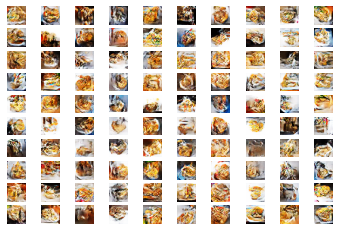

In [111]:
##########################################################
# Now, let us load the generator model and generate images
# Lod the trained model and generate a few images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.models import load_model
import numpy as np
# 

# load model

loadname = "foodGenerator_"+str(epochs_trial)+"epochs_"+str(128)+"batch.h5" 

model = load_model(loadname)

# generate multiple images

latent_points, labels = generate_latent_points(100, 100)
# specify labels - generate 10 sets of labels each gping from 0 to 9
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
# plot the result (10 sets of images, all images in a column should be of same class in the plot)
# Plot generated images 
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()
    
show_plot(X, 10)



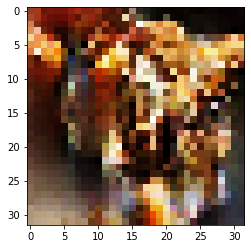

In [112]:
plt.imshow(X[2])
